# FEIII Challenge with SVM
## Task
Add a column *score* (ranking score, 0<score<1), such that:

  >We interpret confidence broadly as follows: the sentences in the triple are relevant
  >and interesting with respect to the filing financial entity, and/or the sentences provide evidence
  >for the specific relationship, described by the role keyword, between the filing financial entity
  >and the mentioned financial entity.
 
Ranking per group, whereas groups are the 10 roles.

https://ir.nist.gov/feiii/2017-challenge.html


Example 10-k filing:
https://www.sec.gov/ix?doc=/Archives/edgar/data/1432271/000137647417000016/rmp-20161231.htm

## Expert Ratings

**Highly Relevant Sentences:** One type of highly relevant sentences will identify potential
sources of significant (large) expenses and/or significant business opportunities. Examples of
the source of the expenses or opportunities include litigation, spin-offs, acquisitions, etc. Most of
these sentences describe a change from the status quo or current situation. Another type of
highly relevant sentence will identify corporate character, e.g., the compensation of senior
executives or commentary about business activities.

**Relevant Sentences:** One type of relevant sentences will identify existing assets, liabilities,
revenues, or expenses. They may be very specific, e.g., interest rate expenses. Another type of
relevant sentences will also identify the size and nature of current business activities, e.g., retail
division, underwriting, investment banking, etc.

**Neutral Sentences:** These sentences may describe the type of business activity, the location of
some business entity or activity. They are informative sentences but convey less information
value compared to the highly relevant or relevant sentences.

**Irrelevant:** This is boilerplate text that is not informative. In some cases, the extracted
sentences may be irrelevant to the filing financial entity or the mentioned entity or the role.

## init stuff

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import os
from collections import Counter
import spacy
import re
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.model_selection import train_test_split
nlp = spacy.load('en')

In [2]:
# forward mapping
#rating_map = {'Irrelevant':0.0, 'Neutral': 0.4, 'Relevant':0.75, 'Highly relevant': 1.0}
rating_map  = {'Irrelevant': 0, 'Neutral': 0, 'Relevant': 1, 'Highly relevant': 2}
rating_map2 = {'irrelevant': 0, 'neutral': 0, 'relevant': 1, 'highly': 2}

# normally (wikipedia) scale 0,1,2,3 
rating_map  = {'Irrelevant': 0, 'Neutral': 1, 'Relevant': 2, 'Highly relevant': 3}
rating_map2 = {'irrelevant': 0, 'neutral': 1, 'relevant': 2, 'highly': 3}

# text says "The pRL gets one point of gain for each relevant triple and two points for each highly relevant triple"

# backward mapping
def avg2rating(rating_avg):
    try:
        if rating_avg < 1.0:
            return 'irrelevant'
        if rating_avg <= 1.7:
            return 'neutral'
        if rating_avg <= 2.5:
            return 'relevant'
        return 'highly'
    except:
        return rating_avg

def dcg_np(ol, p):
    ol = ol[:p]
    try:
        return ol[0] + np.sum(ol[1:] / np.log2(np.arange(2, ol.size+1)))
    except:
        return np.nan

def ndcg_np(ol, ideal, p):
    try:
        return dcg_np(ol, p) / dcg_np(ideal, p)
    except:
        return np.nan
    
def ndcg(frame, p=None):
    if not p:
        p = len(frame)
    
    scored = np.array(frame.sort_values('score', ascending=False)['rating_avg'])
    ideal = np.array(frame.sort_values('rating_avg', ascending=False)['rating_avg'])
    
    return ndcg_np(scored, ideal, p)

def ndcg2(frame, scoring, p=None):
    if not p:
        p = len(frame)
    
    frmap = frame['rating'].map(rating_map2)
    s = np.array([sc[1] for sc in scoring])
    
    scored = np.array([frmap.loc[scoring[i][0]] for i in (-s).argsort()])
    ideal = np.array(frmap.sort_values(ascending=False))
    
    return ndcg_np(scored, ideal, p)

In [3]:
from IPython.display import HTML
import pprint

def pp(obj):
    return pprint.pformat(obj).replace('\n','<br />')

frame = pd.DataFrame()
list_ = []

wsetdir = '/home/tim/Uni/HPI/workspace/FEII/'
wset = pd.read_csv(wsetdir+'Working.csv')

traindir = '/home/tim/Uni/HPI/workspace/FEII/Training/'
for file in os.listdir(traindir):
    if file.endswith('.csv'):
        df = pd.read_csv(traindir+file,index_col=None)
        df['FILE'] = [file] * len(df)
        print('reading file', file,'with',len(df),'entries.')
        list_.append(df)

train = pd.concat(list_)
train.reset_index(drop=True, inplace=True)

train['grp'] = train['ROLE'].map(lambda x: re.sub("(ies|y|s)$","",x)).str.lower()
wset['grp'] = wset['ROLE'].map(lambda x: re.sub("(ies|y|s)$","",x)).str.lower()

roles = dict(Counter(wset['grp']))

out = '<table><tr><th></th><th>WORKING SET</th><th>TRAINING SET</th></tr>'
out+= '<tr><td>#ROWS</td><td>'+str(len(wset))+'</td><td>'+str(len(train))+'</td></tr>'
out+= '<tr><td>COLUMNS</td><td>'+pp(wset.columns)+'</td><td>'+pp(train.columns)+'</td></tr>'
out+= '<tr><td>ROLES</td><td>'+pp(dict(Counter(wset['grp'])))+'</td><td>'+pp(dict(Counter(train['grp'])))+'</td></tr>'
out+= '<tr><td>COMPANIES</td><td>'+pp(dict(Counter(wset['FILER_NAME'])))+'</td><td>'+pp(dict(Counter(train['FILER_NAME'])))+'</td></tr>'
out+= '<tr><td>Expert ratings</td><td>none</td><td>'
for c in train.filter(regex=("RATING")):
    out+= str(c)+' '+str(Counter(train[c]))+'<br/>'
out+= '</td></tr>'
out+= '</table>'

    
HTML(out)

reading file STATE-STREET_2016.csv with 23 entries.
reading file STATE-STREET_2014.csv with 26 entries.
reading file PNC_2016.csv with 33 entries.
reading file PNC_2014.csv with 38 entries.
reading file JPM_2016.csv with 52 entries.
reading file COMERICA_2016.csv with 11 entries.
reading file FIFTH-THIRD_2014.csv with 36 entries.
reading file CITIGROUP_2014.csv with 52 entries.
reading file AMERICAN-EXPRESS_2015.csv with 11 entries.
reading file BANK-OF-AMERICA_2015.csv with 74 entries.
reading file ALLY_2016.csv with 44 entries.
reading file CITIGROUP_2016.csv with 50 entries.
reading file ALLY_2014.csv with 40 entries.
reading file SUNTRUST_2013.csv with 35 entries.
reading file DISCOVER_2014.csv with 41 entries.
reading file MORGAN-STANLEY_2015.csv with 128 entries.
reading file SUNTRUST_2016.csv with 27 entries.
reading file BBT_2014.csv with 14 entries.
reading file GENERAL-ELECTRIC_2013.csv with 21 entries.
reading file FIFTH-THIRD_2015.csv with 46 entries.
reading file CAPITAL-O

,WORKING SET,TRAINING SET
#ROWS,9597,975
COLUMNS,"Index(['DOCUMENT_TYPE', 'FILER_NAME', 'FILER_CIK', 'FILING_INTERVAL', 'FILING_DATE', 'MENTIONED_FINANCIAL_ENTITY', 'PP_RSSD_ID', 'ROLE', 'THREE_SENTENCES', 'grp'], dtype='object')","Index(['COMMENT_EXPERT_1', 'COMMENT_EXPERT_1.1', 'COMMENT_EXPERT_10', 'COMMENT_EXPERT_2', 'COMMENT_EXPERT_3', 'COMMENT_EXPERT_4', 'COMMENT_EXPERT_5', 'COMMENT_EXPERT_6', 'COMMENT_EXPERT_7', 'COMMENT_EXPERT_9', 'DOCUMENT_TYPE', 'FILE', 'FILER_CIK', 'FILER_NAME', 'FILING_DATE', 'FILING_INTERVAL', 'MENTIONED_FINANCIAL_ENTITY', 'PP_RSSD_ID', 'RATING_EXPERT_1', 'RATING_EXPERT_1.1', 'RATING_EXPERT_10', 'RATING_EXPERT_2', 'RATING_EXPERT_3', 'RATING_EXPERT_4', 'RATING_EXPERT_5', 'RATING_EXPERT_6', 'RATING_EXPERT_7', 'RATING_EXPERT_9', 'ROLE', 'THREE_SENTENCES', 'grp'], dtype='object')"
ROLES,"{'affiliate': 1306, 'agent': 558, 'counterpart': 1168, 'guarantor': 359, 'insurer': 487, 'issuer': 1214, 'seller': 537, 'servicer': 632, 'trustee': 2763, 'underwriter': 573}","{'affiliate': 186, 'agent': 61, 'counterpart': 64, 'guarantor': 34, 'insurer': 19, 'issuer': 129, 'seller': 20, 'servicer': 21, 'trustee': 420, 'underwriter': 21}"
COMPANIES,"{'AMERICAN EXPRESS CO': 114, 'Ally Financial Inc': 554, 'BANK OF AMERICA CORP': 924, 'BB&T CORP': 100, 'Bank of New York Mellon Corp': 365, 'CAPITAL ONE FINANCIAL CORP': 305, 'CITIGROUP INC': 442, 'COMERICA INC': 59, 'Discover Financial Services': 325, 'FEDERAL_HOME_LOAN_MORTGAGE_CORP': 1199, 'FEDERAL_NATIONAL_MORTGAGE_ASSOCIATION_FANNIE_MAE': 615, 'FIFTH THIRD BANCORP': 299, 'GENERAL ELECTRIC CO': 153, 'GOLDMAN SACHS GROUP INC': 434, 'HUNTINGTON BANCSHARES INC': 27, 'JPMORGAN CHASE & CO': 945, 'KEYCORP': 76, 'M&T BANK CORP': 220, 'MORGAN STANLEY': 815, 'NORTHERN TRUST CORP': 246, 'PNC FINANCIAL SERVICES GROUP INC': 289, 'SCHWAB_CHARLES_CORP ': 107, 'STATE STREET CORP': 326, 'SUNTRUST BANKS INC': 349, 'US_BANCORP': 96, 'WELLS FARGO & COMPANY': 151, 'ZIONS BANCORPORATION': 62}","{'AMERICAN EXPRESS CO': 11, 'Ally Financial Inc': 84, 'BANK OF AMERICA CORP': 162, 'BB&T CORP': 14, 'CAPITAL ONE FINANCIAL CORP': 25, 'CITIGROUP INC': 102, 'COMERICA INC': 11, 'Discover Financial Services': 41, 'FIFTH THIRD BANCORP': 82, 'GENERAL ELECTRIC CO': 21, 'JPMORGAN CHASE & CO': 52, 'M&T BANK CORP': 42, 'MORGAN STANLEY': 128, 'NORTHERN TRUST CORP': 18, 'PNC FINANCIAL SERVICES GROUP INC': 71, 'STATE STREET CORP': 49, 'SUNTRUST BANKS INC': 62}"
Expert ratings,none,"RATING_EXPERT_1 Counter({nan: 566, 'Highly relevant': 149, 'Neutral': 139, 'Relevant': 93, 'Irrelevant': 28})RATING_EXPERT_1.1 Counter({nan: 749, 'Highly relevant': 101, 'Neutral': 83, 'Relevant': 35, 'Irrelevant': 7})RATING_EXPERT_10 Counter({nan: 955, 'Relevant': 20})RATING_EXPERT_2 Counter({nan: 609, 'Relevant': 163, 'Neutral': 131, 'Highly relevant': 58, 'Irrelevant': 14})RATING_EXPERT_3 Counter({nan: 915, 'Irrelevant': 29, 'Neutral': 15, 'Highly relevant': 8, 'Relevant': 8})RATING_EXPERT_4 Counter({nan: 940, 'Relevant': 23, 'Neutral': 5, 'Highly relevant': 5, 'Irrelevant': 2})RATING_EXPERT_5 Counter({nan: 895, 'Neutral': 41, 'Relevant': 29, 'Highly relevant': 7, 'Irrelevant': 3})RATING_EXPERT_6 Counter({nan: 915, 'Relevant': 34, 'Highly relevant': 10, 'Irrelevant': 10, 'Neutral': 6})RATING_EXPERT_7 Counter({nan: 900, 'Neutral': 36, 'Relevant': 27, 'Highly relevant': 10, 'Irrelevant': 2})RATING_EXPERT_9 Counter({nan: 901, 'Highly relevant': 62, 'Irrelevant': 10, 'Neutral': 1, 'Relevant': 1})"


Rating distribution (0-irrelevant, 1-neutral, 2-relevant, 3-highly relevant)


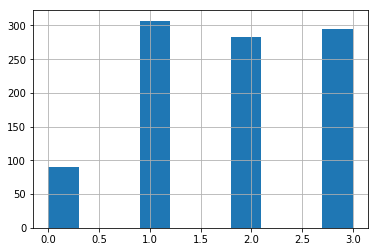

In [4]:
%matplotlib inline
cnts = []
avgs = []
rats = []
mins = []
maxs = []
for n, row in train.replace(to_replace=rating_map).filter(regex=("RATING")).iterrows():
    cnt = 0
    s = -1
    for k,v in row.to_dict().items():
        if v >= 0:
            cnt += 1
            s = v if s < 0 else s+v
    cnts.append(cnt)
    avgs.append(s/cnt if cnt > 0 else -1)
    rats.append(avg2rating(s/cnt if cnt > 0 else -1))
    mins.append(row.min())
    maxs.append(row.max())
   
train['num_experts'] = cnts
train['rating_avg'] = avgs
train['rating'] = rats
train['rating_min'] = mins
train['rating_max'] = maxs
cols = ['FILER_NAME', 'MENTIONED_FINANCIAL_ENTITY', 'ROLE','grp',
        'rating','rating_avg', 'num_experts', 'rating_min','rating_max', 'THREE_SENTENCES', 
        'FILING_DATE', 'DOCUMENT_TYPE', 'FILE', 'FILER_CIK', 'FILING_INTERVAL', 'PP_RSSD_ID']

print('Rating distribution (0-irrelevant, 1-neutral, 2-relevant, 3-highly relevant)')
train['rating'].map(rating_map2).hist()

In [5]:
fil, rol, men = (0,0,0)
mask = []

def k(bo):
    return '(miss)' if not bo else '(y)'

for a,b in train.iterrows():
    t, u , v = False, False, False
    s = b['THREE_SENTENCES'].lower().replace('\n',' ')
    if b['ROLE'].lower() in s:
        rol += 1
        t = True
    if b['MENTIONED_FINANCIAL_ENTITY'].lower() in s:
        men += 1
        u = True
    if b['FILER_NAME'].lower() in s:
        fil += 1
        v = True
    #if not t or not u:
        #print('>',a,b['ROLE'],k(t),'|',b['MENTIONED_FINANCIAL_ENTITY'],k(u),'|',b['FILER_NAME'],k(v),'|',b['FILE'])
        #print(b['THREE_SENTENCES'])
        #print(s)
        #print('----------')
    mask.append(not(not t or not u))
print('Sum:',rol,'|', men,'|', fil)
print('of total:', len(train))
print('after applying mask:',len(train[mask]))

Sum: 971 | 970 | 357
of total: 975
after applying mask: 968


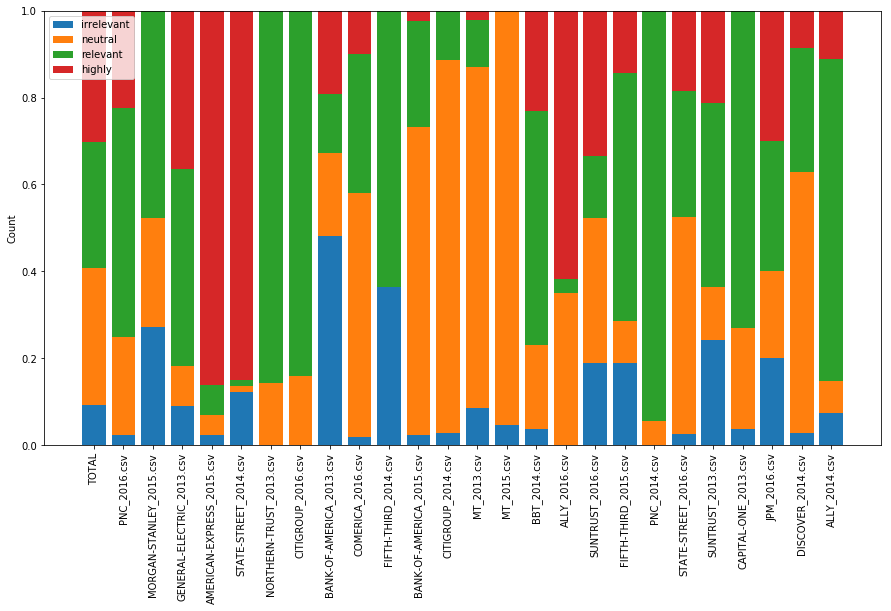

In [428]:
tmpmodel.draw_rating_distribution()

# Classifier

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.svm import SVC
import IPython.display as dp
from pandas import Index

class Lemmatiser(BaseEstimator, TransformerMixin):
    def __init__(self, textcol='THREE_SENTENCES'):
        self.textcol = textcol

    def fit(self, x, y=None):
        return self

    def transform(self, frm):
        if 'clean' in frm.columns:
            return list(frm['clean'])
        
        texts = []
        for doc, row in frm.iterrows():
            tmp = []
            text = row[self.textcol]
            for token in nlp(text):
                if not (token.like_num or \
                        token.is_stop or \
                        token.is_space or \
                        token.is_digit or \
                        token.is_punct or \
                        len(token.orth_)<3):
                    tmp.append(token.lemma_)
            texts.append(' '.join(tmp))
        return texts


class IDFscorer:
    
    def __init__(self, frm, grp=None, train_size=0.6, stratify_docs=True, tritei=None, 
                 twoclassmode=False, enrich=None, lemmatise=True, pipln=[],
                 max_docsplit_iter=15, max_docsplit_diff=0.3):
        
        self.twoclassmode = twoclassmode
        self.ratingmap =  {'irrelevant': 0, 'neutral': 0, 'relevant': 1, 'highly': 1} if twoclassmode else \
                          {'irrelevant': 0, 'neutral': 1, 'relevant': 2, 'highly': 3}
        
        mask = [True]*len(frm) if not grp else (frm['grp']==grp)
        self.rating_agg = self._get_rating_agg(frm[mask])
        self.files = list(set(frm[mask]['FILE']))
        
        if tritei:
            tri, tei = tritei
        elif not stratify_docs:
            straty = list(frm[mask]['rating']) \
                    if min(Counter(frm[mask]['rating']).values())>1 else None
                
            tri, tei = train_test_split(list(frm[mask].index), 
                                        train_size=train_size, 
                                        stratify=straty)
        else:
            if stratify_docs:
                
                t = train_size*len(frm[mask])
                tri, tei = [],[]
                iter_cnt = 0
                while iter_cnt < max_docsplit_iter:
                    #safeguard against infinite loop
                    iter_cnt += 1
                    
                    rnd_order = np.arange(len(self.files))
                    np.random.shuffle(rnd_order)
                    
                    chosen_files = []
                    for fi in rnd_order:
                        check = chosen_files + [self.files[fi]]
                        tri = list(frm[mask&frm['FILE'].isin(check)].index)
                        tei = list(frm[mask&frm['FILE'].isin(set(self.files)-set(check))].index)
                        
                        # test/train ratio would get too large, so skip!
                        if (len(tri)/len(frm[mask])) > (train_size+0.1):
                            continue
                        
                        chosen_files.append(self.files[fi])
                        
                        if (len(tri)/len(frm[mask])) > train_size:
                            break
                    
                    # sometimes there are not enough docs, so just add one
                    if (len(tri)/len(frm[mask])) < train_size:
                        #print('adding emergancy document')
                        chosen_files += list(set(self.files)-set(chosen_files))[0]
                        tri = list(frm[mask&frm['FILE'].isin(chosen_files)].index)
                        tei = list(frm[mask&frm['FILE'].isin(set(self.files)-set(chosen_files))].index)
                    
                    if len(set(frm.loc[tei]['FILE']))<1:
                        #print('removing emergancy document')
                        chosen_files.pop()
                        tri = list(frm[mask&frm['FILE'].isin(chosen_files)].index)
                        tei = list(frm[mask&frm['FILE'].isin(set(self.files)-set(chosen_files))].index)
                    
                    a = self._get_rating_agg(frm.loc[tri])
                    b = self._get_rating_agg(frm.loc[tei])
                    
                    #print('diff', np.abs(a.sum(axis=1)/a.sum() - b.sum(axis=1)/b.sum()).sum() )
                    # difference in ratings isn't too bad, keep this split
                    if np.abs(a.sum(axis=1)/a.sum() - b.sum(axis=1)/b.sum()).sum() < (max_docsplit_diff + (max(0, iter_cnt-5)/100)):
                        break
            
        
        self.trainfrm = frm.loc[tri]
        self.testfrm = frm.loc[tei]
        self.grp = grp
        
        if enrich is not None:
            mask = [True]*len(wset) if not grp else (wset['grp']==grp)
            self.trainfrm = pd.concat([self.trainfrm, 
                                       wset[mask].sample(enrich*len(self.trainfrm[self.trainfrm['rating']!='irrelevant']))])\
                              .fillna({'rating': 'irrelevant', 'rating_avg': 0.5})
            
        self.index = {}
        self.texts = []
        
        self.clf = Pipeline(pipln)
        
        if lemmatise:
            self.trainfrm = self.lemmatise(self.trainfrm)
            self.testfrm = self.lemmatise(self.testfrm)
    
    def _get_rating_agg(self, frm):
        # create pivot table
        tmp = frm.pivot_table(values='rating_avg', 
                               columns=['rating'], 
                               index=['FILE'], 
                               aggfunc=lambda x: len(x)).fillna(0)
        cols = ['irrelevant','neutral','relevant','highly']
        
        # fill missing columns
        for c in set(cols)-set(tmp.columns):
            tmp[c] = [0.0]*len(tmp)
        
        return tmp[cols].as_matrix().T
        
    def lemmatise(self, frm): 
        texts = []
        for doc, row in frm.iterrows():
            tmp = []
            text = row['THREE_SENTENCES']
            for token in nlp(text):
                if not (token.like_num or \
                        token.is_stop or \
                        token.is_space or \
                        token.is_digit or \
                        token.is_punct or \
                        len(token.orth_)<3):
                    tmp.append(token.lemma_)
            texts.append(' '.join(tmp))
        frm['clean'] = texts
        return frm
        
        
    def fit(self):
        self.clf.fit(self.trainfrm, self.get_target(frm=self.trainfrm))
    
    
    def predict(self, frm=None):
        # use own testframe if nothing else is requested
        if frm is None:
            frm = self.testfrm
        
        num_targets = 2 if self.twoclassmode else 4
        
        # make prediction (some options don't allow predict_proba, so simulate it!)
        try:
            pred = self.clf.predict_proba(frm)
        except AttributeError as e:
            print('predict_proba failed:', e)
            pred = np.zeros((len(frm), num_targets))
            pred[np.arange(len(frm)), self.clf.predict(frm)] = 1

        # in case a category is missing, add it
        if pred.shape[1] < num_targets:
            tmp = np.zeros((len(pred), num_targets))
            col = 0
            for mi in range(num_targets):
                if mi in set(self.trainfrm['rating'].map(self.ratingmap)):
                    tmp[:,mi:mi+1] = pred[:,col:col+1]
                    col += 1
            pred = tmp
            
        return pred.argmax(axis=1), pred
    
    
    def transform(self, frm=None):
        if frm is None:
            frm = self.testfrm
        
        pred = self.clf.transform(frm, self.get_target(frm=frm))
        return pred.argmax(axis=1), pred
    
    
    def fit_transform(self, frm=None):
        if frm is None:
            frm = self.testfrm
        
        pred = self.clf.fit_transform(frm, self.get_target(frm=frm))
        
        try:
            return pred.argmax(axis=1), pred
        except AttributeError:
            return pred
    
    
    def get_vocabulary(self):
        return self.clf.named_steps['tfidf'].vocabulary_
    
    
    def get_inv_vocabulary(self):
        return {i: w for w,i in self.clf.named_steps['tfidf'].vocabulary_.items()}
    
    
    def get_target(self, frm=None):
        # use own testframe if nothing else is requested
        if frm is None:
            frm = self.testfrm
        return frm['rating'].map(self.ratingmap)
    
    
    def draw_rating_distribution(self, relative=True, include_total=True, figsize=(15,8)):
        files = self.files
        rating_agg = self.rating_agg
        if include_total:
            files = ['TOTAL'] + files
            rating_agg = np.column_stack((self.rating_agg.sum(axis=1), rating_agg))

        if relative:
            rating_agg = rating_agg/rating_agg.sum(axis=0)

        plt.figure(figsize=figsize)

        p0 = plt.bar(np.arange(len(files)), rating_agg[0])
        p1 = plt.bar(np.arange(len(files)), rating_agg[1], bottom=rating_agg[0])
        p2 = plt.bar(np.arange(len(files)), rating_agg[2], bottom=rating_agg[0]+rating_agg[1])
        p3 = plt.bar(np.arange(len(files)), rating_agg[3], bottom=rating_agg[0]+rating_agg[1]+rating_agg[2])

        plt.ylabel('Count')
        plt.xticks(np.arange(len(files)), files, rotation=90)
        plt.legend((p0[0], p1[0], p2[0], p3[0]), ('irrelevant', 'neutral', 'relevant', 'highly'))
        plt.show()
    
    
    def short_setinfo(self):
        print('Items in training set:', len(self.trainfrm),
              '({:.2f}%)'.format(len(self.trainfrm)/(len(self.trainfrm)+len(self.testfrm))*100))
        print('Items in testing set:', len(self.testfrm))
        print(' =', len(self.trainfrm)+len(self.testfrm))
        
        a = len(set(self.trainfrm['FILE']))
        b = len(set(self.testfrm['FILE']))
        print('Number of documents:', a+b, 'total,',a,'train,',b,'test')
        out = '<table><tr><th></th><th>irrelevant</th><th>neutral</th><th>relevant</th><th>highly</th></tr>'
        out+= '<tr><td>Total (abs)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*self.rating_agg.sum(axis=1))
        out+= '<tr><td>Total (rel)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*self.rating_agg.sum(axis=1)/self.rating_agg.sum())
            
        rats = ['irrelevant', 'neutral', 'relevant', 'highly']
        rattr = self.trainfrm[['rating','rating_avg']].groupby('rating').count()['rating_avg']\
            .reindex(Index(rats)).fillna(0)[rats].as_matrix().reshape((4,))
        ratte = self.testfrm[['rating','rating_avg']].groupby('rating').count()['rating_avg']\
            .reindex(Index(rats)).fillna(0)[rats].as_matrix().reshape((4,))
        out+= '<tr><td>Train (abs)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*rattr)
        out+= '<tr><td>Test (abs)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*ratte)
        out+= '<tr><td>Train (rel)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*(rattr/rattr.sum()))
        out+= '<tr><td>Test (rel)</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*(ratte/ratte.sum()))
        out+= '<tr><td>diff</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td><td>{:.2f}</td></tr>'.\
            format(*((rattr/rattr.sum())-(ratte/ratte.sum())))
        out+= '</table>'
        
        dp.display_html(out, raw=True)
        
        for e in ['RATING_EXPERT_1', 'RATING_EXPERT_2', 'RATING_EXPERT_3','RATING_EXPERT_4', 'RATING_EXPERT_5', 
                  'RATING_EXPERT_6', 'RATING_EXPERT_7', 'RATING_EXPERT_1.1', 'RATING_EXPERT_9','RATING_EXPERT_10']:
            tr = self.trainfrm[self.trainfrm[e].notnull()]
            te = self.testfrm[self.testfrm[e].notnull()]
            if (len(tr)+len(te)) > 0:
                print("{} gave {} ratings, in train: {}, in test: {}.".format(e, 
                                                                              len(tr)+len(te), 
                                                                              len(tr), 
                                                                              len(te)))
            
            
    def establish_baseline(self, include_test=True, include_train=False, num_random=100):
        if include_test and include_train:
            tmp = pd.concat(self.testfrm, self.trainfrm)
        elif include_test:
            tmp = self.testfrm
        else:
            tmp = self.trainfrm

        ndcgtest = []
        for k in range(num_random):
            ndcgtest.append(ndcg2(tmp, [(tmp.index[k],v) for k,v in enumerate(np.random.rand(len(tmp)))]))

        print('NDCG after '+str(num_random)+'x random order:')
        print(' > mean ndcg =', np.mean(ndcgtest), '| std =', np.std(ndcgtest))

        print('NDCG for worst case (inverted best) order:')
        worst = ndcg2(tmp, [(i, abs(self.ratingmap[r['rating']] - (1 if self.twoclassmode else 3))) \
                            for i,r in tmp.iterrows()])
        print(' > ndcg =', worst)
        
        return worst, ndcgtest
    
    
    # TF.IDF Stuff ----------------------------
        
    
    def build_index(self):        
        self.index = {}
        self.texts = []
        for doc, row in self.trainfrm.iterrows():
            tmp = []
            text = row['THREE_SENTENCES']
            for token in nlp(text):
                tmp.append(token.lemma_)
                if not (token.like_num or \
                        token.is_stop or \
                        token.is_space or \
                        token.is_digit or \
                        token.is_punct or \
                        len(token.orth_)<3):
                    
                    if token.lemma_ not in self.index:
                        self.index[token.lemma_] = {
                            'cnt': 0,
                            'docs': {},
                            'ratings': {}
                        }
                    self.index[token.lemma_]['cnt'] += 1
                    self.index[token.lemma_]['docs'][doc] = self.index[token.lemma_]['docs'].get(doc, 0) + 1
                    self.index[token.lemma_]['ratings'][row['rating']] = self.index[token.lemma_]['ratings'].get(row['rating'], 0) + 1
            self.texts.append((doc,tmp))

        self.texts = [(doc,[token for token in text if token in self.index and self.index[token]['cnt'] > 1]) for doc, text in self.texts]
        
        for i,(token, props) in enumerate(self.index.items()):
            self.index[token]['tf'] = np.sum(list(props['docs'].values()))
            self.index[token]['idf'] = len(self.texts)/len(props['docs'])
            self.index[token]['idf_rat'] = len(self.texts)/len(props['ratings'])
            
    
    # @param norm_all if true, divide by all tokens, otherwise only valid ones
    def idf_rank_score(self, norm_all=False, min_tf=0, grp=None):
        scr = []
        scr_rat = []
        mask = [True]*len(self.testfrm) if not grp else (self.testfrm['grp']==grp)
        tmp = self.testfrm[mask].copy(deep=True)
        for doc, row in tmp.iterrows():
            score = 0
            score_r = 0
            l = 0
            for token in nlp(row['THREE_SENTENCES']):
                if token.lemma_ in self.index and self.index[token.lemma_]['tf']>=min_tf:
                    score_r += self.index[token.lemma_]['idf_rat']
                    score += self.index[token.lemma_]['idf']
                    l+= 0 if norm_all else 1
                l+= 1 if norm_all else 0
            l = l if l != 0 else 1
            scr.append((doc, score/l))
            scr_rat.append((doc, score_r/l))

        norminfo = '(divided by num of all tokens)' if norm_all else '(divided by num of valid tokens)'

        print('NDCG based sum of document IDFs in the text'+norminfo+', min TF: '+str(min_tf))
        nda = ndcg2(tmp, scr)
        print('  >', nda)

        print('NDCG based sum of rating IDFs in the text'+norminfo+', min TF: '+str(min_tf))
        ndb = ndcg2(tmp, scr_rat)
        print('  >', ndb)

        return (nda, ndb, scr_rat)
    
    
    def stats_for_sentence(self, doc_id):
        for token in dict(self.texts)[doc_id]:
            itok = self.index[token]
            print(token+'\ttf:', itok['docs'][doc_id], 
                  '\tidf:', '%.2f' % itok['idf'],
                  '\tidf_rat:', '%.2f' % itok['idf_rat'],
                  '\tin docs:', len(itok['docs']),
                  '\tN:', len(self.texts))
    
    
    def print_index(self, sortby='idf', top_n=200):
        for a, b in sorted(list(self.index.items()), reverse=True, key=lambda x: x[1][sortby])[:top_n]:
            print(a,
                  '\t- idf:', b['idf'], 
                  '\t- idf_rat:', b['idf_rat'],
                  '\t- tf:', b['tf'],
                  '\t- in docs:', len(b['docs']))

## Calculate Scores (Four class approach)

* text preprocessing/feature vectors
 * each text is lowercased and lemmatised
 * construct ngrams (length 1-3) for each text and count occurences
 * filter ngrams by min and max document frequency
 * calcuate idf
 * construct vector for text using idf scores of appearing ngrams
* There are 11 classifiers, one for each of the 10 roles and one trained across all roles.
* A classifier targets are the four relevance levels (or two: relevant/irrelevant)
* For each role:
 * split data into training/testing
 * train classifier
 * predict test data using this classifier and the one trained across all roles
 * calculate ranking scores: 
   * sorting score equals class with highest confidence score
   * sorting score equals weighted sum of class confidence scores
 * sort using these scores and calculate four NDCG scores accordingly
 * keep individual scores per item
* sort all test items across roles using previously calculated scores
* calculate all four overall NDCG scores

### Findings/Discussion
* without min/max filter, features of high importance are mostly named entities, suggesting an overfitted model
 * introducing the filter reduces the classification performance, ndcg scores drops from >0.99 to >0.97
* ngram range of 1-3 appears to be good
 * longer ngrams are likely filtered (especially due to few training samples)
 * lower/no ngrams completely disregard context
* classifier class weight
 * dataset is imbalanced, biased towards relevant documents
 * weighting negatively affects accuracy, since more items are classified to be less relevant
 * keeping weights still might be sensible due to the bias; otherwise overfitted
* two classifier types
 * hypothesis and assumptions: training a classifier disregarding the roles provides more training samples under the assumption that wording remains similar with respect to the relevance. on the other hand the role specific wording is neglected
 * the classifier trained over all roles generally performs better, however the effect of few training samples might also an explanation for that
* sorting scores
 * hypothesis: using argmax score for sorting is prone to classification errors, incorporating confidence scores introduces gradient sorting scores
 * hypothesis appears to be proven, although effects are small
 * missclassification one class off likely has no influence on ndcg

In [18]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
cv_par = {
    #'ngram_range': (1, 3),
    'min_df': 0.4,
    'max_df': 0.6,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('syntax', Pipeline([
                ('feats', SyntaxFeatures()),
            ])),
            ('bow', Pipeline([
                ('lem', Lemmatiser()),
                ('vect', CountVectorizer(**cv_par)),
                ('tfidf', TfidfTransformer(**tt_par))
            ]))
        ],
        transformer_weights={
            'syntax': 1,
            'bow': 1
        },
    )),
    #('clf', SGDClassifier(**clf_par))
]).fit_transform(svmfullmodel.testfrm).toarray()

array([[  5.63907285e+00,   2.00400000e+03,   1.07000000e+02, ...,
          1.31578947e-01,   9.93377483e-02,   0.00000000e+00],
       [  5.53275109e+00,   1.49500000e+03,   4.00000000e+00, ...,
          1.76000000e-01,   1.39737991e-01,   0.00000000e+00],
       [  5.53275109e+00,   1.49500000e+03,   4.00000000e+00, ...,
          1.76000000e-01,   1.39737991e-01,   0.00000000e+00],
       ..., 
       [  5.67164179e+00,   8.93000000e+02,   1.60000000e+01, ...,
          1.91780822e-01,   1.64179104e-01,   0.00000000e+00],
       [  6.27184466e+00,   7.48000000e+02,   1.00000000e+01, ...,
          1.79104478e-01,   1.74757282e-01,   0.00000000e+00],
       [  6.63461538e+00,   3.96000000e+02,   2.00000000e+00, ...,
          9.09090909e-02,   1.15384615e-01,   0.00000000e+00]])

In [16]:
# from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_fscore_support

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'loss': 'log', #['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
    'penalty': 'l2',
    'shuffle': True,
    'alpha': 1e-4,
    'n_iter': 15,
    'random_state': 42,
    'class_weight': 'balanced'
}

# for SVM
#clf_par = {
#    'C': 1.0,
#    'kernel': 'rbf', # linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
#    #'degree': 5, # polydegree
#    'max_iter': 1000,
#    #'class_weight': 'balanced',
#    'tol': 1e-4,
#}

# temporary storage for macro average score
conf_matrix_role = np.zeros((4,4))
conf_matrix_full = np.zeros((4,4))

# holer for stats
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
    'acc_role': [],
    'acc_full': [],
    'f1_role': [],
    'f1_full': []
}
macro_res = {
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
}

def pipln():
    if True:
        return [
            ('lem', Lemmatiser()),
            ('vect', CountVectorizer(**cv_par)),
            ('tfidf', TfidfTransformer(**tt_par)),
            ('clf', SGDClassifier(**clf_par))
        ]
    
    return [
        ('union', FeatureUnion(
            transformer_list=[
                ('syntax', Pipeline([
                    ('feats', SyntaxFeatures()),
                ])),
                ('bow', Pipeline([
                    ('lem', Lemmatiser()),
                    ('vect', CountVectorizer(**cv_par)),
                    ('tfidf', TfidfTransformer(**tt_par))
                ]))
            ],
            transformer_weights={
                'syntax': 1,
                'bow': 1
            },
        )),
        ('clf', SGDClassifier(**clf_par))
    ]

def get_tfidf(clf):
    if True:
        return clf.named_steps['tfidf']
    return clf.named_steps['union'].transformer_list[1][1].named_steps['tfidf']


ceiter = 5
for crosseval in range(ceiter):
    print("\n\n==========================================================================")
    print("===                   CROSSEVAL ITERATION " + str(crosseval+1)+"/"+str(ceiter) + "                   =====")
    print("==========================================================================\n\n")
    
    scores_role = []
    scores_full = []
    scores_role_proba = []
    scores_full_proba = []
    
    # prepare model for full set over all roles classifying relevance
    svmfullmodel = IDFscorer(frm=train[mask], train_size=0.7,
                             pipln=pipln())
    svmfullmodel.short_setinfo()
    svmfullmodel.establish_baseline()
    svmfullmodel.fit()

    print(str(get_tfidf(svmfullmodel.clf)._idf_diag.shape[0])+' features')

    # run evaluation for each role
    for role in roles.keys():
        print('=== '+role.upper()+' ======')

        svmmodel = IDFscorer(frm=train[mask], grp=role,train_size=0.7, max_docsplit_iter=20,
                             pipln=pipln())
        svmmodel.short_setinfo()

        bl1, bl2 = svmmodel.establish_baseline(include_test=True, include_train=False)
        res['baseline_rand'].append(bl2)
        res['baseline_worst'].append(bl1)

        svmmodel.fit()
        print(str(get_tfidf(svmmodel.clf)._idf_diag.shape[0])+' features')

        # get predictions from model trained on role
        pred_role, pred_proba_role = svmmodel.predict(svmmodel.testfrm)

        # get predictions from model trained on all
        pred_full, pred_proba_full = svmfullmodel.predict(svmmodel.testfrm)

        score_role = np.sum(pred_proba_role * np.array([1,2,3,4]), axis=1)
        score_full = np.sum(pred_proba_full * np.array([1,2,3,4]), axis=1)

        # calculate accuracy 
        testtarget = svmmodel.get_target()
        res['acc_role'].append(np.mean(pred_role == testtarget))
        print('Accuracy | role :', np.mean(pred_role == testtarget))
        res['acc_full'].append(np.mean(pred_full == testtarget))
        print('Accuracy | full :', np.mean(pred_full == testtarget))

        _,_,f1,supp = precision_recall_fscore_support(testtarget, pred_full,labels=[0,1,2,3])
        res['f1_full'].append((f1*supp).sum()/supp.sum())
        _,_,f1,supp = precision_recall_fscore_support(testtarget, pred_role,labels=[0,1,2,3])
        res['f1_role'].append((f1*supp).sum()/supp.sum())

        # print classification report
        print(metrics.classification_report(testtarget, pred_full,
                                            labels=[0,1,2,3],
                                            target_names=list(rating_map2.keys())))

        # print confusion matrix
        conf_matrix_role += np.array(metrics.confusion_matrix(testtarget, pred_role, labels=[0,1,2,3]))
        cm = metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3])
        conf_matrix_full += np.array(cm)
        print(cm)
        #print(metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3]))

        # add scores to full list
        score_role_tmp = list(zip(list(svmmodel.testfrm.index), pred_role))
        scores_role += score_role_tmp
        score_full_tmp = list(zip(list(svmmodel.testfrm.index), pred_full))
        scores_full += score_full_tmp

        # add scores based on probability to full list
        score_role_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_role))
        scores_role_proba += score_role_proba_tmp
        score_full_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_full))
        scores_full_proba += score_full_proba_tmp

        # add NDCG to results
        res['ndcg_role'].append(ndcg2(svmmodel.testfrm, score_role_tmp))
        res['ndcg_role_proba'].append(ndcg2(svmmodel.testfrm, score_role_proba_tmp))
        res['ndcg_full'].append(ndcg2(svmmodel.testfrm, score_full_tmp))
        res['ndcg_full_proba'].append(ndcg2(svmmodel.testfrm, score_full_proba_tmp))

        # echo results
        print('> NDCG Score | role | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_tmp)))
        print('> NDCG Score | role | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_proba_tmp)))
        print('> NDCG Score | full | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_tmp)))
        print('> NDCG Score | full | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_proba_tmp)))
    
    
    # echo results of NDCG for entire set
    tmp = ndcg2(train.loc[[k for k,v in scores_role]], scores_role)
    macro_res['ndcg_role'].append(tmp)
    print('TOTAL NDCG | role | categ  | {:.5f}'.format(tmp))

    tmp = ndcg2(train.loc[[k for k,v in scores_role_proba]], scores_role_proba)
    macro_res['ndcg_role_proba'].append(tmp)
    print('TOTAL NDCG | role | proba* | {:.5f}'.format(tmp))

    
    tmp = ndcg2(train.loc[[k for k,v in scores_full]], scores_full)
    macro_res['ndcg_full'].append(tmp)
    print('TOTAL NDCG | full | categ  | {:.5f}'.format(tmp))
    
    
    tmp = ndcg2(train.loc[[k for k,v in scores_full_proba]], scores_full_proba)
    macro_res['ndcg_full_proba'].append(tmp)
    print('TOTAL NDCG | full | proba* | {:.5f}'.format(tmp))



===                   CROSSEVAL ITERATION 1/5                   =====


Items in training set: 698 (72.11%)
Items in testing set: 270
 = 968
Number of documents: 25 total, 18 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),73.00,211.00,211.00,203.00
Test (abs),16.00,95.00,69.00,90.00
Train (rel),0.10,0.30,0.30,0.29
Test (rel),0.06,0.35,0.26,0.33
diff,0.05,-0.05,0.05,-0.04


RATING_EXPERT_1 gave 406 ratings, in train: 248, in test: 158.
RATING_EXPERT_2 gave 366 ratings, in train: 256, in test: 110.
RATING_EXPERT_3 gave 60 ratings, in train: 39, in test: 21.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 80, in test: 0.
RATING_EXPERT_6 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 221, in test: 1.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 20, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.892909002192 | std = 0.0168296586474
NDCG for worst case (inverted best) order:
 > ndcg = 0.756509818825
319 features
=== INSURER ======
Items in training set: 14 (73.68%)
Items in testing set: 5
 = 19
Number of documents: 8 total, 4 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,1.00,4.00,8.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.07,0.07,0.29,0.57
Test (rel),0.00,0.00,0.80,0.20
diff,0.07,0.07,-0.51,0.37


RATING_EXPERT_1 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_2 gave 4 ratings, in train: 1, in test: 3.
RATING_EXPERT_5 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_6 gave 3 ratings, in train: 2, in test: 1.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.969150255443 | std = 0.0300395600396
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
1358 features
Accuracy | role : 0.6
Accuracy | full : 0.8
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.75      0.86         4
     highly       0.50      1.00      0.67         1

avg / total       0.90      0.80      0.82         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 3 1]
 [0 0 0 1]]
> NDCG Score | role | 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 142 (76.76%)
Items in testing set: 43
 = 185
Number of documents: 22 total, 17 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),19.00,36.00,43.00,44.00
Test (abs),7.00,4.00,18.00,14.00
Train (rel),0.13,0.25,0.30,0.31
Test (rel),0.16,0.09,0.42,0.33
diff,-0.03,0.16,-0.12,-0.02


RATING_EXPERT_1 gave 81 ratings, in train: 64, in test: 17.
RATING_EXPERT_2 gave 63 ratings, in train: 39, in test: 24.
RATING_EXPERT_3 gave 19 ratings, in train: 0, in test: 19.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_7 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_1.1 gave 56 ratings, in train: 38, in test: 18.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 3, in test: 9.
NDCG after 100x random order:
 > mean ndcg = 0.848277236284 | std = 0.0408385107789
NDCG for worst case (inverted best) order:
 > ndcg = 0.638084690391
572 features
Accuracy | role : 0.186046511628
Accuracy | full : 0.651162790698
             precision    recall  f1-score   support

 irrelevant       1.00      0.86      0.92         7
    neutral       0.38      0.75      0.50         4
   relevant       

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 91 (70.54%)
Items in testing set: 38
 = 129
Number of documents: 24 total, 17 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),24.00,31.00,20.00,16.00
Test (abs),8.00,14.00,10.00,6.00
Train (rel),0.26,0.34,0.22,0.18
Test (rel),0.21,0.37,0.26,0.16
diff,0.05,-0.03,-0.04,0.02


RATING_EXPERT_1 gave 73 ratings, in train: 54, in test: 19.
RATING_EXPERT_2 gave 48 ratings, in train: 30, in test: 18.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 14 ratings, in train: 0, in test: 14.
RATING_EXPERT_5 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_6 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_7 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_1.1 gave 16 ratings, in train: 16, in test: 0.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 2, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.765880946533 | std = 0.0566074252968
NDCG for worst case (inverted best) order:
 > ndcg = 0.544920200634
356 features
Accuracy | role : 0.368421052632
Accuracy | full : 0.842105263158
             precision    recall  f1-score   support

 irrelevant       0.70      0.88      0.78         8
    neutral       0.79      0.79      0.79        14
   relevant       1.00    

,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,3.00,9.00
Test (abs),0.00,2.00,3.00,0.00
Train (rel),0.00,0.25,0.19,0.56
Test (rel),0.00,0.40,0.60,0.00
diff,0.00,-0.15,-0.41,0.56


RATING_EXPERT_1 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_2 gave 8 ratings, in train: 3, in test: 5.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.920420592357 | std = 0.0434142807883
NDCG for worst case (inverted best) order:
 > ndcg = 0.827320595203
1081 features
Accuracy | role : 0.4
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      1.00      1.00         2
   relevant       1.00      1.00      1.00         3
     highly       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 2 0 0]
 [0 0 3 0]
 [0 0 0 0]]
> NDCG Score | role | c

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 19 (55.88%)
Items in testing set: 15
 = 34
Number of documents: 6 total, 4 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,1.00,9.00,8.00
Test (abs),0.00,2.00,13.00,0.00
Train (rel),0.05,0.05,0.47,0.42
Test (rel),0.00,0.13,0.87,0.00
diff,0.05,-0.08,-0.39,0.42


RATING_EXPERT_1 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_2 gave 20 ratings, in train: 17, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 2, in test: 12.
NDCG after 100x random order:
 > mean ndcg = 0.971268746068 | std = 0.025720434215
NDCG for worst case (inverted best) order:
 > ndcg = 0.883392464749
1104 features
Accuracy | role : 0.333333333333
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      1.00      1.00         2
   relevant       1.00      1.00      1.00        13
     highly       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00        15

[[ 0  0  0  0]
 [ 0  2  0  0]
 [ 0  0 13  0]
 [ 0  0  0  0]]
> NDCG Score | role | categ  | 1.00000
> NDCG 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 309 (74.10%)
Items in testing set: 108
 = 417
Number of documents: 21 total, 14 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),16.00,127.00,59.00,107.00
Test (abs),4.00,36.00,20.00,48.00
Train (rel),0.05,0.41,0.19,0.35
Test (rel),0.04,0.33,0.19,0.44
diff,0.01,0.08,0.01,-0.10


RATING_EXPERT_1 gave 177 ratings, in train: 171, in test: 6.
RATING_EXPERT_2 gave 145 ratings, in train: 98, in test: 47.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_6 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_7 gave 25 ratings, in train: 21, in test: 4.
RATING_EXPERT_1.1 gave 81 ratings, in train: 76, in test: 5.
RATING_EXPERT_9 gave 50 ratings, in train: 0, in test: 50.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.891288704274 | std = 0.0252617257859
NDCG for worst case (inverted best) order:
 > ndcg = 0.732123391934
559 features
Accuracy | role : 0.768518518519
Accuracy | full : 0.824074074074
             precision    recall  f1-score   support

 irrelevant       1.00      0.25      0.40         4
    neutral       0.67      1.00      0.80        36
   relevant       0.83      0.25      0.38        20
     highly       1.00

,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),3.00,10.00,20.00,10.00
Test (abs),3.00,2.00,8.00,5.00
Train (rel),0.07,0.23,0.47,0.23
Test (rel),0.17,0.11,0.44,0.28
diff,-0.10,0.12,0.02,-0.05


RATING_EXPERT_1 gave 26 ratings, in train: 23, in test: 3.
RATING_EXPERT_2 gave 25 ratings, in train: 13, in test: 12.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 18 ratings, in train: 17, in test: 1.
RATING_EXPERT_9 gave 5 ratings, in train: 0, in test: 5.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.827789458295 | std = 0.0646513225424
NDCG for worst case (inverted best) order:
 > ndcg = 0.599553641447
575 features
Accuracy | role : 0.444444444444
Accuracy | full : 0.944444444444
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         3
    neutral       1.00      1.00      1.00         2
   relevant       0.89      1.00      0.94         8
     highly       1.00      0.80 

,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),3.00,24.00,13.00,4.00
Test (abs),0.00,11.00,5.00,1.00
Train (rel),0.07,0.55,0.30,0.09
Test (rel),0.00,0.65,0.29,0.06
diff,0.07,-0.10,0.00,0.03


RATING_EXPERT_1 gave 24 ratings, in train: 14, in test: 10.
RATING_EXPERT_2 gave 30 ratings, in train: 21, in test: 9.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 5, in test: 1.
RATING_EXPERT_1.1 gave 10 ratings, in train: 10, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.834699866164 | std = 0.0552177182276
NDCG for worst case (inverted best) order:
 > ndcg = 0.73940184921
458 features
Accuracy | role : 0.235294117647
Accuracy | full : 0.764705882353
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      0.64      0.78        11
   relevant       0.71      1.00      0.83         5
     highly       1.00      1.00      1.00         1

avg / total       0.92      0.76      

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 12 (57.14%)
Items in testing set: 9
 = 21
Number of documents: 7 total, 5 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,7.00,5.00
Test (abs),0.00,0.00,7.00,2.00
Train (rel),0.00,0.00,0.58,0.42
Test (rel),0.00,0.00,0.78,0.22
diff,0.00,0.00,-0.19,0.19


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_9 gave 2 ratings, in train: 0, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.921788510008 | std = 0.0258367045477
NDCG for worst case (inverted best) order:
 > ndcg = 0.886519707456
863 features
Accuracy | role : 0.666666666667
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         7
     highly       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00         9

[[0 0 0 0]
 [0 0 0 0]
 [0 0 7 0]
 [0 0 0 2]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 14 ratings, in train: 12, in test: 2.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_7 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.96422453681 | std = 0.0307230675972
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
1303 features
Accuracy | role : 0.8
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         4
     highly       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 0 1]]
> NDCG Score | role | 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 681 (70.35%)
Items in testing set: 287
 = 968
Number of documents: 25 total, 19 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),68.00,215.00,196.00,202.00
Test (abs),21.00,91.00,84.00,91.00
Train (rel),0.10,0.32,0.29,0.30
Test (rel),0.07,0.32,0.29,0.32
diff,0.03,-0.00,-0.00,-0.02


RATING_EXPERT_1 gave 406 ratings, in train: 220, in test: 186.
RATING_EXPERT_2 gave 366 ratings, in train: 288, in test: 78.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 36, in test: 44.
RATING_EXPERT_6 gave 60 ratings, in train: 27, in test: 33.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 177, in test: 45.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 16, in test: 4.
NDCG after 100x random order:
 > mean ndcg = 0.894024839237 | std = 0.0157445793429
NDCG for worst case (inverted best) order:
 > ndcg = 0.755983447702
317 features
=== INSURER ======
Items in training set: 10 (52.63%)
Items in testing set: 9
 = 19
Number of documents: 8 total, 7 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,0.00,8.00,1.00
Test (abs),0.00,1.00,0.00,8.00
Train (rel),0.10,0.00,0.80,0.10
Test (rel),0.00,0.11,0.00,0.89
diff,0.10,-0.11,0.80,-0.79


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.96708715169 | std = 0.0357603131608
NDCG for worst case (inverted best) order:
 > ndcg = 0.903786237755
969 features
Accuracy | role : 0.0
Accuracy | full : 0.888888888889
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         1
   relevant       0.00      0.00      0.00         0
     highly       1.00      1.00      1.00         8

avg / total       0.89      0.89      0.89         9

[[0 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 0 8]]
> NDCG Score 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 132 (71.35%)
Items in testing set: 53
 = 185
Number of documents: 22 total, 15 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),18.00,32.00,45.00,37.00
Test (abs),8.00,8.00,16.00,21.00
Train (rel),0.14,0.24,0.34,0.28
Test (rel),0.15,0.15,0.30,0.40
diff,-0.01,0.09,0.04,-0.12


RATING_EXPERT_1 gave 81 ratings, in train: 69, in test: 12.
RATING_EXPERT_2 gave 63 ratings, in train: 46, in test: 17.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 1, in test: 13.
RATING_EXPERT_7 gave 19 ratings, in train: 17, in test: 2.
RATING_EXPERT_1.1 gave 56 ratings, in train: 34, in test: 22.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 10, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.865028435455 | std = 0.0434552458618
NDCG for worst case (inverted best) order:
 > ndcg = 0.648457601661
584 features
Accuracy | role : 0.358490566038
Accuracy | full : 0.603773584906
             precision    recall  f1-score   support

 irrelevant       0.25      0.12      0.17         8
    neutral       0.27      0.38      0.32         8
   relevant      

,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),25.00,32.00,23.00,18.00
Test (abs),7.00,13.00,7.00,4.00
Train (rel),0.26,0.33,0.23,0.18
Test (rel),0.23,0.42,0.23,0.13
diff,0.03,-0.09,0.01,0.05


RATING_EXPERT_1 gave 73 ratings, in train: 55, in test: 18.
RATING_EXPERT_2 gave 48 ratings, in train: 36, in test: 12.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 14 ratings, in train: 0, in test: 14.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_7 gave 8 ratings, in train: 3, in test: 5.
RATING_EXPERT_1.1 gave 16 ratings, in train: 11, in test: 5.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.732255699384 | std = 0.0637970001918
NDCG for worst case (inverted best) order:
 > ndcg = 0.519352903239
405 features
Accuracy | role : 0.483870967742
Accuracy | full : 0.741935483871
             precision    recall  f1-score   support

 irrelevant       0.58      1.00      0.74         7
    neutral       0.78      0.54      0.64        13
   relevant       0.83    

,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.86199011493 | std = 0.0588400836312
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
1068 features
Accuracy | role : 0.666666666667
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      1.00      1.00         2
   relevant       0.50      1.00      0.67         2
     highly       0.00      0.00      0.00         2

avg / total       0.50      0.67      0.56         6

[[0 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 2 0]]
> N

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 22 (64.71%)
Items in testing set: 12
 = 34
Number of documents: 6 total, 5 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,3.00,18.00,0.00
Test (abs),0.00,0.00,4.00,8.00
Train (rel),0.05,0.14,0.82,0.00
Test (rel),0.00,0.00,0.33,0.67
diff,0.05,0.14,0.48,-0.67


RATING_EXPERT_1 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_2 gave 20 ratings, in train: 8, in test: 12.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_1.1 gave 14 ratings, in train: 14, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.958485908245 | std = 0.0255988246413
NDCG for worst case (inverted best) order:
 > ndcg = 0.880462653916
1500 features
Accuracy | role : 0.333333333333
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         4
     highly       1.00      1.00      1.00         8

avg / total       1.00      1.00      1.00        12

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 0 8]]
> NDCG Score | role | categ  | 0.88046
> NDCG Score | role | 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 302 (72.42%)
Items in testing set: 115
 = 417
Number of documents: 21 total, 16 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),17.00,117.00,61.00,107.00
Test (abs),3.00,46.00,18.00,48.00
Train (rel),0.06,0.39,0.20,0.35
Test (rel),0.03,0.40,0.16,0.42
diff,0.03,-0.01,0.05,-0.06


RATING_EXPERT_1 gave 177 ratings, in train: 149, in test: 28.
RATING_EXPERT_2 gave 145 ratings, in train: 88, in test: 57.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_7 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_1.1 gave 81 ratings, in train: 81, in test: 0.
RATING_EXPERT_9 gave 50 ratings, in train: 0, in test: 50.
RATING_EXPERT_10 gave 3 ratings, in train: 1, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.884384448096 | std = 0.022223353747
NDCG for worst case (inverted best) order:
 > ndcg = 0.734988900186
538 features
Accuracy | role : 0.695652173913
Accuracy | full : 0.765217391304
             precision    recall  f1-score   support

 irrelevant       0.14      1.00      0.25         3
    neutral       0.78      0.63      0.70        46
   relevant       1.00      0.50      0.67        18
     highly       0.98

,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),5.00,10.00,21.00,12.00
Test (abs),1.00,2.00,7.00,3.00
Train (rel),0.10,0.21,0.44,0.25
Test (rel),0.08,0.15,0.54,0.23
diff,0.03,0.05,-0.10,0.02


RATING_EXPERT_1 gave 26 ratings, in train: 22, in test: 4.
RATING_EXPERT_2 gave 25 ratings, in train: 14, in test: 11.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 18 ratings, in train: 17, in test: 1.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.852576794889 | std = 0.0582180133961
NDCG for worst case (inverted best) order:
 > ndcg = 0.685209175547
710 features
Accuracy | role : 0.307692307692
Accuracy | full : 0.923076923077
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         1
    neutral       1.00      0.50      0.67         2
   relevant       0.88      1.00      0.93         7
     highly       1.00      1.00 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 43 (70.49%)
Items in testing set: 18
 = 61
Number of documents: 16 total, 11 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),1.00,24.00,14.00,4.00
Test (abs),2.00,11.00,4.00,1.00
Train (rel),0.02,0.56,0.33,0.09
Test (rel),0.11,0.61,0.22,0.06
diff,-0.09,-0.05,0.10,0.04


RATING_EXPERT_1 gave 24 ratings, in train: 19, in test: 5.
RATING_EXPERT_2 gave 30 ratings, in train: 21, in test: 9.
RATING_EXPERT_3 gave 7 ratings, in train: 4, in test: 3.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 0, in test: 6.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_1.1 gave 10 ratings, in train: 5, in test: 5.
NDCG after 100x random order:
 > mean ndcg = 0.784955760257 | std = 0.0657524946439
NDCG for worst case (inverted best) order:
 > ndcg = 0.598679978613
490 features
Accuracy | role : 0.611111111111
Accuracy | full : 0.722222222222
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         2
    neutral       0.88      0.64      0.74        11
   relevant       0.43      0.75      0.55         4
     highly       1.00      1.00      1.00         1

avg / total       0.80      0.72      0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 15 (71.43%)
Items in testing set: 6
 = 21
Number of documents: 7 total, 4 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,12.00,3.00
Test (abs),0.00,0.00,2.00,4.00
Train (rel),0.00,0.00,0.80,0.20
Test (rel),0.00,0.00,0.33,0.67
diff,0.00,0.00,0.47,-0.47


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 9 ratings, in train: 5, in test: 4.
RATING_EXPERT_5 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.951730843094 | std = 0.0260919231473
NDCG for worst case (inverted best) order:
 > ndcg = 0.89277412641
721 features
Accuracy | role : 0.666666666667
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         2
     highly       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00         6

[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [0 0 0 4]]
> NDCG Score | role | categ  | 0.97158
> NDCG Score | role | proba* | 1

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 14 ratings, in train: 12, in test: 2.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_7 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.961735514908 | std = 0.0293295223206
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
1303 features
Accuracy | role : 0.8
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         4
     highly       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 0 1]]
> NDCG Score | role |

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 699 (72.21%)
Items in testing set: 269
 = 968
Number of documents: 25 total, 18 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),64.00,202.00,214.00,219.00
Test (abs),25.00,104.00,66.00,74.00
Train (rel),0.09,0.29,0.31,0.31
Test (rel),0.09,0.39,0.25,0.28
diff,-0.00,-0.10,0.06,0.04


RATING_EXPERT_1 gave 406 ratings, in train: 363, in test: 43.
RATING_EXPERT_2 gave 366 ratings, in train: 306, in test: 60.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 80, in test: 0.
RATING_EXPERT_6 gave 60 ratings, in train: 0, in test: 60.
RATING_EXPERT_7 gave 74 ratings, in train: 40, in test: 34.
RATING_EXPERT_1.1 gave 222 ratings, in train: 187, in test: 35.
RATING_EXPERT_9 gave 73 ratings, in train: 0, in test: 73.
RATING_EXPERT_10 gave 20 ratings, in train: 19, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.875140835153 | std = 0.0196043421854
NDCG for worst case (inverted best) order:
 > ndcg = 0.73137657405
337 features
=== INSURER ======
Items in training set: 14 (73.68%)
Items in testing set: 5
 = 19
Number of documents: 8 total, 4 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,1.00,4.00,8.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.07,0.07,0.29,0.57
Test (rel),0.00,0.00,0.80,0.20
diff,0.07,0.07,-0.51,0.37


RATING_EXPERT_1 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_2 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.965882975282 | std = 0.030206934296
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
1337 features
Accuracy | role : 0.6
Accuracy | full : 0.8
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.80      1.00      0.89         4
     highly       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 1 0]]
> NDCG Score | role | c

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 144 (77.84%)
Items in testing set: 41
 = 185
Number of documents: 22 total, 18 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),23.00,34.00,47.00,40.00
Test (abs),3.00,6.00,14.00,18.00
Train (rel),0.16,0.24,0.33,0.28
Test (rel),0.07,0.15,0.34,0.44
diff,0.09,0.09,-0.02,-0.16


RATING_EXPERT_1 gave 81 ratings, in train: 40, in test: 41.
RATING_EXPERT_2 gave 63 ratings, in train: 63, in test: 0.
RATING_EXPERT_3 gave 19 ratings, in train: 9, in test: 10.
RATING_EXPERT_4 gave 8 ratings, in train: 0, in test: 8.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_7 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_1.1 gave 56 ratings, in train: 55, in test: 1.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 12, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.885681909161 | std = 0.0378262921894
NDCG for worst case (inverted best) order:
 > ndcg = 0.691067378813
522 features
Accuracy | role : 0.439024390244
Accuracy | full : 0.90243902439
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         3
    neutral       1.00      0.50      0.67         6
   relevant       0.

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 93 (72.09%)
Items in testing set: 36
 = 129
Number of documents: 24 total, 17 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),24.00,34.00,21.00,14.00
Test (abs),8.00,11.00,9.00,8.00
Train (rel),0.26,0.37,0.23,0.15
Test (rel),0.22,0.31,0.25,0.22
diff,0.04,0.06,-0.02,-0.07


RATING_EXPERT_1 gave 73 ratings, in train: 56, in test: 17.
RATING_EXPERT_2 gave 48 ratings, in train: 42, in test: 6.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 14 ratings, in train: 4, in test: 10.
RATING_EXPERT_5 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_6 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_7 gave 8 ratings, in train: 3, in test: 5.
RATING_EXPERT_1.1 gave 16 ratings, in train: 11, in test: 5.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.764804887573 | std = 0.059150701401
NDCG for worst case (inverted best) order:
 > ndcg = 0.547804353649
384 features
Accuracy | role : 0.416666666667
Accuracy | full : 0.722222222222
             precision    recall  f1-score   support

 irrelevant       0.78      0.88      0.82         8
    neutral       0.60      0.55      0.57        11
   relevant       0.64      

,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,6.00,6.00,3.00
Test (abs),0.00,0.00,0.00,6.00
Train (rel),0.00,0.40,0.40,0.20
Test (rel),0.00,0.00,0.00,1.00
diff,0.00,0.40,0.40,-0.80


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 8 ratings, in train: 2, in test: 6.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
1122 features
Accuracy | role : 0.0
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.00      0.00      0.00         0
     highly       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00         6

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 6]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | rol

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 18 (52.94%)
Items in testing set: 16
 = 34
Number of documents: 6 total, 4 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,3.00,14.00,0.00
Test (abs),0.00,0.00,8.00,8.00
Train (rel),0.06,0.17,0.78,0.00
Test (rel),0.00,0.00,0.50,0.50
diff,0.06,0.17,0.28,-0.50


RATING_EXPERT_1 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_2 gave 20 ratings, in train: 4, in test: 16.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_1.1 gave 14 ratings, in train: 14, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.936738263217 | std = 0.0263013468591
NDCG for worst case (inverted best) order:
 > ndcg = 0.868488028527
1950 features
Accuracy | role : 0.25
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         8
     highly       1.00      1.00      1.00         8

avg / total       1.00      1.00      1.00        16

[[0 0 0 0]
 [0 0 0 0]
 [0 0 8 0]
 [0 0 0 8]]
> NDCG Score | role | categ  | 0.89399
> NDCG Score | role | proba* | 0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 311 (74.58%)
Items in testing set: 106
 = 417
Number of documents: 21 total, 15 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),20.00,113.00,59.00,119.00
Test (abs),0.00,50.00,20.00,36.00
Train (rel),0.06,0.36,0.19,0.38
Test (rel),0.00,0.47,0.19,0.34
diff,0.06,-0.11,0.00,0.04


RATING_EXPERT_1 gave 177 ratings, in train: 154, in test: 23.
RATING_EXPERT_2 gave 145 ratings, in train: 121, in test: 24.
RATING_EXPERT_3 gave 19 ratings, in train: 16, in test: 3.
RATING_EXPERT_5 gave 9 ratings, in train: 5, in test: 4.
RATING_EXPERT_6 gave 25 ratings, in train: 6, in test: 19.
RATING_EXPERT_7 gave 25 ratings, in train: 4, in test: 21.
RATING_EXPERT_1.1 gave 81 ratings, in train: 21, in test: 60.
RATING_EXPERT_9 gave 50 ratings, in train: 50, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.870680963061 | std = 0.0250689718801
NDCG for worst case (inverted best) order:
 > ndcg = 0.766049063345
538 features
Accuracy | role : 0.735849056604
Accuracy | full : 0.72641509434
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.67      0.82      0.74        50
   relevant       0.00      0.00      0.00        20
     highly       1.

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 47 (77.05%)
Items in testing set: 14
 = 61
Number of documents: 17 total, 12 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),4.00,9.00,23.00,11.00
Test (abs),2.00,3.00,5.00,4.00
Train (rel),0.09,0.19,0.49,0.23
Test (rel),0.14,0.21,0.36,0.29
diff,-0.06,-0.02,0.13,-0.05


RATING_EXPERT_1 gave 26 ratings, in train: 17, in test: 9.
RATING_EXPERT_2 gave 25 ratings, in train: 20, in test: 5.
RATING_EXPERT_3 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 18 ratings, in train: 8, in test: 10.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.817524003723 | std = 0.0723212577199
NDCG for worst case (inverted best) order:
 > ndcg = 0.593235813936
770 features
Accuracy | role : 0.357142857143
Accuracy | full : 0.857142857143
             precision    recall  f1-score   support

 irrelevant       0.67      1.00      0.80         2
    neutral       1.00      0.67      0.80         3
   relevant       0.83      1.00      0.91         5
     highly       1.00      0.75  

,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),3.00,23.00,13.00,4.00
Test (abs),0.00,12.00,5.00,1.00
Train (rel),0.07,0.53,0.30,0.09
Test (rel),0.00,0.67,0.28,0.06
diff,0.07,-0.13,0.02,0.04


RATING_EXPERT_1 gave 24 ratings, in train: 20, in test: 4.
RATING_EXPERT_2 gave 30 ratings, in train: 19, in test: 11.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_7 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_1.1 gave 10 ratings, in train: 10, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.829786752217 | std = 0.0501726607087
NDCG for worst case (inverted best) order:
 > ndcg = 0.740908740672
488 features
Accuracy | role : 0.888888888889
Accuracy | full : 0.888888888889
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.92      0.92      0.92        12
   relevant       0.80      0.80      0.80         5
     highly       1.00      1.00      1.00         1

avg / total       0.89      0.89     

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 12 (57.14%)
Items in testing set: 9
 = 21
Number of documents: 7 total, 5 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,7.00,5.00
Test (abs),0.00,0.00,7.00,2.00
Train (rel),0.00,0.00,0.58,0.42
Test (rel),0.00,0.00,0.78,0.22
diff,0.00,0.00,-0.19,0.19


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.923981044355 | std = 0.0284550060695
NDCG for worst case (inverted best) order:
 > ndcg = 0.886519707456
864 features
Accuracy | role : 0.888888888889
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         7
     highly       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00         9

[[0 0 0 0]
 [0 0 0 0]
 [0 0 7 0]
 [0 0 0 2]]
> NDCG Score | role | categ  | 0.96900
> NDCG Score | role | proba* | 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_2 gave 14 ratings, in train: 12, in test: 2.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.960504474867 | std = 0.0289873795384
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
1301 features
Accuracy | role : 0.6
Accuracy | full : 0.8
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.75      0.86         4
     highly       1.00      1.00      1.00         1

avg / total       1.00      0.80      0.89         5

[[0 0 0 0]
 [0 0 0 0]
 [0 1 3 0]
 [0 0 0 1]]
> NDCG Score | role |

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 717 (74.07%)
Items in testing set: 251
 = 968
Number of documents: 25 total, 18 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),68.00,250.00,195.00,204.00
Test (abs),21.00,56.00,85.00,89.00
Train (rel),0.09,0.35,0.27,0.28
Test (rel),0.08,0.22,0.34,0.35
diff,0.01,0.13,-0.07,-0.07


RATING_EXPERT_1 gave 406 ratings, in train: 291, in test: 115.
RATING_EXPERT_2 gave 366 ratings, in train: 306, in test: 60.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 0, in test: 35.
RATING_EXPERT_5 gave 80 ratings, in train: 36, in test: 44.
RATING_EXPERT_6 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 88, in test: 134.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 15, in test: 5.
NDCG after 100x random order:
 > mean ndcg = 0.902048423249 | std = 0.0148283287615
NDCG for worst case (inverted best) order:
 > ndcg = 0.758770422014
316 features
=== INSURER ======
Items in training set: 14 (73.68%)
Items in testing set: 5
 = 19
Number of documents: 8 total, 5 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,1.00,3.00,9.00
Test (abs),0.00,0.00,5.00,0.00
Train (rel),0.07,0.07,0.21,0.64
Test (rel),0.00,0.00,1.00,0.00
diff,0.07,0.07,-0.79,0.64


RATING_EXPERT_1 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_2 gave 4 ratings, in train: 1, in test: 3.
RATING_EXPERT_5 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_6 gave 3 ratings, in train: 1, in test: 2.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
1279 features
Accuracy | role : 0.0
Accuracy | full : 0.8
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.80      0.89         5
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.80      0.89         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 1]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | ro

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 134 (72.43%)
Items in testing set: 51
 = 185
Number of documents: 22 total, 18 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),23.00,30.00,41.00,40.00
Test (abs),3.00,10.00,20.00,18.00
Train (rel),0.17,0.22,0.31,0.30
Test (rel),0.06,0.20,0.39,0.35
diff,0.11,0.03,-0.09,-0.05


RATING_EXPERT_1 gave 81 ratings, in train: 73, in test: 8.
RATING_EXPERT_2 gave 63 ratings, in train: 37, in test: 26.
RATING_EXPERT_3 gave 19 ratings, in train: 10, in test: 9.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_7 gave 19 ratings, in train: 2, in test: 17.
RATING_EXPERT_1.1 gave 56 ratings, in train: 38, in test: 18.
RATING_EXPERT_9 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_10 gave 12 ratings, in train: 3, in test: 9.
NDCG after 100x random order:
 > mean ndcg = 0.876393157482 | std = 0.038365817431
NDCG for worst case (inverted best) order:
 > ndcg = 0.695106489928
576 features
Accuracy | role : 0.294117647059
Accuracy | full : 0.823529411765
             precision    recall  f1-score   support

 irrelevant       0.75      1.00      0.86         3
    neutral       0.78      0.70      0.74        10
   relevant       0.

,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),22.00,32.00,24.00,16.00
Test (abs),10.00,13.00,6.00,6.00
Train (rel),0.23,0.34,0.26,0.17
Test (rel),0.29,0.37,0.17,0.17
diff,-0.05,-0.03,0.08,-0.00


RATING_EXPERT_1 gave 73 ratings, in train: 52, in test: 21.
RATING_EXPERT_2 gave 48 ratings, in train: 36, in test: 12.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 14 ratings, in train: 4, in test: 10.
RATING_EXPERT_5 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_6 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_7 gave 8 ratings, in train: 3, in test: 5.
RATING_EXPERT_1.1 gave 16 ratings, in train: 8, in test: 8.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 2, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.719907129631 | std = 0.0647928457901
NDCG for worst case (inverted best) order:
 > ndcg = 0.50069694385
394 features
Accuracy | role : 0.485714285714
Accuracy | full : 0.542857142857
             precision    recall  f1-score   support

 irrelevant       0.62      1.00      0.77        10
    neutral       0.50      0.46      0.48        13
   relevant       0.60      

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 15 (71.43%)
Items in testing set: 6
 = 21
Number of documents: 8 total, 7 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,6.00,6.00,3.00
Test (abs),0.00,0.00,0.00,6.00
Train (rel),0.00,0.40,0.40,0.20
Test (rel),0.00,0.00,0.00,1.00
diff,0.00,0.40,0.40,-0.80


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 8 ratings, in train: 2, in test: 6.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
1122 features
Accuracy | role : 0.0
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.00      0.00      0.00         0
     highly       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00         6

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 6]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | rol

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 27 (79.41%)
Items in testing set: 7
 = 34
Number of documents: 6 total, 4 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,1.00,17.00,8.00
Test (abs),0.00,2.00,5.00,0.00
Train (rel),0.04,0.04,0.63,0.30
Test (rel),0.00,0.29,0.71,0.00
diff,0.04,-0.25,-0.08,0.30


RATING_EXPERT_1 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_2 gave 20 ratings, in train: 13, in test: 7.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 14, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.937715465593 | std = 0.0430724695168
NDCG for worst case (inverted best) order:
 > ndcg = 0.840211486843
1227 features
Accuracy | role : 0.285714285714
Accuracy | full : 0.571428571429
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         2
   relevant       0.80      0.80      0.80         5
     highly       0.00      0.00      0.00         0

avg / total       0.57      0.57      0.57         7

[[0 0 0 0]
 [1 0 1 0]
 [0 0 4 1]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.88713
> NDCG Scor

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 322 (77.22%)
Items in testing set: 95
 = 417
Number of documents: 21 total, 15 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),20.00,127.00,57.00,118.00
Test (abs),0.00,36.00,22.00,37.00
Train (rel),0.06,0.39,0.18,0.37
Test (rel),0.00,0.38,0.23,0.39
diff,0.06,0.02,-0.05,-0.02


RATING_EXPERT_1 gave 177 ratings, in train: 171, in test: 6.
RATING_EXPERT_2 gave 145 ratings, in train: 114, in test: 31.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 5, in test: 4.
RATING_EXPERT_6 gave 25 ratings, in train: 6, in test: 19.
RATING_EXPERT_7 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_1.1 gave 81 ratings, in train: 42, in test: 39.
RATING_EXPERT_9 gave 50 ratings, in train: 50, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.884453345077 | std = 0.0239269818634
NDCG for worst case (inverted best) order:
 > ndcg = 0.773254396336
521 features
Accuracy | role : 0.684210526316
Accuracy | full : 0.726315789474
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.59      0.89      0.71        36
   relevant       0.50      0.05      0.08        22
     highly       1.

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 48 (78.69%)
Items in testing set: 13
 = 61
Number of documents: 17 total, 14 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),5.00,10.00,21.00,12.00
Test (abs),1.00,2.00,7.00,3.00
Train (rel),0.10,0.21,0.44,0.25
Test (rel),0.08,0.15,0.54,0.23
diff,0.03,0.05,-0.10,0.02


RATING_EXPERT_1 gave 26 ratings, in train: 23, in test: 3.
RATING_EXPERT_2 gave 25 ratings, in train: 12, in test: 13.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 18 ratings, in train: 18, in test: 0.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.848163200972 | std = 0.055931460367
NDCG for worst case (inverted best) order:
 > ndcg = 0.685209175547
696 features
Accuracy | role : 0.461538461538
Accuracy | full : 0.384615384615
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         1
    neutral       0.50      0.50      0.50         2
   relevant       0.00      0.00      0.00         7
     highly       0.33      1.00  

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 45 (73.77%)
Items in testing set: 16
 = 61
Number of documents: 16 total, 12 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),1.00,27.00,13.00,4.00
Test (abs),2.00,8.00,5.00,1.00
Train (rel),0.02,0.60,0.29,0.09
Test (rel),0.12,0.50,0.31,0.06
diff,-0.10,0.10,-0.02,0.03


RATING_EXPERT_1 gave 24 ratings, in train: 17, in test: 7.
RATING_EXPERT_2 gave 30 ratings, in train: 30, in test: 0.
RATING_EXPERT_3 gave 7 ratings, in train: 0, in test: 7.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_1.1 gave 10 ratings, in train: 1, in test: 9.
NDCG after 100x random order:
 > mean ndcg = 0.805051451259 | std = 0.0627382385429
NDCG for worst case (inverted best) order:
 > ndcg = 0.594328660046
509 features
Accuracy | role : 0.625
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         2
    neutral       1.00      1.00      1.00         8
   relevant       1.00      1.00      1.00         5
     highly       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00        16

[[2 0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 14 (66.67%)
Items in testing set: 7
 = 21
Number of documents: 7 total, 6 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,7.00,7.00
Test (abs),0.00,0.00,7.00,0.00
Train (rel),0.00,0.00,0.50,0.50
Test (rel),0.00,0.00,1.00,0.00
diff,0.00,0.00,-0.50,0.50


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
914 features
Accuracy | role : 0.857142857143
Accuracy | full : 0.714285714286
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.71      0.83         7
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.71      0.83         7

[[0 0 0 0]
 [0 0 0 0]
 [0 2 5 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.962948414458 | std = 0.0288971862513
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
1263 features
Accuracy | role : 0.6
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         4
     highly       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 0 1]]
> NDCG Score | role |

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 706 (72.93%)
Items in testing set: 262
 = 968
Number of documents: 25 total, 17 train, 8 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),66.00,223.00,212.00,205.00
Test (abs),23.00,83.00,68.00,88.00
Train (rel),0.09,0.32,0.30,0.29
Test (rel),0.09,0.32,0.26,0.34
diff,0.01,-0.00,0.04,-0.05


RATING_EXPERT_1 gave 406 ratings, in train: 332, in test: 74.
RATING_EXPERT_2 gave 366 ratings, in train: 236, in test: 130.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 25, in test: 10.
RATING_EXPERT_5 gave 80 ratings, in train: 44, in test: 36.
RATING_EXPERT_6 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_7 gave 74 ratings, in train: 40, in test: 34.
RATING_EXPERT_1.1 gave 222 ratings, in train: 187, in test: 35.
RATING_EXPERT_9 gave 73 ratings, in train: 0, in test: 73.
RATING_EXPERT_10 gave 20 ratings, in train: 16, in test: 4.
NDCG after 100x random order:
 > mean ndcg = 0.887877009556 | std = 0.0153533267742
NDCG for worst case (inverted best) order:
 > ndcg = 0.744471082101
330 features
=== INSURER ======
Items in training set: 10 (52.63%)
Items in testing set: 9
 = 19
Number of documents: 8 total, 7 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,0.00,8.00,1.00
Test (abs),0.00,1.00,0.00,8.00
Train (rel),0.10,0.00,0.80,0.10
Test (rel),0.00,0.11,0.00,0.89
diff,0.10,-0.11,0.80,-0.79


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.969370424322 | std = 0.0334528520405
NDCG for worst case (inverted best) order:
 > ndcg = 0.903786237755
969 features
Accuracy | role : 0.0
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      1.00      1.00         1
   relevant       0.00      0.00      0.00         0
     highly       1.00      1.00      1.00         8

avg / total       1.00      1.00      1.00         9

[[0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 8]]
> NDCG Score | role | c

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 130 (70.27%)
Items in testing set: 55
 = 185
Number of documents: 22 total, 17 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),16.00,28.00,42.00,44.00
Test (abs),10.00,12.00,19.00,14.00
Train (rel),0.12,0.22,0.32,0.34
Test (rel),0.18,0.22,0.35,0.25
diff,-0.06,-0.00,-0.02,0.08


RATING_EXPERT_1 gave 81 ratings, in train: 69, in test: 12.
RATING_EXPERT_2 gave 63 ratings, in train: 45, in test: 18.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 10, in test: 15.
RATING_EXPERT_6 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_7 gave 19 ratings, in train: 0, in test: 19.
RATING_EXPERT_1.1 gave 56 ratings, in train: 19, in test: 37.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 11, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.819893235063 | std = 0.0430243788143
NDCG for worst case (inverted best) order:
 > ndcg = 0.611050183096
418 features
Accuracy | role : 0.309090909091
Accuracy | full : 0.763636363636
             precision    recall  f1-score   support

 irrelevant       0.59      1.00      0.74        10
    neutral       1.00      0.33      0.50        12
   relevant     

,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),22.00,36.00,23.00,14.00
Test (abs),10.00,9.00,7.00,8.00
Train (rel),0.23,0.38,0.24,0.15
Test (rel),0.29,0.26,0.21,0.24
diff,-0.06,0.11,0.04,-0.09


RATING_EXPERT_1 gave 73 ratings, in train: 57, in test: 16.
RATING_EXPERT_2 gave 48 ratings, in train: 38, in test: 10.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_6 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_7 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_1.1 gave 16 ratings, in train: 13, in test: 3.
RATING_EXPERT_9 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_10 gave 3 ratings, in train: 2, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.753139993623 | std = 0.0596501088999
NDCG for worst case (inverted best) order:
 > ndcg = 0.516295931283
459 features
Accuracy | role : 0.352941176471
Accuracy | full : 0.764705882353
             precision    recall  f1-score   support

 irrelevant       0.83      1.00      0.91        10
    neutral       0.70      0.78      0.74         9
   relevant       0.57    

,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.866260618601 | std = 0.0686994471915
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
1068 features
Accuracy | role : 0.666666666667
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      1.00      1.00         2
   relevant       0.00      0.00      0.00         2
     highly       0.50      1.00      0.67         2

avg / total       0.50      0.67      0.56         6

[[0 0 0 0]
 [0 2 0 0]
 [0 0 0 2]
 [0 0 0 2]]
> 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 22 (64.71%)
Items in testing set: 12
 = 34
Number of documents: 6 total, 5 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,3.00,10.00,8.00
Test (abs),0.00,0.00,12.00,0.00
Train (rel),0.05,0.14,0.45,0.36
Test (rel),0.00,0.00,1.00,0.00
diff,0.05,0.14,-0.55,0.36


RATING_EXPERT_1 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_2 gave 20 ratings, in train: 20, in test: 0.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 2, in test: 12.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
956 features
Accuracy | role : 0.333333333333
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00        12
     highly       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00        12

[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0 12  0]
 [ 0  0  0  0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 302 (72.42%)
Items in testing set: 115
 = 417
Number of documents: 21 total, 14 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),16.00,125.00,54.00,107.00
Test (abs),4.00,38.00,25.00,48.00
Train (rel),0.05,0.41,0.18,0.35
Test (rel),0.03,0.33,0.22,0.42
diff,0.02,0.08,-0.04,-0.06


RATING_EXPERT_1 gave 177 ratings, in train: 171, in test: 6.
RATING_EXPERT_2 gave 145 ratings, in train: 116, in test: 29.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_6 gave 25 ratings, in train: 0, in test: 25.
RATING_EXPERT_7 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_1.1 gave 81 ratings, in train: 76, in test: 5.
RATING_EXPERT_9 gave 50 ratings, in train: 0, in test: 50.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.890484413082 | std = 0.0221460891592
NDCG for worst case (inverted best) order:
 > ndcg = 0.735655046166
521 features
Accuracy | role : 0.721739130435
Accuracy | full : 0.808695652174
             precision    recall  f1-score   support

 irrelevant       1.00      0.25      0.40         4
    neutral       0.77      0.87      0.81        38
   relevant       0.60      0.72      0.65        25
     highly       1.0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 44 (72.13%)
Items in testing set: 17
 = 61
Number of documents: 17 total, 12 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),4.00,10.00,20.00,10.00
Test (abs),2.00,2.00,8.00,5.00
Train (rel),0.09,0.23,0.45,0.23
Test (rel),0.12,0.12,0.47,0.29
diff,-0.03,0.11,-0.02,-0.07


RATING_EXPERT_1 gave 26 ratings, in train: 13, in test: 13.
RATING_EXPERT_2 gave 25 ratings, in train: 21, in test: 4.
RATING_EXPERT_3 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 18 ratings, in train: 8, in test: 10.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.840857077092 | std = 0.0595951587687
NDCG for worst case (inverted best) order:
 > ndcg = 0.637203866405
759 features
Accuracy | role : 0.294117647059
Accuracy | full : 0.941176470588
             precision    recall  f1-score   support

 irrelevant       1.00      0.50      0.67         2
    neutral       0.67      1.00      0.80         2
   relevant       1.00      1.00      1.00         8
     highly       1.00      1.00 

,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),1.00,28.00,15.00,4.00
Test (abs),2.00,7.00,3.00,1.00
Train (rel),0.02,0.58,0.31,0.08
Test (rel),0.15,0.54,0.23,0.08
diff,-0.13,0.04,0.08,0.01


RATING_EXPERT_1 gave 24 ratings, in train: 18, in test: 6.
RATING_EXPERT_2 gave 30 ratings, in train: 28, in test: 2.
RATING_EXPERT_3 gave 7 ratings, in train: 0, in test: 7.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_7 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_1.1 gave 10 ratings, in train: 6, in test: 4.
NDCG after 100x random order:
 > mean ndcg = 0.771158865617 | std = 0.0775542826389
NDCG for worst case (inverted best) order:
 > ndcg = 0.568738510378
600 features
Accuracy | role : 0.769230769231
Accuracy | full : 0.846153846154
             precision    recall  f1-score   support

 irrelevant       0.50      1.00      0.67         2
    neutral       1.00      0.71      0.83         7
   relevant       1.00      1.00      1.00         3
     highly       1.00      1.00      1.00         1

avg / total       0.92      0.85      0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 16 (76.19%)
Items in testing set: 5
 = 21
Number of documents: 7 total, 6 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,9.00,7.00
Test (abs),0.00,0.00,5.00,0.00
Train (rel),0.00,0.00,0.56,0.44
Test (rel),0.00,0.00,1.00,0.00
diff,0.00,0.00,-0.44,0.44


RATING_EXPERT_1 gave 7 ratings, in train: 2, in test: 5.
RATING_EXPERT_2 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
1016 features
Accuracy | role : 0.0
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         5
     highly       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 5 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | categ  | 1.000

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 12, in test: 2.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.965449193693 | std = 0.0287445607733
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
1358 features
Accuracy | role : 0.8
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         4
     highly       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 0 1]]
> NDCG Score | role |

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [17]:
res['baseline_rand'] = np.mean(res['baseline_rand'], axis=1)
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.843789,0.468865,0.892037,0.777182,0.838993,0.445983,0.985871,0.989841,0.930189,0.950002
std,0.149867,0.258563,0.079872,0.155471,0.167416,0.254047,0.030940,0.028584,0.072274,0.066043
min,0.384615,0.000000,0.719907,0.500697,0.269231,0.000000,0.841932,0.841680,0.758012,0.784886
25%,0.747361,0.308042,0.836239,0.640678,0.739650,0.269204,0.989177,0.993315,0.894449,0.922382
50%,0.844130,0.452991,0.888083,0.753479,0.872344,0.470055,0.999194,1.000000,0.938448,0.985314
75%,1.000000,0.666667,0.963906,0.923382,1.000000,0.627578,1.000000,1.000000,0.994037,1.000000
max,1.000000,0.888889,1.000000,1.000000,1.000000,0.923077,1.000000,1.000000,1.000000,1.000000


In [60]:
pd.DataFrame(macro_res).describe()

,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,5.000000,5.000000,5.000000,5.000000
mean,0.985300,0.994622,0.974664,0.965174
std,0.002512,0.001536,0.002612,0.015301
min,0.983210,0.992557,0.972074,0.949714
25%,0.983575,0.993542,0.973312,0.952546
50%,0.983926,0.994999,0.973730,0.961282
75%,0.986768,0.995901,0.975369,0.978778
max,0.989022,0.996113,0.978834,0.983551


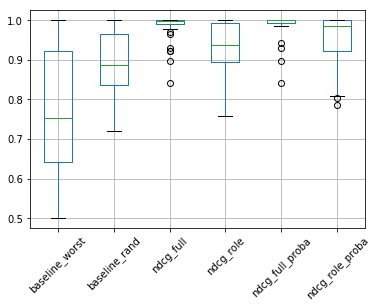

In [34]:
%matplotlib inline
pd.DataFrame(res)[['baseline_worst','baseline_rand','ndcg_full','ndcg_role','ndcg_full_proba','ndcg_role_proba']]\
    .boxplot(figsize=(5,8), rot=45)

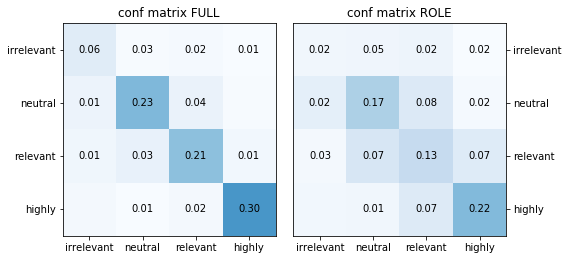

In [62]:
%matplotlib inline

from matplotlib import cm as colm
plt.figure(figsize=(8,5))
sub = plt.subplot(121)
normed = conf_matrix_full/conf_matrix_full.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
plt.title('conf matrix FULL')
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed[i][j]
        c='%.2f'%v if v>0.005 else ''
        sub.text(i, j, c, va='center', ha='center')



sub = plt.subplot(122)
normed = conf_matrix_role/conf_matrix_role.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
sub.yaxis.tick_right()
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed[i][j]
        c='%.2f'%v if v>0.01 else ''
        sub.text(i, j, c, va='center', ha='center')
        
plt.title('conf matrix ROLE')

plt.tight_layout()
plt.show()

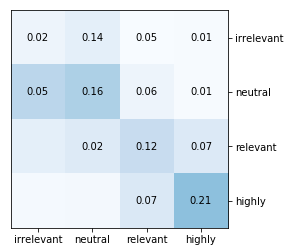

In [239]:
%matplotlib inline

from matplotlib import cm as colm

normed = conf_matrix_full/conf_matrix_full.sum()
normed = conf_matrix_role/conf_matrix_role.sum()

sub = plt.subplot(111)
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)

# uncomment for role matrix
sub.yaxis.tick_right()

sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed[i][j]
        c='%.2f'%v if v>0.005 else ''
        sub.text(i, j, c, va='center', ha='center')

#plt.tight_layout()
#plt.savefig(os.path.join('/home/tim/Uni/HPI/workspace/FEII/paper','conf_full.pdf'),bbox_inches='tight')
plt.savefig(os.path.join('/home/tim/Uni/HPI/workspace/FEII/paper','conf_role.pdf'),bbox_inches='tight')
plt.show()

## Neural Net

In [133]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2, activity_l2
from keras.utils import np_utils
from sklearn.multiclass import OneVsRestClassifier
import keras.optimizers as opts
from sklearn.preprocessing import LabelBinarizer


cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.1,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'loss': 'msle',
    'init': 'he_uniform',
    'inner_neurons': 200,
    'dropout': 0.1,
    'activation': 'softsign',
    'batch_size': 10,
    'weights': 'balanced',
    'n_epochs': 15
}

class NNClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, inner_neurons=20, init='he_uniform', dropout=0.1, 
                 regularisation=0.01, activation='softsign', batch_size=10,
                 loss='msle', weights='balanced', n_epochs=5):
        self.inner_neurons = inner_neurons
        self.dropout = dropout
        self.regularisation = regularisation
        self.activation = activation
        self.init = init
        self.batch_size = batch_size
        self.loss = loss
        self.n_epochs = n_epochs
        
        self.balanced = weights == 'balanced'
        
        
    def _prepareNet(self, n_inneurons, n_outneurons):
        try:
            getattr(self, "model")
            getattr(self, "labeler")
        except AttributeError:
            self.model = Sequential()
            self.model.add(Dense(output_dim=n_inneurons, input_dim=n_inneurons, init=self.init))
            self.model.add(Activation("linear"))

            self.model.add(Dense(self.inner_neurons, W_regularizer=l2(self.regularisation), init=self.init))
            self.model.add(Activation(self.activation))
            self.model.add(Dropout(self.dropout))

            self.model.add(Dense(n_outneurons, init=self.init))
            self.model.add(Activation("softmax"))

            #self.model.summary()

            self.model.compile(loss=self.loss,
                          optimizer=opts.Adadelta(),
                          metrics=['accuracy'])

            
    def fit(self, X, y=None):
        X = X.toarray()
        
        y = np.array(y)
        self.ys_ = list(set(y))
        Y = np.zeros((y.shape[0], 4))
        Y[np.arange(y.shape[0]), y] = 1
        
        print('X shape:', X.shape)
        print('Y shape:', Y.shape)
        
        self._prepareNet(X.shape[1], 4)
        
        if self.balanced:
            class_weights = dict((k, 1.0) for k in range(4))
            class_weights.update(dict((key, value) for key, value in zip(self.ys_, 
                                                                    compute_class_weight('balanced', self.ys_, y))))
            print('class weights are balanced:', class_weights)
        else:
            class_weights = None
        
        self.history_ = self.model.fit(X, Y, batch_size=self.batch_size, verbose=0,
                                       nb_epoch=self.n_epochs, class_weight=class_weights)
        return self
    
    
    def predict_proba(self, X, y=None):
        try:
            getattr(self, "history_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
            
        return self.model.predict_proba(X.toarray(), verbose=0)
        

# temporary storage for macro average score
scores_role = []
scores_full = []
scores_role_proba = []
scores_full_proba = []

conf_matrix_role = np.zeros((4,4))
conf_matrix_full = np.zeros((4,4))

# holer for stats
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
    'acc_role': [],
    'acc_full': []
}




#http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html#sphx-glr-auto-examples-hetero-feature-union-py
('union', FeatureUnion(
    transformer_list=[
        
    ])

 
 
 
 
 
 
# prepare model for full set over all roles classifying relevance
svmfullmodel = IDFscorer(frm=train[mask], train_size=0.7,
                         pipln=[
                             ('lem', Lemmatiser()),
                             ('vect', CountVectorizer(**cv_par)),
                             ('tfidf', TfidfTransformer(**tt_par)),
                             ('clf', NNClassifier(**clf_par))
                        ])
svmfullmodel.short_setinfo()
svmfullmodel.establish_baseline()
svmfullmodel.fit()

print(str(svmfullmodel.clf.named_steps['tfidf']._idf_diag.shape[0])+' features')

# run evaluation for each role
for role in roles.keys():
    print('=== '+role.upper()+' ======')
    
    svmmodel = IDFscorer(frm=train[mask], grp=role,train_size=0.7, 
                         pipln=[
                             ('vect', CountVectorizer(**cv_par)),
                             ('tfidf', TfidfTransformer(**tt_par)),
                             ('clf', NNClassifier(**clf_par))
                        ])
    svmmodel.short_setinfo()
    
    bl1, bl2 = svmmodel.establish_baseline(include_test=True, include_train=False)
    res['baseline_rand'].append(bl2)
    res['baseline_worst'].append(bl1)
    
    svmmodel.fit()
    print(str(svmmodel.clf.named_steps['tfidf']._idf_diag.shape[0])+' features')

    # get predictions from model trained on role
    pred_role, pred_proba_role = svmmodel.predict(svmmodel.testfrm)
    
    # get predictions from model trained on all
    pred_full, pred_proba_full = svmfullmodel.predict(svmmodel.testfrm)
    
    score_role = np.sum(pred_proba_role * np.array([1,2,3,4]), axis=1)
    score_full = np.sum(pred_proba_full * np.array([1,2,3,4]), axis=1)

    # calculate accuracy 
    testtarget = svmmodel.get_target()
    res['acc_role'].append(np.mean(pred_role == testtarget))
    print('Accuracy | role :', np.mean(pred_role == testtarget))
    res['acc_full'].append(np.mean(pred_full == testtarget))
    print('Accuracy | full :', np.mean(pred_full == testtarget))

    # print classification report
    print(metrics.classification_report(testtarget, pred_full,
                                        labels=[0,1,2,3],
                                        target_names=list(rating_map2.keys())))

    # print confusion matrix
    conf_matrix_role += np.array(metrics.confusion_matrix(testtarget, pred_role, labels=[0,1,2,3]))
    cm = metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3])
    conf_matrix_full += np.array(cm)
    print(cm)

    # add scores to full list
    score_role_tmp = list(zip(list(svmmodel.testfrm.index), pred_role))
    scores_role += score_role_tmp
    score_full_tmp = list(zip(list(svmmodel.testfrm.index), pred_full))
    scores_full += score_full_tmp
    
    # add scores based on probability to full list
    score_role_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_role))
    scores_role_proba += score_role_proba_tmp
    score_full_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_full))
    scores_full_proba += score_full_proba_tmp
    
    # add NDCG to results
    res['ndcg_role'].append(ndcg2(svmmodel.testfrm, score_role_tmp))
    res['ndcg_role_proba'].append(ndcg2(svmmodel.testfrm, score_role_proba_tmp))
    res['ndcg_full'].append(ndcg2(svmmodel.testfrm, score_full_tmp))
    res['ndcg_full_proba'].append(ndcg2(svmmodel.testfrm, score_full_proba_tmp))
    
    # echo results
    print('> NDCG Score | role | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_tmp)))
    print('> NDCG Score | role | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_proba_tmp)))
    print('> NDCG Score | full | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_tmp)))
    print('> NDCG Score | full | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_proba_tmp)))
    
    
# echo results of NDCG for entire set
print('TOTAL NDCG | role | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role]], scores_role)))
print('TOTAL NDCG | role | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role_proba]], scores_role_proba)))
print('TOTAL NDCG | full | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full]], scores_full)))
print('TOTAL NDCG | full | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full_proba]], scores_full_proba)))

Items in training set: 677
Items in testing set: 291
 = 968
Rating distribution in training set: Counter({'neutral': 214, 'highly': 205, 'relevant': 196, 'irrelevant': 62})
Rating distribution in testing set: Counter({'neutral': 92, 'highly': 88, 'relevant': 84, 'irrelevant': 27})
Rating distribution overall: Counter({'neutral': 306, 'highly': 293, 'relevant': 280, 'irrelevant': 89})
RATING_EXPERT_1 gave 406 ratings, in train: 281, in test: 125.
RATING_EXPERT_2 gave 366 ratings, in train: 257, in test: 109.
RATING_EXPERT_3 gave 60 ratings, in train: 45, in test: 15.
RATING_EXPERT_4 gave 35 ratings, in train: 24, in test: 11.
RATING_EXPERT_5 gave 80 ratings, in train: 46, in test: 34.
RATING_EXPERT_6 gave 60 ratings, in train: 36, in test: 24.
RATING_EXPERT_7 gave 74 ratings, in train: 48, in test: 26.
RATING_EXPERT_1.1 gave 222 ratings, in train: 156, in test: 66.
RATING_EXPERT_9 gave 73 ratings, in train: 54, in test: 19.
RATING_EXPERT_10 gave 20 ratings, in train: 15, in test: 5.
NDC

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 129
Items in testing set: 56
 = 185
Rating distribution in training set: Counter({'relevant': 43, 'highly': 40, 'neutral': 28, 'irrelevant': 18})
Rating distribution in testing set: Counter({'relevant': 18, 'highly': 18, 'neutral': 12, 'irrelevant': 8})
Rating distribution overall: Counter({'relevant': 61, 'highly': 58, 'neutral': 40, 'irrelevant': 26})
RATING_EXPERT_1 gave 81 ratings, in train: 54, in test: 27.
RATING_EXPERT_2 gave 63 ratings, in train: 42, in test: 21.
RATING_EXPERT_3 gave 19 ratings, in train: 13, in test: 6.
RATING_EXPERT_4 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_5 gave 25 ratings, in train: 16, in test: 9.
RATING_EXPERT_6 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_7 gave 19 ratings, in train: 14, in test: 5.
RATING_EXPERT_1.1 gave 56 ratings, in train: 40, in test: 16.
RATING_EXPERT_9 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_10 gave 12 ratings, in train: 9, in test: 3.
NDCG after 100x random order:


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 23
Items in testing set: 11
 = 34
Rating distribution in training set: Counter({'relevant': 15, 'highly': 5, 'neutral': 2, 'irrelevant': 1})
Rating distribution in testing set: Counter({'relevant': 7, 'highly': 3, 'neutral': 1})
Rating distribution overall: Counter({'relevant': 22, 'highly': 8, 'neutral': 3, 'irrelevant': 1})
RATING_EXPERT_1 gave 3 ratings, in train: 2, in test: 1.
RATING_EXPERT_2 gave 20 ratings, in train: 15, in test: 5.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 6, in test: 6.
RATING_EXPERT_7 gave 12 ratings, in train: 8, in test: 4.
RATING_EXPERT_1.1 gave 14 ratings, in train: 8, in test: 6.
NDCG after 100x random order:
 > mean ndcg = 0.900118736049 | std = 0.0400668136069
NDCG for worst case (inverted best) order:
 > ndcg = 0.818578583426
X shape: (23, 769)
Y shape: (23, 4)
class weights are balanced: {0: 5.75, 1: 2.875, 2: 0.38333333333333336, 3: 1.1499999999999999}
769 features
Accu

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 291
Items in testing set: 126
 = 417
Rating distribution in training set: Counter({'neutral': 114, 'highly': 108, 'relevant': 55, 'irrelevant': 14})
Rating distribution in testing set: Counter({'neutral': 49, 'highly': 47, 'relevant': 24, 'irrelevant': 6})
Rating distribution overall: Counter({'neutral': 163, 'highly': 155, 'relevant': 79, 'irrelevant': 20})
RATING_EXPERT_1 gave 177 ratings, in train: 121, in test: 56.
RATING_EXPERT_2 gave 145 ratings, in train: 110, in test: 35.
RATING_EXPERT_3 gave 19 ratings, in train: 13, in test: 6.
RATING_EXPERT_5 gave 9 ratings, in train: 3, in test: 6.
RATING_EXPERT_6 gave 25 ratings, in train: 17, in test: 8.
RATING_EXPERT_7 gave 25 ratings, in train: 17, in test: 8.
RATING_EXPERT_1.1 gave 81 ratings, in train: 54, in test: 27.
RATING_EXPERT_9 gave 50 ratings, in train: 36, in test: 14.
RATING_EXPERT_10 gave 3 ratings, in train: 0, in test: 3.
NDCG after 100x random order:
 > mean ndcg = 0.875537902238 | std = 0.02252850

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 42
Items in testing set: 19
 = 61
Rating distribution in training set: Counter({'neutral': 24, 'relevant': 12, 'highly': 4, 'irrelevant': 2})
Rating distribution in testing set: Counter({'neutral': 11, 'relevant': 6, 'highly': 1, 'irrelevant': 1})
Rating distribution overall: Counter({'neutral': 35, 'relevant': 18, 'highly': 5, 'irrelevant': 3})
RATING_EXPERT_1 gave 24 ratings, in train: 19, in test: 5.
RATING_EXPERT_2 gave 30 ratings, in train: 19, in test: 11.
RATING_EXPERT_3 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 5, in test: 1.
RATING_EXPERT_6 gave 3 ratings, in train: 1, in test: 2.
RATING_EXPERT_7 gave 6 ratings, in train: 4, in test: 2.
RATING_EXPERT_1.1 gave 10 ratings, in train: 6, in test: 4.
NDCG after 100x random order:
 > mean ndcg = 0.821801558032 | std = 0.0509318919407
NDCG for worst case (inverted best) order:
 > ndcg = 0.677867424114
X shape: (42,

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



RATING_EXPERT_5 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.964479894025 | std = 0.0296108639948
NDCG for worst case (inverted best) order:
 > ndcg = 0.931083193486
X shape: (14, 517)
Y shape: (14, 4)
class weights are balanced: {0: 1.0, 1: 4.666666666666667, 2: 0.51851851851851849, 3: 1.1666666666666667}
517 features
Accuracy | role : 0.666666666667
Accuracy | full : 0.5
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.75      0.60      0.67         5
     highly       0.00      0.00      0.00         1

avg / total       0.62      0.50      0.56         6

[[0 0 0 0]
 [0 0 0 0]
 [1 0 3

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [134]:
res['baseline_rand'] = np.mean(res['baseline_rand'], axis=1)
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.589923,0.622840,0.872608,0.743475,0.946352,0.956398,0.967813,0.971392
std,0.133807,0.169361,0.063819,0.130834,0.045810,0.046044,0.032479,0.038196
min,0.368421,0.368421,0.747196,0.528047,0.855099,0.862805,0.907530,0.887682
25%,0.504464,0.542239,0.837864,0.647909,0.936095,0.929300,0.945519,0.959562
50%,0.571429,0.601504,0.873303,0.730418,0.953706,0.971735,0.975114,0.986113
75%,0.712121,0.659091,0.919620,0.861078,0.982023,0.993736,0.997424,0.996968
max,0.777778,1.000000,0.964480,0.931083,1.000000,1.000000,1.000000,1.000000


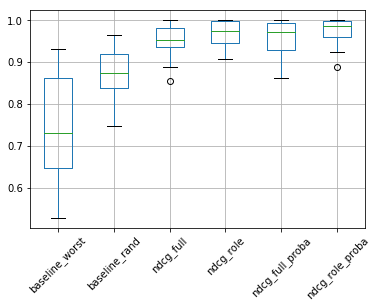

In [135]:
%matplotlib inline
pd.DataFrame(res)[['baseline_worst','baseline_rand','ndcg_full','ndcg_role','ndcg_full_proba','ndcg_role_proba']]\
    .boxplot(figsize=(5,8), rot=45)

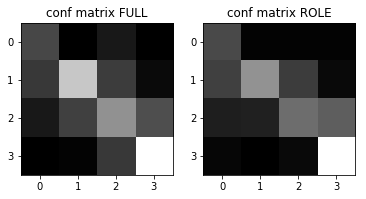

In [136]:
plt.subplot(121)
plt.imshow(conf_matrix_full/conf_matrix_full.max(), cmap='gray')
plt.title('conf matrix FULL')
plt.subplot(122)
plt.imshow(conf_matrix_role/conf_matrix_role.max(), cmap='gray')
plt.title('conf matrix ROLE')
plt.show()

In [138]:
m = svmfullmodel
w = m.clf.named_steps['clf'].model.get_weights()[2].sum(axis=1)
v = {i: w for w,i in m.clf.named_steps['vect'].vocabulary_.items()}
for wi in (w.max()-w).argsort()[:20]:
    print(v[wi],w[wi])

reference exhibit 0.210378
form 10 0.186122
trustee incorporate reference 0.180302
form 0.142248
incorporate reference 0.140631
repurchase 0.139662
january 0.139426
stanley 0.13683
august 0.131257
affiliate 0.128048
market 0.127107
security 0.126249
supplemental 0.114135
case 0.109747
december 0.108756
transaction 0.108363
10 0.106475
settlement 0.103358
amend 0.101792
bank new 0.100879


## Two class approach
Run the same experiment only classifying into relevant and irrelevant. Sorting score using confidence should be sufficient for a good NDCG. More training samples per class may improve overall results.

The NDCG is still calculated using four relevance levels.

In [51]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.03,
    'max_df': 0.9
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'loss': 'log', #['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
    'penalty': 'l2',
    'shuffle': True,
    'alpha': 1e-4,
    'n_iter': 15,
    'random_state': 42,
    'class_weight': 'balanced'
}

# temporary storage for macro average score
scores_role = []
scores_full = []
scores_role_proba = []
scores_full_proba = []

# holer for stats
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
    'acc_role': [],
    'acc_full': []
}



# prepare model for full set over all roles classifying relevance
svmfullmodel = IDFscorer(frm=train[mask], train_size=0.7, twoclassmode=True, 
                         pipln=[
                             ('vect', CountVectorizer(**cv_par)),
                             ('tfidf', TfidfTransformer(**tt_par)),
                             ('clf', SGDClassifier(**clf_par))
                        ])
svmfullmodel.short_setinfo()
svmfullmodel.establish_baseline()
svmfullmodel.fit()

# run evaluation for each role
for role in roles.keys():
    print('\n=== '+role.upper()+' ======')
    
    svmmodel = IDFscorer(frm=train[mask], grp=role,train_size=0.7, twoclassmode=True, 
                         pipln=[
                             ('vect', CountVectorizer(**cv_par)),
                             ('tfidf', TfidfTransformer(**tt_par)),
                             ('clf', SGDClassifier(**clf_par))
                        ])
    svmmodel.short_setinfo()
    
    # establish a baseline score
    bl1, bl2 = svmmodel.establish_baseline(include_test=True, include_train=False)
    res['baseline_rand'].append(bl2)
    res['baseline_worst'].append(bl1)
    
    testtarget = svmmodel.get_target()
    
    try:
        # fit the role based model
        svmmodel.fit()
        
        # get predictions from model trained on role
        pred_role, pred_proba_role = svmmodel.predict(svmmodel.testfrm)
        score_role = np.sum(pred_proba_role * np.array([1,2]), axis=1)
        
        res['acc_role'].append(np.mean(pred_role == testtarget))
        print('Accuracy | role :', np.mean(pred_role == testtarget))
        
        score_role_tmp = list(zip(list(svmmodel.testfrm.index), pred_role))
        scores_role += score_role_tmp
        
        score_role_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_role))
        scores_role_proba += score_role_proba_tmp
        
        res['ndcg_role'].append(ndcg2(svmmodel.testfrm, score_role_tmp))
        res['ndcg_role_proba'].append(ndcg2(svmmodel.testfrm, score_role_proba_tmp))
        
        print('> NDCG Score | role | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_tmp)))
        print('> NDCG Score | role | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_proba_tmp)))
    except ValueError as e:
        print("ERROR",e)
        print("excluding this from results")
        
        res['ndcg_role'].append(np.nan)
        res['ndcg_role_proba'].append(np.nan)
        res['acc_role'].append(np.nan)
        # scores_role
        # scores_role_proba
        

    # get predictions from model trained on all
    pred_full, pred_proba_full = svmfullmodel.predict(svmmodel.testfrm)
    score_full = np.sum(pred_proba_full * np.array([1,2]), axis=1)

    # calculate accuracy 
    res['acc_full'].append(np.mean(pred_full == testtarget))
    print('Accuracy | full :', np.mean(pred_full == testtarget))

    # add scores to full list
    score_full_tmp = list(zip(list(svmmodel.testfrm.index), pred_full))
    scores_full += score_full_tmp
    
    # add scores based on probability to full list
    score_full_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_full))
    scores_full_proba += score_full_proba_tmp
    
    # add NDCG to results
    res['ndcg_full'].append(ndcg2(svmmodel.testfrm, score_full_tmp))
    res['ndcg_full_proba'].append(ndcg2(svmmodel.testfrm, score_full_proba_tmp))
    
    # echo results
    print('> NDCG Score | full | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_tmp)))
    print('> NDCG Score | full | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_proba_tmp)))
    
    # print classification report
    print(metrics.classification_report(testtarget, pred_full,
                                        labels=[0,1],
                                        target_names=list(svmmodel.ratingmap.keys())))

    # print confusion matrix
    print(metrics.confusion_matrix(testtarget, pred_full, labels=[0,1]))
    

print('\n==== MACROAVERAGE ====')
# echo results of NDCG for entire set
print('TOTAL NDCG | role | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role]], scores_role)))
print('TOTAL NDCG | role | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role_proba]], scores_role_proba)))
print('TOTAL NDCG | full | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full]], scores_full)))
print('TOTAL NDCG | full | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full_proba]], scores_full_proba)))

Items in training set: 677
Items in testing set: 291
 = 968
Rating distribution in training set: Counter({'relevant': 401, 'irrelevant': 276})
Rating distribution in testing set: Counter({'relevant': 172, 'irrelevant': 119})
Rating distribution overall: Counter({'relevant': 573, 'irrelevant': 395})
RATING_EXPERT_1 gave 406 ratings, in train: 273, in test: 133.
RATING_EXPERT_2 gave 366 ratings, in train: 268, in test: 98.
RATING_EXPERT_3 gave 60 ratings, in train: 38, in test: 22.
RATING_EXPERT_4 gave 35 ratings, in train: 23, in test: 12.
RATING_EXPERT_5 gave 80 ratings, in train: 53, in test: 27.
RATING_EXPERT_6 gave 60 ratings, in train: 43, in test: 17.
RATING_EXPERT_7 gave 74 ratings, in train: 59, in test: 15.
RATING_EXPERT_1.1 gave 222 ratings, in train: 150, in test: 72.
RATING_EXPERT_9 gave 73 ratings, in train: 52, in test: 21.
RATING_EXPERT_10 gave 20 ratings, in train: 17, in test: 3.
NDCG after 100x random order:
 > mean ndcg = 0.888243605959 | std = 0.0156921845508
NDCG fo

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 14
Items in testing set: 6
 = 20
Rating distribution in training set: Counter({'relevant': 13, 'irrelevant': 1})
Rating distribution in testing set: Counter({'relevant': 6})
Rating distribution overall: Counter({'relevant': 19, 'irrelevant': 1})
RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 14 ratings, in train: 9, in test: 5.
RATING_EXPERT_5 gave 4 ratings, in train: 2, in test: 2.
RATING_EXPERT_6 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.931788004216 | std = 0.0347172787239
NDCG for worst case (inverted best) order:
 > ndcg = 0.942474674616
Accuracy | role : 0.833333333333
> NDCG Score | role | categ  | 0.94948
> NDCG Score | role | proba* | 1.00000
Accuracy | full : 1.0
> NDCG Score | full | categ  | 0.94247
> NDC

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [52]:
res['baseline_rand'] = np.mean(res['baseline_rand'], axis=1)
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,9.000000,10.000000,10.000000,10.000000,10.000000,9.000000,9.000000
mean,0.925516,0.839858,0.870386,0.780387,0.942923,0.959465,0.924677,0.952402
std,0.098054,0.132073,0.056983,0.103468,0.025427,0.042242,0.028386,0.042649
min,0.714286,0.631579,0.754495,0.603305,0.904531,0.881926,0.883767,0.895391
25%,0.924451,0.789474,0.839578,0.716735,0.923889,0.946187,0.911221,0.908740
50%,0.949875,0.833333,0.881213,0.766932,0.943167,0.971572,0.920456,0.964293
75%,1.000000,0.944444,0.914117,0.848359,0.957552,0.991395,0.949479,0.986537
max,1.000000,1.000000,0.931788,0.942475,0.990980,1.000000,0.958222,1.000000


In [49]:
ndcg_np(np.array([0,0,0,0,1,1,1,1]), np.array([1,1,1,1,0,0,0,0]), p=8)

0.48134899354741911

### Classifier internals

In [55]:
pl = svmfullmodel.clf
print('coef shape:', pl.steps[2][1].coef_.shape)
invdict = {i: w for w,i in pl.steps[0][1].vocabulary_.items()}
for role, vec in enumerate(pl.steps[2][1].coef_):
    print()
    print(['irrelevant','neutral', 'relev', 'highly'][role].upper())
    for i, j in zip((-vec).argsort()[:20], vec.argsort()[:20]):
        print("coef: {:.3f}, idf: {:.3f}, word: {:<20} | coef: {:.3f}, idf: {:.3f}, word: {}".format(vec[i], pl.steps[1][1].idf_[i], invdict[i],
                                                                                       vec[j], pl.steps[1][1].idf_[j], invdict[j]))

coef shape: (1, 624)

IRRELEVANT
coef: 4.000, idf: 3.530, word: purchase             | coef: -4.934, idf: 3.830, word: individual
coef: 3.935, idf: 4.341, word: purpose              | coef: -4.459, idf: 4.187, word: thereto
coef: 3.824, idf: 3.360, word: guarantee            | coef: -4.064, idf: 4.384, word: director
coef: 3.719, idf: 3.442, word: loss                 | coef: -3.737, idf: 3.882, word: item
coef: 3.686, idf: 3.830, word: sponsor              | coef: -3.463, idf: 3.549, word: bancorp
coef: 3.573, idf: 3.512, word: payment              | coef: -3.328, idf: 3.648, word: base
coef: 3.547, idf: 2.659, word: capital              | coef: -3.224, idf: 3.549, word: service
coef: 3.496, idf: 3.712, word: investor             | coef: -3.174, idf: 3.830, word: general
coef: 3.491, idf: 4.300, word: seller               | coef: -2.920, idf: 4.187, word: reserve
coef: 3.482, idf: 4.223, word: share                | coef: -2.907, idf: 3.459, word: citigroup
coef: 3.362, idf: 4.300, wo

In [12]:
out = '<ul>'
for a, b in train[mask][10:30].iterrows(): #&(train['rating']=='highly')
    out +='<li>' + b['rating'] + ' | ' + b['THREE_SENTENCES'] \
        .replace(b['MENTIONED_FINANCIAL_ENTITY'],'<b><u>'+b['MENTIONED_FINANCIAL_ENTITY']+'</u></b>') \
        .replace(b['ROLE'],'<b>'+b['ROLE']+'</b>')+'</li>'
    
out += '</ul>'

import IPython.display as dp
dp.display_html(out, raw=True)

highly | As of the same date, we also provided approximately $8.75 billion of credit and liquidity facilities to municipal issuers. TABLE 23: STATE AND MUNICIPAL OBLIGORS (1) (Dollars in millions) Total Municipal Securities Credit and Liquidity Facilities (2) Total % of Total Municipal Exposure December 31, 2015 State of Issuer : Texas $ 1,250 $ 1,962 $ 3,212 17 % California 444 2,220 2,664 14 New York 817 1,259 2,076 11 Massachusetts 927 731 1,658 9 Maryland 454 413 867 5 Total $ 3,892 $ 6,585 $ 10,477 December 31, 2014 State of Issuer : Texas $ 1,326 $ 1,405 $ 2,731 15 % California 458 1,837 2,295 12 New York 920 996 1,916 10 Massachusetts 989 847 1,836 10 Maryland 446 416 862 5 Total $ 4,139 $ 5,501 $ 9,640 (1) Represented 5% or more of our aggregate municipal credit exposure of approximately $18.50 billion and $18.44 billion across our businesses as of December 31, 2015 and December 31, 2014 , respectively. (2) Includes municipal loans which are also presented within Table 26 . highly | As of the same date, we also provided approximately $8.75 billion of credit and liquidity facilities to municipal issuers. TABLE 23: STATE AND MUNICIPAL OBLIGORS (1) (Dollars in millions) Total Municipal Securities Credit and Liquidity Facilities (2) Total % of Total Municipal Exposure December 31, 2015 State of Issuer : Texas $ 1,250 $ 1,962 $ 3,212 17 % California 444 2,220 2,664 14 New York 817 1,259 2,076 11 Massachusetts 927 731 1,658 9 Maryland 454 413 867 5 Total $ 3,892 $ 6,585 $ 10,477 December 31, 2014 State of Issuer : Texas $ 1,326 $ 1,405 $ 2,731 15 % California 458 1,837 2,295 12 New York 920 996 1,916 10 Massachusetts 989 847 1,836 10 Maryland 446 416 862 5 Total $ 4,139 $ 5,501 $ 9,640 (1) Represented 5% or more of our aggregate municipal credit exposure of approximately $18.50 billion and $18.44 billion across our businesses as of December 31, 2015 and December 31, 2014 , respectively. (2) Includes municipal loans which are also presented within Table 26 . highly | As of December 31, 2015 and December 31, 2014 , unearned income deducted from our investment in leveraged lease financing was $102 million and $109 million , respectively, for U.S. leases and $231 million and $261 million , respectively, for non-U.S. leases. The CRE loans are composed of the loans acquired in 2008 pursuant to indemnified repurchase agreements with an affiliate of Lehman as a result of the Lehman Brothers bankruptcy. Additional information about all of our loan-and-lease segments, as well as underlying classes, is provided in Note 4 to the consolidated financial statements included under Item 8 of this Form 10-K. No loans, including CRE loans, were modified in troubled debt restructurings in 2015 or in 2014 . relevant | In addition to credit risk, cross-border outstandings have the risk that, as a result of political or economic conditions in a country, borrowers may be unable to meet their contractual repayment obligations of principal and/or interest when due because of the unavailability of, or restrictions on, foreign exchange needed by borrowers to repay their obligations. We place deposits with non-U.S. counterparties that have strong internal State Street risk ratings. Counterparties are approved and monitored by our Country Risk Committee. relevant | Credit limit approvals across State Street are undertaken by the Credit Risk group, by individuals to whom credit authority has been delegated, or by the Credit Committee. Credit limits are re-evaluated annually, or more frequently as needed, and are revised periodically on prevailing and anticipated market conditions, changes in counterparty or country-specific credit ratings and outlook, changes in State Street 's risk appetite for certain counterparties, sectors or countries, and enhancements to the measurement of credit utilization. Reporting Ongoing active monitoring and management of our credit risk is an integral part of our credit risk management framework. relevant | The watch list is

## LDA

In [114]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

cv_par = {
    #'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
clf_par = {
    'n_topics': 4, 
    'max_iter': 5,
    'learning_method': 'online',
    'learning_offset': 50.,
    'random_state': 0
}

# temporary storage for macro average score
scores_role = []
scores_full = []
scores_role_proba = []
scores_full_proba = []

# holer for stats
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
    'acc_role': [],
    'acc_full': []
}

def print_top_words(model, feature_names, n_top_words, y, yp):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print(sorted(list(zip(Counter(yp[y==topic_idx]).keys(),
                              np.array(list(Counter(yp[y==topic_idx]).values()))/ \
                              np.sum(list(Counter(yp[y==topic_idx]).values()))))))


# prepare model for full set over all roles classifying relevance
svmfullmodel = IDFscorer(frm=train[mask], train_size=0.7, twoclassmode=False, 
                         pipln=[
                            ('vect', CountVectorizer(**cv_par)),
                            ('clf', LatentDirichletAllocation(**clf_par))
                        ])
svmfullmodel.short_setinfo()
svmfullmodel.establish_baseline()
svmfullmodel.fit()

# run evaluation for each role
for role in roles.keys():
    print('\n=== '+role.upper()+' ======')
    
    svmmodel = IDFscorer(frm=train[mask], grp=role,train_size=0.7, twoclassmode=False, 
                         pipln=[
                            ('vect', CountVectorizer(**cv_par)),
                            ('clf', LatentDirichletAllocation(**clf_par))
                        ])
    svmmodel.short_setinfo()
    
    # establish a baseline score
    bl1, bl2 = svmmodel.establish_baseline(include_test=True, include_train=False)
    res['baseline_rand'].append(bl2)
    res['baseline_worst'].append(bl1)
    
    testtarget = svmmodel.get_target()
    

    try:
        # fit the role based model
        svmmodel.fit()
        
        # get predictions from model trained on role
        pred_role, pred_proba_role = svmmodel.transform(svmmodel.testfrm)
        score_role = np.sum(pred_proba_role * np.array([1,2,3,4]), axis=1)
        
        res['acc_role'].append(np.mean(pred_role == testtarget))
        print('Accuracy | role :', np.mean(pred_role == testtarget))
        
        score_role_tmp = list(zip(list(svmmodel.testfrm.index), pred_role))
        scores_role += score_role_tmp
        
        score_role_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_role))
        scores_role_proba += score_role_proba_tmp
        
        res['ndcg_role'].append(ndcg2(svmmodel.testfrm, score_role_tmp))
        res['ndcg_role_proba'].append(ndcg2(svmmodel.testfrm, score_role_proba_tmp))
        
        print('> NDCG Score | role | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_tmp)))
        print('> NDCG Score | role | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_proba_tmp)))
    except ValueError as e:
        print("ERROR",e)
        print("excluding this from results")
        
        res['ndcg_role'].append(np.nan)
        res['ndcg_role_proba'].append(np.nan)
        res['acc_role'].append(np.nan)
        # scores_role
        # scores_role_proba
        

    # get predictions from model trained on all
    pred_full, pred_proba_full = svmfullmodel.transform(svmmodel.testfrm)
    score_full = np.sum(pred_proba_full * np.array([1,2,3,4]), axis=1)
    
    # calculate accuracy 
    res['acc_full'].append(np.mean(pred_full == testtarget))
    print('Accuracy | full :', np.mean(pred_full == testtarget))

    # add scores to full list
    score_full_tmp = list(zip(list(svmmodel.testfrm.index), pred_full))
    scores_full += score_full_tmp
    
    # add scores based on probability to full list
    score_full_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_full))
    scores_full_proba += score_full_proba_tmp
    
    # add NDCG to results
    res['ndcg_full'].append(ndcg2(svmmodel.testfrm, score_full_tmp))
    res['ndcg_full_proba'].append(ndcg2(svmmodel.testfrm, score_full_proba_tmp))
    
    # echo results
    print('> NDCG Score | full | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_tmp)))
    print('> NDCG Score | full | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_proba_tmp)))
    
    # print classification report
    print(metrics.classification_report(testtarget, pred_full,
                                        labels=[0,1,2,3],
                                        target_names=list(svmmodel.ratingmap.keys())))

    # print confusion matrix
    print(metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3]))
    
    tf_feature_names = svmmodel.clf.named_steps['vect'].get_feature_names()
    print_top_words(svmmodel.clf.named_steps['clf'], tf_feature_names, 15, testtarget, pred_full)
    
print('\n==== MACROAVERAGE ====')
# echo results of NDCG for entire set
print('TOTAL NDCG | role | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role]], scores_role)))
print('TOTAL NDCG | role | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_role_proba]], scores_role_proba)))
print('TOTAL NDCG | full | categ  | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full]], scores_full)))
print('TOTAL NDCG | full | proba* | {:.5f}'.format(ndcg2(train.loc[[k for k,v in scores_full_proba]], scores_full_proba)))

Items in training set: 677
Items in testing set: 291
 = 968
Rating distribution in training set: Counter({'neutral': 214, 'highly': 205, 'relevant': 196, 'irrelevant': 62})
Rating distribution in testing set: Counter({'neutral': 92, 'highly': 88, 'relevant': 84, 'irrelevant': 27})
Rating distribution overall: Counter({'neutral': 306, 'highly': 293, 'relevant': 280, 'irrelevant': 89})
RATING_EXPERT_1 gave 406 ratings, in train: 283, in test: 123.
RATING_EXPERT_2 gave 366 ratings, in train: 260, in test: 106.
RATING_EXPERT_3 gave 60 ratings, in train: 44, in test: 16.
RATING_EXPERT_4 gave 35 ratings, in train: 22, in test: 13.
RATING_EXPERT_5 gave 80 ratings, in train: 55, in test: 25.
RATING_EXPERT_6 gave 60 ratings, in train: 36, in test: 24.
RATING_EXPERT_7 gave 74 ratings, in train: 56, in test: 18.
RATING_EXPERT_1.1 gave 222 ratings, in train: 159, in test: 63.
RATING_EXPERT_9 gave 73 ratings, in train: 53, in test: 20.
RATING_EXPERT_10 gave 20 ratings, in train: 14, in test: 6.
NDC

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 129
Items in testing set: 56
 = 185
Rating distribution in training set: Counter({'relevant': 43, 'highly': 40, 'neutral': 28, 'irrelevant': 18})
Rating distribution in testing set: Counter({'highly': 18, 'relevant': 18, 'neutral': 12, 'irrelevant': 8})
Rating distribution overall: Counter({'relevant': 61, 'highly': 58, 'neutral': 40, 'irrelevant': 26})
RATING_EXPERT_1 gave 81 ratings, in train: 54, in test: 27.
RATING_EXPERT_2 gave 63 ratings, in train: 48, in test: 15.
RATING_EXPERT_3 gave 19 ratings, in train: 13, in test: 6.
RATING_EXPERT_4 gave 8 ratings, in train: 3, in test: 5.
RATING_EXPERT_5 gave 25 ratings, in train: 14, in test: 11.
RATING_EXPERT_6 gave 14 ratings, in train: 9, in test: 5.
RATING_EXPERT_7 gave 19 ratings, in train: 18, in test: 1.
RATING_EXPERT_1.1 gave 56 ratings, in train: 39, in test: 17.
RATING_EXPERT_9 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_10 gave 12 ratings, in train: 11, in test: 1.
NDCG after 100x random order:

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 23
Items in testing set: 11
 = 34
Rating distribution in training set: Counter({'relevant': 14, 'highly': 6, 'neutral': 2, 'irrelevant': 1})
Rating distribution in testing set: Counter({'relevant': 8, 'highly': 2, 'neutral': 1})
Rating distribution overall: Counter({'relevant': 22, 'highly': 8, 'neutral': 3, 'irrelevant': 1})
RATING_EXPERT_1 gave 3 ratings, in train: 1, in test: 2.
RATING_EXPERT_2 gave 20 ratings, in train: 13, in test: 7.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 8, in test: 4.
RATING_EXPERT_7 gave 12 ratings, in train: 9, in test: 3.
RATING_EXPERT_1.1 gave 14 ratings, in train: 10, in test: 4.
NDCG after 100x random order:
 > mean ndcg = 0.909520077452 | std = 0.0354052186371
NDCG for worst case (inverted best) order:
 > ndcg = 0.834284151592
Accuracy | role : 0.454545454545
> NDCG Score | role | categ  | 0.90428
> NDCG Score | role | proba* | 0.89349
Accuracy | full : 0.636363636364
> N

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Topic #0:
net income loss expense cash revenue asset loan total intercompany sale lease debt financing investment
[]
Topic #1:
basis company guarantee senior llc note statement adjustment consolidated fully nonguarantors intercompany holding condensed include
[(1, 1.0)]
Topic #2:
net income loan loss total cash expense intercompany revenue asset nonbank receivables debt sale investment
[(2, 0.75), (3, 0.25)]
Topic #3:
file form company guarantee reference incorporate exhibit capital bank corporation warrant specimen january trustee agreement
[(2, 1.0)]

=== TRUSTEE ======
Items in training set: 291
Items in testing set: 126
 = 417
Rating distribution in training set: Counter({'neutral': 114, 'highly': 108, 'relevant': 55, 'irrelevant': 14})
Rating distribution in testing set: Counter({'neutral': 49, 'highly': 47, 'relevant': 24, 'irrelevant': 6})
Rating distribution overall: Counter({'neutral': 163, 'highly': 155, 'relevant': 79, 'irrelevant': 20})
RATING_EXPERT_1 gave 177 ratings, in 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 42
Items in testing set: 19
 = 61
Rating distribution in training set: Counter({'neutral': 24, 'relevant': 12, 'highly': 4, 'irrelevant': 2})
Rating distribution in testing set: Counter({'neutral': 11, 'relevant': 6, 'highly': 1, 'irrelevant': 1})
Rating distribution overall: Counter({'neutral': 35, 'relevant': 18, 'highly': 5, 'irrelevant': 3})
RATING_EXPERT_1 gave 24 ratings, in train: 17, in test: 7.
RATING_EXPERT_2 gave 30 ratings, in train: 23, in test: 7.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_5 gave 6 ratings, in train: 4, in test: 2.
RATING_EXPERT_6 gave 3 ratings, in train: 2, in test: 1.
RATING_EXPERT_7 gave 6 ratings, in train: 4, in test: 2.
RATING_EXPERT_1.1 gave 10 ratings, in train: 6, in test: 4.
NDCG after 100x random order:
 > mean ndcg = 0.826600658098 | std = 0.0577965583626
NDCG for worst case (inverted best) order:
 > ndcg = 0.677867424114
Accuracy | rol

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 14
Items in testing set: 6
 = 20
Rating distribution in training set: Counter({'relevant': 10, 'highly': 3, 'neutral': 1})
Rating distribution in testing set: Counter({'relevant': 4, 'highly': 2})
Rating distribution overall: Counter({'relevant': 14, 'highly': 5, 'neutral': 1})
RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 9, in test: 5.
RATING_EXPERT_5 gave 4 ratings, in train: 2, in test: 2.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.932726001515 | std = 0.0285476099592
NDCG for worst case (inverted best) order:
 > ndcg = 0.880521329339
Accuracy | role : 0.5
> NDCG Score | role | categ  | 0.88753
> NDCG Score | role | proba* | 0.88052
Accuracy | full : 0.5
> NDCG Score | full | 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [84]:
res['baseline_rand'] = np.mean(res['baseline_rand'], axis=1)
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.087825,0.283391,0.870886,0.736003,0.855298,0.828324,0.855496,0.866348
std,0.091437,0.173177,0.065207,0.128672,0.089038,0.105414,0.078149,0.083833
min,0.000000,0.105263,0.742514,0.528047,0.688681,0.687760,0.748046,0.775913
25%,0.013158,0.172932,0.830855,0.647909,0.801157,0.751340,0.791339,0.791895
50%,0.064777,0.270292,0.879604,0.729511,0.895335,0.821584,0.860361,0.857195
75%,0.141775,0.320513,0.914287,0.844973,0.926200,0.921486,0.884818,0.927756
max,0.285714,0.714286,0.962173,0.931083,0.939754,0.986302,1.000000,1.000000


In [112]:
a, b = svmfullmodel.transform(svmfullmodel.trainfrm)
y = svmfullmodel.trainfrm['rating'].map(svmfullmodel.ratingmap)
for i in range(4):
    print(i, sorted(list(zip(Counter(a[y==i]).keys(),np.array(list(Counter(a[y==i]).values()))/np.sum(list(Counter(a[y==i]).values()))))))

0 [(0, 0.30645161290322581), (1, 0.016129032258064516), (2, 0.032258064516129031), (3, 0.64516129032258063)]
1 [(0, 0.35046728971962615), (1, 0.34112149532710279), (2, 0.051401869158878503), (3, 0.2570093457943925)]
2 [(0, 0.18877551020408162), (1, 0.1326530612244898), (2, 0.26530612244897961), (3, 0.41326530612244899)]
3 [(1, 0.014634146341463415), (2, 0.80487804878048785), (3, 0.18048780487804877)]


## TF.IDF (Baseline)
* Calculate sorting scores using normalised IDF score (Sum of IDFs of each valid token in text divided by number of tokens in text).
 * alternatively normalise dividing by number of tokens (as opposed to only number of valid tokens)
* IDF calculated across texts with same relevance and role ("document" equivalent to all texts with same relevance and role)
* another index is constructed disregarding the role for comparison ("document" equivalent to all texts with same relevance)
* another index is only constructed disregarding both, relevance and role (normal IDF over documents)

In [20]:
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'scr_doc_all': [],
    'scr_doc_valid': [],
    'scr_doc_min_tf': [],
    'scr_rat_all': [],
    'scr_rat_valid': [],
    'scr_rat_min_tf': [],
    'scr_doc_min_tf_full': [],
    'scr_rat_min_tf_full': []
}
all_scores = []

fullidfsort = IDFscorer(train[mask], train_size=0.8)
fullidfsort.short_setinfo()

for role in roles.keys():
    print('===> '+role.upper()+" <==========")
    idfsort = IDFscorer(train[mask], role, train_size=0.8)
    idfsort.short_setinfo()
    print("=> BASELINE _____")
    bl1, bl2 = idfsort.establish_baseline(include_test=True, include_train=False)
    res['baseline_rand'] += bl2
    res['baseline_worst'].append(bl1)
    print("=> SCORING normalise by all _____")
    d,r, _ = idfsort.idf_rank_score(norm_all=True)
    res['scr_doc_all'].append(d)
    res['scr_rat_all'].append(r)
    print("=> SCORING normalise by valid ______")
    d,r, _ = idfsort.idf_rank_score(norm_all=False)
    res['scr_doc_valid'].append(d)
    res['scr_rat_valid'].append(r)
    d,r, s = idfsort.idf_rank_score(norm_all=False, min_tf=2)
    res['scr_doc_min_tf'].append(d)
    res['scr_rat_min_tf'].append(r)
    all_scores += s
    
    print("=> SCORING from full set ______")
    d,r,_ = fullidfsort.idf_rank_score(grp=role, min_tf=2)
    res['scr_doc_min_tf_full'].append(d)
    res['scr_rat_min_tf_full'].append(r)
    
print('\nTRAINED per role')
tmp = ndcg2(frame=train.loc[[k for k,v in all_scores]], scoring=all_scores)
print('Overall NDCG: '+str(tmp))
tmp = ndcg2(frame=train.loc[[k for k,v in all_scores]], 
    scoring=[(k,v) for k,v in abs(train.loc[[k for k,v in all_scores]]['rating'].map(rating_map2)-3).iteritems()])
print('worst case overall ndcg: '+str(tmp))

print('\nTRAINED TOGETHER')
d,r,s= fullidfsort.idf_rank_score(min_tf=2)
tmp = ndcg2(frame=fullidfsort.testfrm, scoring=s)
print('Overall NDCG: '+str(tmp))
tmp = ndcg2(frame=fullidfsort.testfrm, 
    scoring=[(k,v) for k,v in abs(fullidfsort.testfrm['rating'].map(rating_map2)-3).iteritems()])
print('worst case overall ndcg: '+str(tmp))

Items in training set: 774
Items in testing set: 194
 = 968
Rating distribution in training set: Counter({'neutral': 245, 'highly': 234, 'relevant': 224, 'irrelevant': 71})
Rating distribution in testing set: Counter({'neutral': 61, 'highly': 59, 'relevant': 56, 'irrelevant': 18})
Rating distribution overall: Counter({'neutral': 306, 'highly': 293, 'relevant': 280, 'irrelevant': 89})
RATING_EXPERT_1 gave 406 ratings, in train: 318, in test: 88.
RATING_EXPERT_2 gave 366 ratings, in train: 297, in test: 69.
RATING_EXPERT_3 gave 60 ratings, in train: 47, in test: 13.
RATING_EXPERT_4 gave 35 ratings, in train: 27, in test: 8.
RATING_EXPERT_5 gave 80 ratings, in train: 62, in test: 18.
RATING_EXPERT_6 gave 60 ratings, in train: 50, in test: 10.
RATING_EXPERT_7 gave 74 ratings, in train: 61, in test: 13.
RATING_EXPERT_1.1 gave 222 ratings, in train: 177, in test: 45.
RATING_EXPERT_9 gave 73 ratings, in train: 59, in test: 14.
RATING_EXPERT_10 gave 20 ratings, in train: 16, in test: 4.
===> I

In [21]:
res['baseline_rand'] = np.mean(res['baseline_rand'])
pd.DataFrame(res).describe()

,baseline_rand,baseline_worst,scr_doc_all,scr_doc_min_tf,scr_doc_min_tf_full,scr_doc_valid,scr_rat_all,scr_rat_min_tf,scr_rat_min_tf_full,scr_rat_valid
count,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,8.749960e-01,0.745947,0.871012,0.871012,0.909651,0.871012,0.871012,0.871012,0.909651,0.871012
std,1.170278e-16,0.147528,0.104597,0.104597,0.067187,0.104597,0.104597,0.104597,0.067187,0.104597
min,8.749960e-01,0.498838,0.648238,0.648238,0.796830,0.648238,0.648238,0.648238,0.796830,0.648238
25%,8.749960e-01,0.658240,0.829844,0.829844,0.871123,0.829844,0.829844,0.829844,0.871123,0.829844
50%,8.749960e-01,0.717779,0.910867,0.910867,0.903175,0.910867,0.910867,0.910867,0.903175,0.910867
75%,8.749960e-01,0.865748,0.938578,0.938578,0.953219,0.938578,0.938578,0.938578,0.953219,0.938578
max,8.749960e-01,0.943775,0.985277,0.985277,1.000000,0.985277,0.985277,0.985277,1.000000,0.985277


## Syntax features only

In [8]:
# from sklearn.linear_model import SGDClassifier
import re
from multiprocessing import Pool
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

clf_par = {
    'loss': 'log', #['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
    'penalty': 'l2',
    'shuffle': True,
    'alpha': 1e-4,
    'n_iter': 15,
    'random_state': 42,
    'class_weight': 'balanced'
}
rf_par = {
    'n_estimators': 20,
    'criterion': 'gini', #gini or entropy
    'max_features': 'auto', #int, float, auto, sqrt, log2, None
    
    'random_state': 42,
    'class_weight': 'balanced'
}

conf_matrix_role = np.zeros((4,4))
conf_matrix_full = np.zeros((4,4))

# holer for stats
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
    'acc_role': [],
    'acc_full': [],
    'f1_role': [],
    'f1_full': []
}
macro_res = {
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
}

class SyntaxFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, asfrm=False, n_workers=6):
        self.asfrm = asfrm
        self.n_workers = n_workers
        
    def fit(self, X, y=None):
        return self

    def transform(self, frm):
        p = Pool(self.n_workers)
        Xd = pd.DataFrame(p.map(self._features, frm.iterrows()), index=frm.index)
        p.close()
        
        self.features_ = list(Xd.columns)
        
        if (self.asfrm):
            return Xd
        
        return Xd.as_matrix()
    
    def _features(self, row):
        _, row = row
        raw = row['THREE_SENTENCES']
        clean = row['clean']
        counts_r = Counter(raw.split())
        counts_c = Counter(clean.split())
        ret = {
            'num_chars': len(raw),
            'num_words': len(raw.split()),
            'num_upper_chars': sum(1 for c in raw if c.isupper()),
            'num_upper_words': sum(1 for w in raw.split() if w[0].isupper()),
            'ratio_upper_chars': sum(1 for c in raw if c.isupper())/len(raw),
            'ratio_upper_words': sum(1 for w in raw.split() if w[0].isupper())/len(raw.split()),
            'mean_word_len': np.mean([len(w) for w in raw.split()]),
            'num_word_repetitions_raw': len({k:v for k,v in counts_r.items() if v>1}),
            'num_word_repetitions_clean': len({k:v for k,v in counts_c.items() if v>1}),
            'ratio_word_repetitions_raw': len({k:v for k,v in counts_r.items() if v>1})/len(raw.split()),
            'ratio_word_repetitions_clean': len({k:v for k,v in counts_c.items() if v>1})/len(clean.split()),
            'num_dollarsigns': len(raw)-len(raw.replace('$','')),
            'num_numbers': len(re.findall(r'\d+', raw)),
            'num_digits': len(re.findall(r'\d', raw)),
            'ratio_numbers': len(re.findall(r'\d+', raw))/len(raw.split()),
            'ratio_digits': len(re.findall(r'\d', raw))/len(raw),
        }
        return ret

def pipln():
    return [
        ('feats', SyntaxFeatures()),
        #('clf', SGDClassifier(**clf_par))
        ('clf', RandomForestClassifier(**rf_par))
    ]
    #('bow', Pipeline([
    #    ('lem', Lemmatiser()),
    #    ('vect', CountVectorizer(**cv_par)),
    #    ('tfidf', TfidfTransformer(**tt_par))
    #]))

     
ceiter = 5
for crosseval in range(ceiter):
    print("\n\n==========================================================================")
    print("===                      CROSSEVAL ITERATION " + str(crosseval+1)+"/"+str(ceiter) + "                     =====")
    print("==========================================================================\n\n")
 
    scores_role = []
    scores_full = []
    scores_role_proba = []
    scores_full_proba = []
    
    # prepare model for full set over all roles classifying relevance
    svmfullmodel = IDFscorer(frm=train[mask], train_size=0.7, max_docsplit_iter=20,
                             pipln=pipln())
    svmfullmodel.short_setinfo()
    svmfullmodel.establish_baseline()
    svmfullmodel.fit()

    # run evaluation for each role
    for role in roles.keys():
        print('=== '+role.upper()+' ======')

        svmmodel = IDFscorer(frm=train[mask], grp=role,train_size=0.7, max_docsplit_iter=20,
                             pipln=pipln())
        svmmodel.short_setinfo()

        bl1, bl2 = svmmodel.establish_baseline(include_test=True, include_train=False)
        res['baseline_rand'].append(bl2)
        res['baseline_worst'].append(bl1)

        svmmodel.fit()

        # get predictions from model trained on role
        pred_role, pred_proba_role = svmmodel.predict(svmmodel.testfrm)

        # get predictions from model trained on all
        pred_full, pred_proba_full = svmfullmodel.predict(svmmodel.testfrm)

        score_role = np.sum(pred_proba_role * np.array([1,2,3,4]), axis=1)
        score_full = np.sum(pred_proba_full * np.array([1,2,3,4]), axis=1)

        # calculate accuracy 
        testtarget = svmmodel.get_target()
        res['acc_role'].append(np.mean(pred_role == testtarget))
        print('Accuracy | role :', np.mean(pred_role == testtarget))
        res['acc_full'].append(np.mean(pred_full == testtarget))
        print('Accuracy | full :', np.mean(pred_full == testtarget))

        _,_,f1,supp = precision_recall_fscore_support(testtarget, pred_full,labels=[0,1,2,3])
        res['f1_full'].append((f1*supp).sum()/supp.sum())
        _,_,f1,supp = precision_recall_fscore_support(testtarget, pred_role,labels=[0,1,2,3])
        res['f1_role'].append((f1*supp).sum()/supp.sum())

        # print classification report
        print(metrics.classification_report(testtarget, pred_full,
                                            labels=[0,1,2,3],
                                            target_names=list(rating_map2.keys())))

        # print confusion matrix
        conf_matrix_role += np.array(metrics.confusion_matrix(testtarget, pred_role, labels=[0,1,2,3]))
        cm = metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3])
        conf_matrix_full += np.array(cm)
        print(cm)
        #print(metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3]))

        # add scores to full list
        score_role_tmp = list(zip(list(svmmodel.testfrm.index), pred_role))
        scores_role += score_role_tmp
        score_full_tmp = list(zip(list(svmmodel.testfrm.index), pred_full))
        scores_full += score_full_tmp

        # add scores based on probability to full list
        score_role_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_role))
        scores_role_proba += score_role_proba_tmp
        score_full_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_full))
        scores_full_proba += score_full_proba_tmp

        # add NDCG to results
        res['ndcg_role'].append(ndcg2(svmmodel.testfrm, score_role_tmp))
        res['ndcg_role_proba'].append(ndcg2(svmmodel.testfrm, score_role_proba_tmp))
        res['ndcg_full'].append(ndcg2(svmmodel.testfrm, score_full_tmp))
        res['ndcg_full_proba'].append(ndcg2(svmmodel.testfrm, score_full_proba_tmp))

        # echo results
        print('> NDCG Score | role | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_tmp)))
        print('> NDCG Score | role | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_proba_tmp)))
        print('> NDCG Score | full | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_tmp)))
        print('> NDCG Score | full | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_proba_tmp)))


    # echo results of NDCG for entire set
    tmp = ndcg2(train.loc[[k for k,v in scores_role]], scores_role)
    macro_res['ndcg_role'].append(tmp)
    print('TOTAL NDCG | role | categ  | {:.5f}'.format(tmp))

    tmp = ndcg2(train.loc[[k for k,v in scores_role_proba]], scores_role_proba)
    macro_res['ndcg_role_proba'].append(tmp)
    print('TOTAL NDCG | role | proba* | {:.5f}'.format(tmp))

    
    tmp = ndcg2(train.loc[[k for k,v in scores_full]], scores_full)
    macro_res['ndcg_full'].append(tmp)
    print('TOTAL NDCG | full | categ  | {:.5f}'.format(tmp))
    
    
    tmp = ndcg2(train.loc[[k for k,v in scores_full_proba]], scores_full_proba)
    macro_res['ndcg_full_proba'].append(tmp)
    print('TOTAL NDCG | full | proba* | {:.5f}'.format(tmp))



===                      CROSSEVAL ITERATION 1/5                     =====


Items in training set: 680 (70.25%)
Items in testing set: 288
 = 968
Number of documents: 25 total, 19 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),80.00,214.00,196.00,190.00
Test (abs),9.00,92.00,84.00,103.00
Train (rel),0.12,0.31,0.29,0.28
Test (rel),0.03,0.32,0.29,0.36
diff,0.09,-0.00,-0.00,-0.08


RATING_EXPERT_1 gave 406 ratings, in train: 200, in test: 206.
RATING_EXPERT_2 gave 366 ratings, in train: 234, in test: 132.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 10, in test: 25.
RATING_EXPERT_5 gave 80 ratings, in train: 80, in test: 0.
RATING_EXPERT_6 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_7 gave 74 ratings, in train: 34, in test: 40.
RATING_EXPERT_1.1 gave 222 ratings, in train: 221, in test: 1.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 18, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.908173411732 | std = 0.0129577238895
NDCG for worst case (inverted best) order:
 > ndcg = 0.782880605514
=== INSURER ======
adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
Items in training set: 15 (78.95%)
Items in testing set: 4
 = 

,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),0.00,1.00,6.00,8.00
Test (abs),1.00,0.00,2.00,1.00
Train (rel),0.00,0.07,0.40,0.53
Test (rel),0.25,0.00,0.50,0.25
diff,-0.25,0.07,-0.10,0.28


RATING_EXPERT_1 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_2 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 2, in test: 1.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.878100001904 | std = 0.0853152129506
NDCG for worst case (inverted best) order:
 > ndcg = 0.76045454257
Accuracy | role : 0.25
Accuracy | full : 0.75
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         1
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.50      0.67         2
     highly       1.00      1.00      1.00         1

avg / total       1.00      0.75      0.83         4

[[1 0 0 0]
 [0 0 0 0]
 [0 1 1 0]
 [0 0 0 1]]
> NDCG Score | role | categ  | 0.94

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 137 (74.05%)
Items in testing set: 48
 = 185
Number of documents: 22 total, 15 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),16.00,27.00,47.00,47.00
Test (abs),10.00,13.00,14.00,11.00
Train (rel),0.12,0.20,0.34,0.34
Test (rel),0.21,0.27,0.29,0.23
diff,-0.09,-0.07,0.05,0.11


RATING_EXPERT_1 gave 81 ratings, in train: 54, in test: 27.
RATING_EXPERT_2 gave 63 ratings, in train: 58, in test: 5.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_4 gave 8 ratings, in train: 0, in test: 8.
RATING_EXPERT_5 gave 25 ratings, in train: 10, in test: 15.
RATING_EXPERT_6 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_7 gave 19 ratings, in train: 17, in test: 2.
RATING_EXPERT_1.1 gave 56 ratings, in train: 38, in test: 18.
RATING_EXPERT_9 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_10 gave 12 ratings, in train: 10, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.785868977924 | std = 0.0502375907706
NDCG for worst case (inverted best) order:
 > ndcg = 0.577981766732
Accuracy | role : 0.145833333333
Accuracy | full : 0.770833333333
             precision    recall  f1-score   support

 irrelevant       0.77      1.00      0.87        10
    neutral       0.80      0.92      0.86        13
   relevant       0.67      0.

,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),23.00,35.00,22.00,13.00
Test (abs),9.00,10.00,8.00,9.00
Train (rel),0.25,0.38,0.24,0.14
Test (rel),0.25,0.28,0.22,0.25
diff,-0.00,0.10,0.01,-0.11


RATING_EXPERT_1 gave 73 ratings, in train: 57, in test: 16.
RATING_EXPERT_2 gave 48 ratings, in train: 32, in test: 16.
RATING_EXPERT_3 gave 7 ratings, in train: 0, in test: 7.
RATING_EXPERT_4 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_7 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_1.1 gave 16 ratings, in train: 11, in test: 5.
RATING_EXPERT_9 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_10 gave 3 ratings, in train: 0, in test: 3.
NDCG after 100x random order:
 > mean ndcg = 0.764313095562 | std = 0.0587629608128
NDCG for worst case (inverted best) order:
 > ndcg = 0.540033323098
Accuracy | role : 0.444444444444
Accuracy | full : 0.833333333333
             precision    recall  f1-score   support

 irrelevant       0.89      0.89      0.89         9
    neutral       0.75      0.90      0.82        10
   relevant       0.75      0.75      0

,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.87596367853 | std = 0.0626472374899
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
Accuracy | role : 0.333333333333
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      1.00      1.00         2
   relevant       0.00      0.00      0.00         2
     highly       0.50      1.00      0.67         2

avg / total       0.50      0.67      0.56         6

[[0 0 0 0]
 [0 2 0 0]
 [0 0 0 2]
 [0 0 0 2]]
> NDCG Score | ro

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


removing emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
Items in training set: 24 (70.59%)
Items in testing set: 10
 = 34
Number of documents: 6 total, 2 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),0.00,0.00,16.00,8.00
Test (abs),1.00,3.00,6.00,0.00
Train (rel),0.00,0.00,0.67,0.33
Test (rel),0.10,0.30,0.60,0.00
diff,-0.10,-0.30,0.07,0.33


RATING_EXPERT_1 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_2 gave 20 ratings, in train: 12, in test: 8.
RATING_EXPERT_3 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 12, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.884415403156 | std = 0.0630216274626
NDCG for worst case (inverted best) order:
 > ndcg = 0.716481013711
Accuracy | role : 0.6
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         1
    neutral       1.00      1.00      1.00         3
   relevant       1.00      1.00      1.00         6
     highly       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00        10

[[1 0 0 0]
 [0 3 0 0]
 [0 0 6 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.72427
> NDCG Score | role | proba* | 0.71648
> NDCG S

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 310 (74.34%)
Items in testing set: 107
 = 417
Number of documents: 21 total, 16 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),17.00,129.00,56.00,108.00
Test (abs),3.00,34.00,23.00,47.00
Train (rel),0.05,0.42,0.18,0.35
Test (rel),0.03,0.32,0.21,0.44
diff,0.03,0.10,-0.03,-0.09


RATING_EXPERT_1 gave 177 ratings, in train: 155, in test: 22.
RATING_EXPERT_2 gave 145 ratings, in train: 90, in test: 55.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 5, in test: 4.
RATING_EXPERT_6 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_7 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_1.1 gave 81 ratings, in train: 81, in test: 0.
RATING_EXPERT_9 gave 50 ratings, in train: 0, in test: 50.
RATING_EXPERT_10 gave 3 ratings, in train: 1, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.893112745086 | std = 0.0247169266133
NDCG for worst case (inverted best) order:
 > ndcg = 0.741905361286
Accuracy | role : 0.626168224299
Accuracy | full : 0.906542056075
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         3
    neutral       1.00      0.71      0.83        34
   relevant       0.72      1.00      0.84        23
     highly       0.98      1.00  

,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),5.00,9.00,19.00,11.00
Test (abs),1.00,3.00,9.00,4.00
Train (rel),0.11,0.20,0.43,0.25
Test (rel),0.06,0.18,0.53,0.24
diff,0.05,0.03,-0.10,0.01


RATING_EXPERT_1 gave 26 ratings, in train: 15, in test: 11.
RATING_EXPERT_2 gave 25 ratings, in train: 13, in test: 12.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 1, in test: 3.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 18 ratings, in train: 14, in test: 4.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.856848172838 | std = 0.0501048834218
NDCG for worst case (inverted best) order:
 > ndcg = 0.689730362613
Accuracy | role : 0.529411764706
Accuracy | full : 0.823529411765
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       1.00      0.33      0.50         3
   relevant       0.82      1.00      0.90         9
     highly       1.00      1.00      1.00   

,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),3.00,24.00,13.00,4.00
Test (abs),0.00,11.00,5.00,1.00
Train (rel),0.07,0.55,0.30,0.09
Test (rel),0.00,0.65,0.29,0.06
diff,0.07,-0.10,0.00,0.03


RATING_EXPERT_1 gave 24 ratings, in train: 18, in test: 6.
RATING_EXPERT_2 gave 30 ratings, in train: 17, in test: 13.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 5, in test: 1.
RATING_EXPERT_1.1 gave 10 ratings, in train: 10, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.834471167443 | std = 0.045237966136
NDCG for worst case (inverted best) order:
 > ndcg = 0.73940184921
Accuracy | role : 0.764705882353
Accuracy | full : 0.529411764706
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.80      0.36      0.50        11
   relevant       0.40      0.80      0.53         5
     highly       1.00      1.00      1.00         1

avg / total       0.69      0.53      0.54        17

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


adding emergancy document
adding emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
Items in training set: 16 (76.19%)
Items in testing set: 5
 = 21
Number of documents: 7 total, 6 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,9.00,7.00
Test (abs),0.00,0.00,5.00,0.00
Train (rel),0.00,0.00,0.56,0.44
Test (rel),0.00,0.00,1.00,0.00
diff,0.00,0.00,-0.44,0.44


RATING_EXPERT_1 gave 7 ratings, in train: 2, in test: 5.
RATING_EXPERT_2 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.0
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         5
     highly       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 5 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | categ  | 1.00000
> NDCG Scor

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.966016514464 | std = 0.0294751013565
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.8
Accuracy | full : 0.6
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.50      0.67         4
     highly       0.33      1.00      0.50         1

avg / total       0.87      0.60      0.63         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 2]
 [0 0 0 1]]
> NDCG Score | role | categ  | 0.92

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 680 (70.25%)
Items in testing set: 288
 = 968
Number of documents: 25 total, 18 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),51.00,213.00,227.00,189.00
Test (abs),38.00,93.00,53.00,104.00
Train (rel),0.07,0.31,0.33,0.28
Test (rel),0.13,0.32,0.18,0.36
diff,-0.06,-0.01,0.15,-0.08


RATING_EXPERT_1 gave 406 ratings, in train: 344, in test: 62.
RATING_EXPERT_2 gave 366 ratings, in train: 260, in test: 106.
RATING_EXPERT_3 gave 60 ratings, in train: 0, in test: 60.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 44, in test: 36.
RATING_EXPERT_6 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_7 gave 74 ratings, in train: 40, in test: 34.
RATING_EXPERT_1.1 gave 222 ratings, in train: 49, in test: 173.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 7, in test: 13.
NDCG after 100x random order:
 > mean ndcg = 0.878856176619 | std = 0.016239947386
NDCG for worst case (inverted best) order:
 > ndcg = 0.730457400688
=== INSURER ======
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
Items in training set: 10 (52.63%)
Items in testing set: 9
 = 19
Number of documents: 8 total, 

,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,0.00,8.00,1.00
Test (abs),0.00,1.00,0.00,8.00
Train (rel),0.10,0.00,0.80,0.10
Test (rel),0.00,0.11,0.00,0.89
diff,0.10,-0.11,0.80,-0.79


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.967321866294 | std = 0.0369487785265
NDCG for worst case (inverted best) order:
 > ndcg = 0.903786237755
Accuracy | role : 0.0
Accuracy | full : 0.333333333333
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         1
   relevant       0.00      0.00      0.00         0
     highly       0.75      0.38      0.50         8

avg / total       0.67      0.33      0.44         9

[[0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [1 0 4 3]]
> NDCG Score | role | cat

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 136 (73.51%)
Items in testing set: 49
 = 185
Number of documents: 22 total, 15 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),19.00,30.00,50.00,37.00
Test (abs),7.00,10.00,11.00,21.00
Train (rel),0.14,0.22,0.37,0.27
Test (rel),0.14,0.20,0.22,0.43
diff,-0.00,0.02,0.14,-0.16


RATING_EXPERT_1 gave 81 ratings, in train: 63, in test: 18.
RATING_EXPERT_2 gave 63 ratings, in train: 49, in test: 14.
RATING_EXPERT_3 gave 19 ratings, in train: 0, in test: 19.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 13, in test: 1.
RATING_EXPERT_7 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_1.1 gave 56 ratings, in train: 38, in test: 18.
RATING_EXPERT_9 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_10 gave 12 ratings, in train: 3, in test: 9.
NDCG after 100x random order:
 > mean ndcg = 0.851638783241 | std = 0.0423679781874
NDCG for worst case (inverted best) order:
 > ndcg = 0.641234926757
Accuracy | role : 0.428571428571
Accuracy | full : 0.571428571429
             precision    recall  f1-score   support

 irrelevant       1.00      0.14      0.25         7
    neutral       0.69      0.90      0.78        10
   relevant       0.30      0.5

,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),25.00,36.00,22.00,14.00
Test (abs),7.00,9.00,8.00,8.00
Train (rel),0.26,0.37,0.23,0.14
Test (rel),0.22,0.28,0.25,0.25
diff,0.04,0.09,-0.02,-0.11


RATING_EXPERT_1 gave 73 ratings, in train: 53, in test: 20.
RATING_EXPERT_2 gave 48 ratings, in train: 28, in test: 20.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_6 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_7 gave 8 ratings, in train: 3, in test: 5.
RATING_EXPERT_1.1 gave 16 ratings, in train: 11, in test: 5.
RATING_EXPERT_9 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.773157134677 | std = 0.0595491750119
NDCG for worst case (inverted best) order:
 > ndcg = 0.549262706213
Accuracy | role : 0.3125
Accuracy | full : 0.78125
             precision    recall  f1-score   support

 irrelevant       0.64      1.00      0.78         7
    neutral       1.00      0.22      0.36         9
   relevant       0.73      1.00      0.84         8
 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 15 (71.43%)
Items in testing set: 6
 = 21
Number of documents: 8 total, 6 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.878090491711 | std = 0.0617337605351
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
Accuracy | role : 0.333333333333
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      1.00      1.00         2
   relevant       0.00      0.00      0.00         2
     highly       0.50      1.00      0.67         2

avg / total       0.50      0.67      0.56         6

[[0 0 0 0]
 [0 2 0 0]
 [0 0 0 2]
 [0 0 0 2]]
> NDCG Score | r

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


removing emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
Items in training set: 22 (64.71%)
Items in testing set: 12
 = 34
Number of documents: 6 total, 5 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,3.00,10.00,8.00
Test (abs),0.00,0.00,12.00,0.00
Train (rel),0.05,0.14,0.45,0.36
Test (rel),0.00,0.00,1.00,0.00
diff,0.05,0.14,-0.55,0.36


RATING_EXPERT_1 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_2 gave 20 ratings, in train: 20, in test: 0.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 2, in test: 12.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.333333333333
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00        12
     highly       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00        12

[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0 12  0]
 [ 0  0  0  0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 292 (70.02%)
Items in testing set: 125
 = 417
Number of documents: 21 total, 13 train, 8 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),16.00,110.00,59.00,107.00
Test (abs),4.00,53.00,20.00,48.00
Train (rel),0.05,0.38,0.20,0.37
Test (rel),0.03,0.42,0.16,0.38
diff,0.02,-0.05,0.04,-0.02


RATING_EXPERT_1 gave 177 ratings, in train: 171, in test: 6.
RATING_EXPERT_2 gave 145 ratings, in train: 81, in test: 64.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_6 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_7 gave 25 ratings, in train: 21, in test: 4.
RATING_EXPERT_1.1 gave 81 ratings, in train: 76, in test: 5.
RATING_EXPERT_9 gave 50 ratings, in train: 0, in test: 50.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.880811342717 | std = 0.0226058689887
NDCG for worst case (inverted best) order:
 > ndcg = 0.72813501745
Accuracy | role : 0.696
Accuracy | full : 0.992
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         4
    neutral       1.00      0.98      0.99        53
   relevant       0.95      1.00      0.98        20
     highly       1.00      1.00      1.00        48



/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 45 (73.77%)
Items in testing set: 16
 = 61
Number of documents: 17 total, 12 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),4.00,10.00,21.00,10.00
Test (abs),2.00,2.00,7.00,5.00
Train (rel),0.09,0.22,0.47,0.22
Test (rel),0.12,0.12,0.44,0.31
diff,-0.04,0.10,0.03,-0.09


RATING_EXPERT_1 gave 26 ratings, in train: 17, in test: 9.
RATING_EXPERT_2 gave 25 ratings, in train: 18, in test: 7.
RATING_EXPERT_3 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 18 ratings, in train: 12, in test: 6.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.844011979871 | std = 0.0581372152418
NDCG for worst case (inverted best) order:
 > ndcg = 0.629597878179
Accuracy | role : 0.25
Accuracy | full : 0.5
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         2
    neutral       0.00      0.00      0.00         2
   relevant       0.64      1.00      0.78         7
     highly       0.33      0.20      0.25         5

avg / total   

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 43 (70.49%)
Items in testing set: 18
 = 61
Number of documents: 16 total, 11 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),1.00,25.00,13.00,4.00
Test (abs),2.00,10.00,5.00,1.00
Train (rel),0.02,0.58,0.30,0.09
Test (rel),0.11,0.56,0.28,0.06
diff,-0.09,0.03,0.02,0.04


RATING_EXPERT_1 gave 24 ratings, in train: 22, in test: 2.
RATING_EXPERT_2 gave 30 ratings, in train: 19, in test: 11.
RATING_EXPERT_3 gave 7 ratings, in train: 4, in test: 3.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_7 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_1.1 gave 10 ratings, in train: 6, in test: 4.
NDCG after 100x random order:
 > mean ndcg = 0.798525521658 | std = 0.0715733860964
NDCG for worst case (inverted best) order:
 > ndcg = 0.601951592085
Accuracy | role : 0.611111111111
Accuracy | full : 0.5
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         2
    neutral       0.56      0.50      0.53        10
   relevant       0.44      0.80      0.57         5
     highly       0.00      0.00      0.00         1

avg / total       0.43      0.50      0.45        18

[[0 2 0 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


removing emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
Items in training set: 12 (57.14%)
Items in testing set: 9
 = 21
Number of documents: 7 total, 5 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,7.00,5.00
Test (abs),0.00,0.00,7.00,2.00
Train (rel),0.00,0.00,0.58,0.42
Test (rel),0.00,0.00,0.78,0.22
diff,0.00,0.00,-0.19,0.19


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.92304966168 | std = 0.0268881063556
NDCG for worst case (inverted best) order:
 > ndcg = 0.886519707456
Accuracy | role : 0.777777777778
Accuracy | full : 0.777777777778
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.78      1.00      0.88         7
     highly       0.00      0.00      0.00         2

avg / total       0.60      0.78      0.68         9

[[0 0 0 0]
 [0 0 0 0]
 [0 0 7 0]
 [0 0 2 0]]
> NDCG Score | role | categ  | 0.88652
> NDCG Score | role | proba* | 1.0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.96150643693 | std = 0.0304513405777
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.2
Accuracy | full : 0.8
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         4
     highly       0.00      0.00      0.00         1

avg / total       0.80      0.80      0.80         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 1 0 0]]
> NDCG Score | role | categ  | 0.929

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 679 (70.14%)
Items in testing set: 289
 = 968
Number of documents: 25 total, 18 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),49.00,205.00,213.00,212.00
Test (abs),40.00,101.00,67.00,81.00
Train (rel),0.07,0.30,0.31,0.31
Test (rel),0.14,0.35,0.23,0.28
diff,-0.07,-0.05,0.08,0.03


RATING_EXPERT_1 gave 406 ratings, in train: 362, in test: 44.
RATING_EXPERT_2 gave 366 ratings, in train: 231, in test: 135.
RATING_EXPERT_3 gave 60 ratings, in train: 21, in test: 39.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 44, in test: 36.
RATING_EXPERT_6 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 170, in test: 52.
RATING_EXPERT_9 gave 73 ratings, in train: 0, in test: 73.
RATING_EXPERT_10 gave 20 ratings, in train: 8, in test: 12.
NDCG after 100x random order:
 > mean ndcg = 0.868651320102 | std = 0.0147844688019
NDCG for worst case (inverted best) order:
 > ndcg = 0.719265253018
=== INSURER ======
adding emergancy document
adding emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
Items in training set: 14 (73.68%)
Items

,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,1.00,4.00,8.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.07,0.07,0.29,0.57
Test (rel),0.00,0.00,0.80,0.20
diff,0.07,0.07,-0.51,0.37


RATING_EXPERT_1 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_2 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.966477237874 | std = 0.0317372097317
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.8
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         4
     highly       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 0 1]]
> NDCG Score | role | categ  | 0.938

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 143 (77.30%)
Items in testing set: 42
 = 185
Number of documents: 22 total, 16 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),23.00,30.00,44.00,46.00
Test (abs),3.00,10.00,17.00,12.00
Train (rel),0.16,0.21,0.31,0.32
Test (rel),0.07,0.24,0.40,0.29
diff,0.09,-0.03,-0.10,0.04


RATING_EXPERT_1 gave 81 ratings, in train: 59, in test: 22.
RATING_EXPERT_2 gave 63 ratings, in train: 43, in test: 20.
RATING_EXPERT_3 gave 19 ratings, in train: 10, in test: 9.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 13, in test: 1.
RATING_EXPERT_7 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_1.1 gave 56 ratings, in train: 38, in test: 18.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 2, in test: 10.
NDCG after 100x random order:
 > mean ndcg = 0.854284580004 | std = 0.0364870111988
NDCG for worst case (inverted best) order:
 > ndcg = 0.664813985891
Accuracy | role : 0.380952380952
Accuracy | full : 0.714285714286
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.67      0.80      0.73        10
   relevant       0.71      0.

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 91 (70.54%)
Items in testing set: 38
 = 129
Number of documents: 24 total, 15 train, 9 test


,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),22.00,34.00,22.00,13.00
Test (abs),10.00,11.00,8.00,9.00
Train (rel),0.24,0.37,0.24,0.14
Test (rel),0.26,0.29,0.21,0.24
diff,-0.02,0.08,0.03,-0.09


RATING_EXPERT_1 gave 73 ratings, in train: 53, in test: 20.
RATING_EXPERT_2 gave 48 ratings, in train: 37, in test: 11.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 14 ratings, in train: 4, in test: 10.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 9 ratings, in train: 5, in test: 4.
RATING_EXPERT_7 gave 8 ratings, in train: 0, in test: 8.
RATING_EXPERT_1.1 gave 16 ratings, in train: 11, in test: 5.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.760939813154 | std = 0.0580657284568
NDCG for worst case (inverted best) order:
 > ndcg = 0.533612815281
Accuracy | role : 0.394736842105
Accuracy | full : 0.894736842105
             precision    recall  f1-score   support

 irrelevant       0.91      1.00      0.95        10
    neutral       1.00      0.64      0.78        11
   relevant       0.73      1.00      0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 15 (71.43%)
Items in testing set: 6
 = 21
Number of documents: 8 total, 6 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.864318123342 | std = 0.0540125595433
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
Accuracy | role : 0.333333333333
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      1.00      1.00         2
   relevant       0.00      0.00      0.00         2
     highly       0.50      1.00      0.67         2

avg / total       0.50      0.67      0.56         6

[[0 0 0 0]
 [0 2 0 0]
 [0 0 0 2]
 [0 0 0 2]]
> NDCG Score | r

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


removing emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
Items in training set: 22 (64.71%)
Items in testing set: 12
 = 34
Number of documents: 6 total, 5 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,3.00,18.00,0.00
Test (abs),0.00,0.00,4.00,8.00
Train (rel),0.05,0.14,0.82,0.00
Test (rel),0.00,0.00,0.33,0.67
diff,0.05,0.14,0.48,-0.67


RATING_EXPERT_1 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_2 gave 20 ratings, in train: 8, in test: 12.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_1.1 gave 14 ratings, in train: 14, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.955633044618 | std = 0.0260294617591
NDCG for worst case (inverted best) order:
 > ndcg = 0.880462653916
Accuracy | role : 0.333333333333
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         4
     highly       1.00      1.00      1.00         8

avg / total       1.00      1.00      1.00        12

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 0 8]]
> NDCG Score | role | categ  | 0.88046
> NDCG Score | role | proba* | 0.894

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 294 (70.50%)
Items in testing set: 123
 = 417
Number of documents: 21 total, 15 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),16.00,122.00,48.00,108.00
Test (abs),4.00,41.00,31.00,47.00
Train (rel),0.05,0.41,0.16,0.37
Test (rel),0.03,0.33,0.25,0.38
diff,0.02,0.08,-0.09,-0.01


RATING_EXPERT_1 gave 177 ratings, in train: 155, in test: 22.
RATING_EXPERT_2 gave 145 ratings, in train: 119, in test: 26.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_6 gave 25 ratings, in train: 6, in test: 19.
RATING_EXPERT_7 gave 25 ratings, in train: 4, in test: 21.
RATING_EXPERT_1.1 gave 81 ratings, in train: 55, in test: 26.
RATING_EXPERT_9 gave 50 ratings, in train: 0, in test: 50.
RATING_EXPERT_10 gave 3 ratings, in train: 1, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.888107368538 | std = 0.0216517809097
NDCG for worst case (inverted best) order:
 > ndcg = 0.738386575499
Accuracy | role : 0.552845528455
Accuracy | full : 0.829268292683
             precision    recall  f1-score   support

 irrelevant       1.00      0.25      0.40         4
    neutral       0.89      1.00      0.94        41
   relevant       0.67      0.97      0.79        31
     highly       0.97      0.64

,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),3.00,9.00,22.00,11.00
Test (abs),3.00,3.00,6.00,4.00
Train (rel),0.07,0.20,0.49,0.24
Test (rel),0.19,0.19,0.38,0.25
diff,-0.12,0.01,0.11,-0.01


RATING_EXPERT_1 gave 26 ratings, in train: 18, in test: 8.
RATING_EXPERT_2 gave 25 ratings, in train: 20, in test: 5.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_1.1 gave 18 ratings, in train: 17, in test: 1.
RATING_EXPERT_9 gave 5 ratings, in train: 0, in test: 5.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.799982699268 | std = 0.062088007762
NDCG for worst case (inverted best) order:
 > ndcg = 0.565137433191
Accuracy | role : 0.3125
Accuracy | full : 0.5625
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.60      1.00      0.75         3
   relevant       0.50      0.67      0.57         6
     highly       0.67      0.50      0.57         4

avg / tota

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 44 (72.13%)
Items in testing set: 17
 = 61
Number of documents: 16 total, 12 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),1.00,25.00,13.00,5.00
Test (abs),2.00,10.00,5.00,0.00
Train (rel),0.02,0.57,0.30,0.11
Test (rel),0.12,0.59,0.29,0.00
diff,-0.09,-0.02,0.00,0.11


RATING_EXPERT_1 gave 24 ratings, in train: 16, in test: 8.
RATING_EXPERT_2 gave 30 ratings, in train: 30, in test: 0.
RATING_EXPERT_3 gave 7 ratings, in train: 4, in test: 3.
RATING_EXPERT_4 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_1.1 gave 10 ratings, in train: 1, in test: 9.
NDCG after 100x random order:
 > mean ndcg = 0.810496625615 | std = 0.0644844194325
NDCG for worst case (inverted best) order:
 > ndcg = 0.628086453751
Accuracy | role : 0.647058823529
Accuracy | full : 0.764705882353
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         2
    neutral       0.80      0.80      0.80        10
   relevant       1.00      1.00      1.00         5
     highly       0.00      0.00      0.00         0

avg / total       0.76      0.76      0.76        17

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


adding emergancy document
adding emergancy document
adding emergancy document
Items in training set: 16 (76.19%)
Items in testing set: 5
 = 21
Number of documents: 7 total, 6 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,9.00,7.00
Test (abs),0.00,0.00,5.00,0.00
Train (rel),0.00,0.00,0.56,0.44
Test (rel),0.00,0.00,1.00,0.00
diff,0.00,0.00,-0.44,0.44


RATING_EXPERT_1 gave 7 ratings, in train: 2, in test: 5.
RATING_EXPERT_2 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.0
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         5
     highly       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 5 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | categ  | 1.00000
> NDCG Scor

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 14 ratings, in train: 12, in test: 2.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_7 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.960381994251 | std = 0.0284869946817
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.4
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         4
     highly       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 0 1]]
> NDCG Score | role | categ  | 0.92

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 690 (71.28%)
Items in testing set: 278
 = 968
Number of documents: 25 total, 17 train, 8 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),68.00,214.00,207.00,201.00
Test (abs),21.00,92.00,73.00,92.00
Train (rel),0.10,0.31,0.30,0.29
Test (rel),0.08,0.33,0.26,0.33
diff,0.02,-0.02,0.04,-0.04


RATING_EXPERT_1 gave 406 ratings, in train: 359, in test: 47.
RATING_EXPERT_2 gave 366 ratings, in train: 218, in test: 148.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 25, in test: 10.
RATING_EXPERT_5 gave 80 ratings, in train: 80, in test: 0.
RATING_EXPERT_6 gave 60 ratings, in train: 27, in test: 33.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 136, in test: 86.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 19, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.889442326679 | std = 0.0144146899802
NDCG for worst case (inverted best) order:
 > ndcg = 0.751840409528
=== INSURER ======
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
Items in training set: 15 (78.95%)
Items in testing set: 4
 = 19

,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,1.00,4.00,9.00
Test (abs),0.00,0.00,4.00,0.00
Train (rel),0.07,0.07,0.27,0.60
Test (rel),0.00,0.00,1.00,0.00
diff,0.07,0.07,-0.73,0.60


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 2, in test: 2.
RATING_EXPERT_5 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_6 gave 3 ratings, in train: 1, in test: 2.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.0
Accuracy | full : 0.75
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.75      0.86         4
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.75      0.86         4

[[0 0 0 0]
 [0 0 0 0]
 [0 0 3 1]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* |

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 131 (70.81%)
Items in testing set: 54
 = 185
Number of documents: 22 total, 14 train, 8 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),14.00,27.00,45.00,45.00
Test (abs),12.00,13.00,16.00,13.00
Train (rel),0.11,0.21,0.34,0.34
Test (rel),0.22,0.24,0.30,0.24
diff,-0.12,-0.03,0.05,0.10


RATING_EXPERT_1 gave 81 ratings, in train: 69, in test: 12.
RATING_EXPERT_2 gave 63 ratings, in train: 36, in test: 27.
RATING_EXPERT_3 gave 19 ratings, in train: 10, in test: 9.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 15, in test: 10.
RATING_EXPERT_6 gave 14 ratings, in train: 0, in test: 14.
RATING_EXPERT_7 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_1.1 gave 56 ratings, in train: 38, in test: 18.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 3, in test: 9.
NDCG after 100x random order:
 > mean ndcg = 0.796599710138 | std = 0.049756604631
NDCG for worst case (inverted best) order:
 > ndcg = 0.584244345029
Accuracy | role : 0.277777777778
Accuracy | full : 0.759259259259
             precision    recall  f1-score   support

 irrelevant       1.00      0.33      0.50        12
    neutral       0.57      0.92      0.71        13
   relevant       0.79      0.9

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 91 (70.54%)
Items in testing set: 38
 = 129
Number of documents: 24 total, 13 train, 11 test


,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),21.00,34.00,20.00,16.00
Test (abs),11.00,11.00,10.00,6.00
Train (rel),0.23,0.37,0.22,0.18
Test (rel),0.29,0.29,0.26,0.16
diff,-0.06,0.08,-0.04,0.02


RATING_EXPERT_1 gave 73 ratings, in train: 61, in test: 12.
RATING_EXPERT_2 gave 48 ratings, in train: 31, in test: 17.
RATING_EXPERT_3 gave 7 ratings, in train: 0, in test: 7.
RATING_EXPERT_4 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_6 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_7 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_1.1 gave 16 ratings, in train: 5, in test: 11.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 1, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.7414306715 | std = 0.063445293554
NDCG for worst case (inverted best) order:
 > ndcg = 0.516685309695
Accuracy | role : 0.526315789474
Accuracy | full : 0.710526315789
             precision    recall  f1-score   support

 irrelevant       1.00      0.73      0.84        11
    neutral       0.55      0.55      0.55        11
   relevant       0.70      0.70      0.70

,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.867248248711 | std = 0.0697448892753
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
Accuracy | role : 0.333333333333
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      1.00      1.00         2
   relevant       0.50      1.00      0.67         2
     highly       0.00      0.00      0.00         2

avg / total       0.50      0.67      0.56         6

[[0 0 0 0]
 [0 2 0 0]
 [0 0 2 0]
 [0 0 2 0]]
> NDCG Score | r

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


adding emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
Items in training set: 25 (73.53%)
Items in testing set: 9
 = 34
Number of documents: 6 total, 3 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),0.00,0.00,17.00,8.00
Test (abs),1.00,3.00,5.00,0.00
Train (rel),0.00,0.00,0.68,0.32
Test (rel),0.11,0.33,0.56,0.00
diff,-0.11,-0.33,0.12,0.32


RATING_EXPERT_1 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_2 gave 20 ratings, in train: 13, in test: 7.
RATING_EXPERT_3 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 12, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.875719316692 | std = 0.0688203926426
NDCG for worst case (inverted best) order:
 > ndcg = 0.704424006859
Accuracy | role : 0.555555555556
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         1
    neutral       1.00      1.00      1.00         3
   relevant       1.00      1.00      1.00         5
     highly       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00         9

[[1 0 0 0]
 [0 3 0 0]
 [0 0 5 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.71288
> NDCG Score | role | proba* | 0.742

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 320 (76.74%)
Items in testing set: 97
 = 417
Number of documents: 21 total, 16 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),20.00,121.00,60.00,119.00
Test (abs),0.00,42.00,19.00,36.00
Train (rel),0.06,0.38,0.19,0.37
Test (rel),0.00,0.43,0.20,0.37
diff,0.06,-0.05,-0.01,0.00


RATING_EXPERT_1 gave 177 ratings, in train: 151, in test: 26.
RATING_EXPERT_2 gave 145 ratings, in train: 112, in test: 33.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 6, in test: 19.
RATING_EXPERT_7 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_1.1 gave 81 ratings, in train: 42, in test: 39.
RATING_EXPERT_9 gave 50 ratings, in train: 50, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.878205821201 | std = 0.0230025289041
NDCG for worst case (inverted best) order:
 > ndcg = 0.767169082783
Accuracy | role : 0.525773195876
Accuracy | full : 0.773195876289
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      0.60      0.75        42
   relevant       0.51      1.00      0.68        19
     highly       0.97      0.86

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 45 (73.77%)
Items in testing set: 16
 = 61
Number of documents: 17 total, 13 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),3.00,10.00,21.00,11.00
Test (abs),3.00,2.00,7.00,4.00
Train (rel),0.07,0.22,0.47,0.24
Test (rel),0.19,0.12,0.44,0.25
diff,-0.12,0.10,0.03,-0.01


RATING_EXPERT_1 gave 26 ratings, in train: 19, in test: 7.
RATING_EXPERT_2 gave 25 ratings, in train: 18, in test: 7.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 1, in test: 3.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 18 ratings, in train: 18, in test: 0.
RATING_EXPERT_9 gave 5 ratings, in train: 0, in test: 5.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.804791085994 | std = 0.0684675575772
NDCG for worst case (inverted best) order:
 > ndcg = 0.58027171771
Accuracy | role : 0.3125
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       1.00      1.00      1.00         3
    neutral       1.00      1.00      1.00         2
   relevant       1.00      1.00      1.00         7
     highly       1.00      1.00      1.00         4

avg / total  

,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),3.00,26.00,11.00,4.00
Test (abs),0.00,9.00,7.00,1.00
Train (rel),0.07,0.59,0.25,0.09
Test (rel),0.00,0.53,0.41,0.06
diff,0.07,0.06,-0.16,0.03


RATING_EXPERT_1 gave 24 ratings, in train: 20, in test: 4.
RATING_EXPERT_2 gave 30 ratings, in train: 20, in test: 10.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_7 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_1.1 gave 10 ratings, in train: 10, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.852824594975 | std = 0.0435566256864
NDCG for worst case (inverted best) order:
 > ndcg = 0.745698718131
Accuracy | role : 0.823529411765
Accuracy | full : 0.588235294118
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      0.22      0.36         9
   relevant       0.88      1.00      0.93         7
     highly       0.14      1.00      0.25         1

avg / total       0.90      0.59      0.59        

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


removing emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
Items in training set: 16 (76.19%)
Items in testing set: 5
 = 21
Number of documents: 7 total, 6 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,9.00,7.00
Test (abs),0.00,0.00,5.00,0.00
Train (rel),0.00,0.00,0.56,0.44
Test (rel),0.00,0.00,1.00,0.00
diff,0.00,0.00,-0.44,0.44


RATING_EXPERT_1 gave 7 ratings, in train: 2, in test: 5.
RATING_EXPERT_2 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.0
Accuracy | full : 0.8
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.80      0.89         5
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.80      0.89         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 1]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | categ  | 1.00000
> NDCG Scor

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 12, in test: 2.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.965058935945 | std = 0.0300170094836
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.0
Accuracy | full : 0.4
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.50      0.67         4
     highly       0.00      0.00      0.00         1

avg / total       0.80      0.40      0.53         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 2]
 [0 1 0 0]]
> NDCG Score | role | categ  | 0.92

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 704 (72.73%)
Items in testing set: 264
 = 968
Number of documents: 25 total, 18 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),54.00,232.00,211.00,207.00
Test (abs),35.00,74.00,69.00,86.00
Train (rel),0.08,0.33,0.30,0.29
Test (rel),0.13,0.28,0.26,0.33
diff,-0.06,0.05,0.04,-0.03


RATING_EXPERT_1 gave 406 ratings, in train: 273, in test: 133.
RATING_EXPERT_2 gave 366 ratings, in train: 264, in test: 102.
RATING_EXPERT_3 gave 60 ratings, in train: 39, in test: 21.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 36, in test: 44.
RATING_EXPERT_6 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 174, in test: 48.
RATING_EXPERT_9 gave 73 ratings, in train: 0, in test: 73.
RATING_EXPERT_10 gave 20 ratings, in train: 16, in test: 4.
NDCG after 100x random order:
 > mean ndcg = 0.880728270359 | std = 0.0194898484232
NDCG for worst case (inverted best) order:
 > ndcg = 0.728456842552
=== INSURER ======
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
adding em

,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,0.00,8.00,1.00
Test (abs),0.00,1.00,0.00,8.00
Train (rel),0.10,0.00,0.80,0.10
Test (rel),0.00,0.11,0.00,0.89
diff,0.10,-0.11,0.80,-0.79


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.968211526451 | std = 0.0361398494938
NDCG for worst case (inverted best) order:
 > ndcg = 0.903786237755
Accuracy | role : 0.0
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      1.00      1.00         1
   relevant       0.00      0.00      0.00         0
     highly       1.00      1.00      1.00         8

avg / total       1.00      1.00      1.00         9

[[0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 8]]
> NDCG Score | role | categ  | 0.983

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 134 (72.43%)
Items in testing set: 51
 = 185
Number of documents: 22 total, 15 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),18.00,32.00,43.00,41.00
Test (abs),8.00,8.00,18.00,17.00
Train (rel),0.13,0.24,0.32,0.31
Test (rel),0.16,0.16,0.35,0.33
diff,-0.02,0.08,-0.03,-0.03


RATING_EXPERT_1 gave 81 ratings, in train: 54, in test: 27.
RATING_EXPERT_2 gave 63 ratings, in train: 46, in test: 17.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 1, in test: 13.
RATING_EXPERT_7 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_1.1 gave 56 ratings, in train: 56, in test: 0.
RATING_EXPERT_9 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_10 gave 12 ratings, in train: 11, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.848070036821 | std = 0.0404819873529
NDCG for worst case (inverted best) order:
 > ndcg = 0.636915835196
Accuracy | role : 0.294117647059
Accuracy | full : 0.764705882353
             precision    recall  f1-score   support

 irrelevant       0.89      1.00      0.94         8
    neutral       0.67      0.25      0.36         8
   relevant       0.65      0.8

,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),22.00,33.00,24.00,16.00
Test (abs),10.00,12.00,6.00,6.00
Train (rel),0.23,0.35,0.25,0.17
Test (rel),0.29,0.35,0.18,0.18
diff,-0.06,-0.01,0.08,-0.01


RATING_EXPERT_1 gave 73 ratings, in train: 59, in test: 14.
RATING_EXPERT_2 gave 48 ratings, in train: 27, in test: 21.
RATING_EXPERT_3 gave 7 ratings, in train: 4, in test: 3.
RATING_EXPERT_4 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 0, in test: 6.
RATING_EXPERT_6 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_7 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_1.1 gave 16 ratings, in train: 8, in test: 8.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 0, in test: 3.
NDCG after 100x random order:
 > mean ndcg = 0.73237882059 | std = 0.0600785741534
NDCG for worst case (inverted best) order:
 > ndcg = 0.497982613373
Accuracy | role : 0.5
Accuracy | full : 0.647058823529
             precision    recall  f1-score   support

 irrelevant       0.88      0.70      0.78        10
    neutral       0.89      0.67      0.76        12
   relevant       0.38      0.83      0.53         6

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 15 (71.43%)
Items in testing set: 6
 = 21
Number of documents: 8 total, 4 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,2.00,5.00,8.00
Test (abs),0.00,4.00,1.00,1.00
Train (rel),0.00,0.13,0.33,0.53
Test (rel),0.00,0.67,0.17,0.17
diff,0.00,-0.53,0.17,0.37


RATING_EXPERT_1 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_2 gave 8 ratings, in train: 6, in test: 2.
RATING_EXPERT_3 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_5 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 8 ratings, in train: 6, in test: 2.
RATING_EXPERT_9 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.8519752514 | std = 0.0776888486417
NDCG for worst case (inverted best) order:
 > ndcg = 0.74158042859
Accuracy | role : 0.166666666667
Accuracy | full : 0.833333333333
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.80      1.00      0.89         4
   relevant       1.00      1.00      1.00         1
     highly       0.00      0.00      0.00         1

avg / total       0.70      0.83      0.76         6

[[0 0 0 0]
 [0 4 0 0]
 [0 0 1 0]
 [0 1 0 0]]
> NDCG Score | rol

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
Items in training set: 10 (29.41%)
Items in testing set: 24
 = 34
Number of documents: 6 total, 4 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,3.00,6.00,0.00
Test (abs),0.00,0.00,16.00,8.00
Train (rel),0.10,0.30,0.60,0.00
Test (rel),0.00,0.00,0.67,0.33
diff,0.10,0.30,-0.07,-0.33


RATING_EXPERT_1 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_2 gave 20 ratings, in train: 8, in test: 12.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_7 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_1.1 gave 14 ratings, in train: 2, in test: 12.
NDCG after 100x random order:
 > mean ndcg = 0.920108909247 | std = 0.0238800417071
NDCG for worst case (inverted best) order:
 > ndcg = 0.873185734135
Accuracy | role : 0.666666666667
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.50      0.67        16
     highly       0.50      1.00      0.67         8

avg / total       0.83      0.67      0.67        24

[[0 0 0 0]
 [0 0 0 0]
 [0 0 8 8]
 [0 0 0 8]]
> NDCG Score | role | categ  | 0.92963
> NDCG Score | role | pro

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 307 (73.62%)
Items in testing set: 110
 = 417
Number of documents: 21 total, 15 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),17.00,127.00,55.00,108.00
Test (abs),3.00,36.00,24.00,47.00
Train (rel),0.06,0.41,0.18,0.35
Test (rel),0.03,0.33,0.22,0.43
diff,0.03,0.09,-0.04,-0.08


RATING_EXPERT_1 gave 177 ratings, in train: 152, in test: 25.
RATING_EXPERT_2 gave 145 ratings, in train: 90, in test: 55.
RATING_EXPERT_3 gave 19 ratings, in train: 16, in test: 3.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_7 gave 25 ratings, in train: 21, in test: 4.
RATING_EXPERT_1.1 gave 81 ratings, in train: 81, in test: 0.
RATING_EXPERT_9 gave 50 ratings, in train: 0, in test: 50.
RATING_EXPERT_10 gave 3 ratings, in train: 1, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.896044498913 | std = 0.0240250095227
NDCG for worst case (inverted best) order:
 > ndcg = 0.741805673134
Accuracy | role : 0.554545454545
Accuracy | full : 0.709090909091
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.81      0.47      0.60        36
   relevant       0.69      1.00      0.81        24
     highly       1.00      0.79  

,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),5.00,9.00,18.00,11.00
Test (abs),1.00,3.00,10.00,4.00
Train (rel),0.12,0.21,0.42,0.26
Test (rel),0.06,0.17,0.56,0.22
diff,0.06,0.04,-0.14,0.03


RATING_EXPERT_1 gave 26 ratings, in train: 15, in test: 11.
RATING_EXPERT_2 gave 25 ratings, in train: 14, in test: 11.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_7 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_1.1 gave 18 ratings, in train: 12, in test: 6.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.859702759081 | std = 0.0477815208269
NDCG for worst case (inverted best) order:
 > ndcg = 0.696172355635
Accuracy | role : 0.333333333333
Accuracy | full : 0.444444444444
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.17      0.33      0.22         3
   relevant       0.71      0.50      0.59        10
     highly       0.67      0.50      0.57   

,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),1.00,24.00,14.00,4.00
Test (abs),2.00,11.00,4.00,1.00
Train (rel),0.02,0.56,0.33,0.09
Test (rel),0.11,0.61,0.22,0.06
diff,-0.09,-0.05,0.10,0.04


RATING_EXPERT_1 gave 24 ratings, in train: 22, in test: 2.
RATING_EXPERT_2 gave 30 ratings, in train: 24, in test: 6.
RATING_EXPERT_3 gave 7 ratings, in train: 4, in test: 3.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_7 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_1.1 gave 10 ratings, in train: 1, in test: 9.
NDCG after 100x random order:
 > mean ndcg = 0.782336800628 | std = 0.0672225495436
NDCG for worst case (inverted best) order:
 > ndcg = 0.598679978613
Accuracy | role : 0.833333333333
Accuracy | full : 0.611111111111
             precision    recall  f1-score   support

 irrelevant       0.50      1.00      0.67         2
    neutral       0.86      0.55      0.67        11
   relevant       0.43      0.75      0.55         4
     highly       0.00      0.00      0.00         1

avg / total       0.67      0.61      0.60        18

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


removing emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
Items in training set: 16 (76.19%)
Items in testing set: 5
 = 21
Number of documents: 7 total, 4 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,14.00,2.00
Test (abs),0.00,0.00,0.00,5.00
Train (rel),0.00,0.00,0.88,0.12
Test (rel),0.00,0.00,0.00,1.00
diff,0.00,0.00,0.88,-0.88


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_1.1 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_9 gave 2 ratings, in train: 0, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.0
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.00      0.00      0.00         0
     highly       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 5]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | categ  | 1.00000
> NDCG Scor

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 14 ratings, in train: 12, in test: 2.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.963022695826 | std = 0.0300192131981
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.4
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         4
     highly       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 0 1]]
> NDCG Score | role | categ  | 0.92

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [9]:
sorted(zip(svmfullmodel.clf.named_steps['feats'].features_, svmfullmodel.clf.named_steps['clf'].feature_importances_), key=lambda x: x[1], reverse=True)

[('ratio_digits', 0.10039592277354421),
 ('ratio_upper_words', 0.09541123912330475),
 ('ratio_numbers', 0.094898674778922887),
 ('num_chars', 0.086324547851090228),
 ('ratio_upper_chars', 0.075851091154545358),
 ('num_digits', 0.063085769331982899),
 ('num_words', 0.060229607014456746),
 ('num_upper_chars', 0.057674589730268712),
 ('num_word_repetitions_raw', 0.054528560241875648),
 ('num_upper_words', 0.052238771944764964),
 ('num_numbers', 0.049060264652796157),
 ('num_dollarsigns', 0.048651594923345462),
 ('mean_word_len', 0.047645287380908521),
 ('ratio_word_repetitions_raw', 0.043750300639079719),
 ('ratio_word_repetitions_clean', 0.039672340231960215),
 ('num_word_repetitions_clean', 0.030581438227153541)]

In [10]:
res['baseline_rand'] = np.mean(res['baseline_rand'], axis=1)
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.767185,0.393895,0.881631,0.756863,0.761324,0.368559,0.958683,0.977700,0.918096,0.919176
std,0.181885,0.248009,0.077078,0.153315,0.185602,0.250790,0.060832,0.041257,0.073685,0.082389
min,0.333333,0.000000,0.732379,0.497983,0.418403,0.000000,0.773889,0.813676,0.712878,0.716481
25%,0.666667,0.256944,0.836856,0.631427,0.594323,0.166667,0.944356,0.986241,0.884184,0.875976
50%,0.767770,0.357143,0.877027,0.739526,0.756118,0.349115,0.989229,0.996073,0.929914,0.937277
75%,0.970636,0.555303,0.961225,0.903786,0.970399,0.557677,1.000000,1.000000,0.983489,0.991358
max,1.000000,0.833333,1.000000,1.000000,1.000000,0.821386,1.000000,1.000000,1.000000,1.000000


In [11]:
pd.DataFrame(macro_res).describe()

,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,5.000000,5.000000,5.000000,5.000000
mean,0.988166,0.993422,0.975208,0.980269
std,0.003122,0.002390,0.007537,0.004042
min,0.984945,0.990293,0.965251,0.973979
25%,0.986130,0.992549,0.971290,0.979653
50%,0.986767,0.992969,0.975305,0.980120
75%,0.991070,0.994608,0.979109,0.983309
max,0.991919,0.996692,0.985084,0.984286


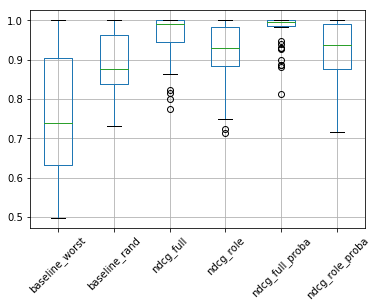

In [12]:
%matplotlib inline
pd.DataFrame(res)[['baseline_worst','baseline_rand','ndcg_full','ndcg_role','ndcg_full_proba','ndcg_role_proba']]\
    .boxplot(figsize=(5,8), rot=45)

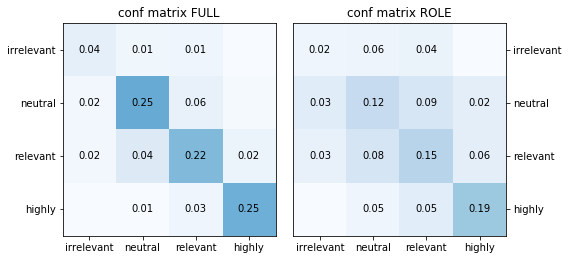

In [85]:
%matplotlib inline

from matplotlib import cm as colm
plt.figure(figsize=(8,5))
sub = plt.subplot(121)
normed = conf_matrix_full/conf_matrix_full.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
plt.title('conf matrix FULL')
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed[i][j]
        c='%.2f'%v if v>0.005 else ''
        sub.text(i, j, c, va='center', ha='center')



sub = plt.subplot(122)
normed = conf_matrix_role/conf_matrix_role.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
sub.yaxis.tick_right()
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed[i][j]
        c='%.2f'%v if v>0.01 else ''
        sub.text(i, j, c, va='center', ha='center')
        
plt.title('conf matrix ROLE')

plt.tight_layout()
plt.show()

In [105]:
print(list(enumerate(svmfullmodel.clf.named_steps['feats'].features_)))

[(0, 'mean_word_len'), (1, 'num_chars'), (2, 'num_digits'), (3, 'num_dollarsigns'), (4, 'num_numbers'), (5, 'num_upper_chars'), (6, 'num_upper_words'), (7, 'num_word_repetitions_clean'), (8, 'num_word_repetitions_raw'), (9, 'num_words'), (10, 'ratio_digits'), (11, 'ratio_numbers'), (12, 'ratio_upper_chars'), (13, 'ratio_upper_words'), (14, 'ratio_word_repetitions_clean'), (15, 'ratio_word_repetitions_raw')]


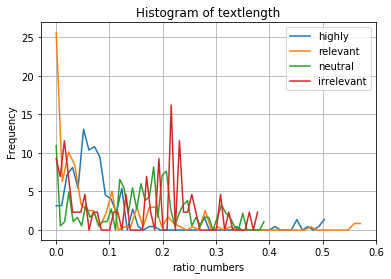

In [108]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d

bins = 20
# tmp = pd.DataFrame({'rating':train['rating'], 'len':train['THREE_SENTENCES'].str.len()})

col = 11
X = svmfullmodel.clf.named_steps['feats'].fit_transform(svmfullmodel.trainfrm)
y = svmfullmodel.get_target(frm=svmfullmodel.trainfrm)

for i, a in enumerate(['highly', 'relevant',  'neutral','irrelevant']):
    x = X[:,col][y==abs(3-i)]
    n, bins = np.histogram(x, 50, normed=1)

    f = interp1d(bins[:-1], n, kind='cubic')
    l = plt.plot(bins[:-1], f(bins[:-1]), label=a)

plt.xlabel(svmfullmodel.clf.named_steps['feats'].features_[col])
plt.ylabel('Frequency')
plt.title('Histogram of textlength')
#plt.xlim(0,500)
plt.legend()
plt.grid(True)

## Ensemble

In [70]:
class Embedder(BaseEstimator, TransformerMixin):
    def __init__(self, embedding, sentence_col='THREE_SENTENCES'):
        self.embedding = embedding
        self.col = sentence_col
        self.esize = self.embedding.vector_size
        self.num_sents = 3

    def fit(self, x, y=None):
        return self

    def transform(self, frm):
        X = []
        for i, row in frm.iterrows():
            sents = [str(s).lower() for s in nlp(row['THREE_SENTENCES']).sents]
            vecs = [self.embedding.infer_vector(se.lower().split()) for se in sents][:self.num_sents]
            while len(vecs) < self.num_sents:
                vecs.append(list(np.zeros((self.esize,))))
            X.append(np.array(vecs).reshape((self.num_sents * self.esize, )))
            
        return X

class SyntaxFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, asfrm=False, n_workers=6):
        self.asfrm = asfrm
        self.n_workers = n_workers
        
    def fit(self, X, y=None):
        return self

    def transform(self, frm):
        p = Pool(self.n_workers)
        Xd = pd.DataFrame(p.map(self._features, frm.iterrows()), index=frm.index)
        p.close()
        
        self.features_ = list(Xd.columns)
        
        if (self.asfrm):
            return Xd
        
        return Xd.as_matrix()
    
    def _features(self, row):
        _, row = row
        raw = row['THREE_SENTENCES']
        clean = row['clean']
        counts_r = Counter(raw.split())
        counts_c = Counter(clean.split())
        ret = {
            'num_chars': len(raw),
            'num_words': len(raw.split()),
            'num_upper_chars': sum(1 for c in raw if c.isupper()),
            'num_upper_words': sum(1 for w in raw.split() if w[0].isupper()),
            'ratio_upper_chars': sum(1 for c in raw if c.isupper())/len(raw),
            'ratio_upper_words': sum(1 for w in raw.split() if w[0].isupper())/len(raw.split()),
            'mean_word_len': np.mean([len(w) for w in raw.split()]),
            'num_word_repetitions_raw': len({k:v for k,v in counts_r.items() if v>1}),
            'num_word_repetitions_clean': len({k:v for k,v in counts_c.items() if v>1}),
            'ratio_word_repetitions_raw': len({k:v for k,v in counts_r.items() if v>1})/len(raw.split()),
            'ratio_word_repetitions_clean': len({k:v for k,v in counts_c.items() if v>1})/len(clean.split()),
            'num_dollarsigns': len(raw)-len(raw.replace('$','')),
            'num_numbers': len(re.findall(r'\d+', raw)),
            'num_digits': len(re.findall(r'\d', raw)),
            'ratio_numbers': len(re.findall(r'\d+', raw))/len(raw.split()),
            'ratio_digits': len(re.findall(r'\d', raw))/len(raw),
        }
        return ret

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from multiprocessing import Pool

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.4,
    'max_df': 0.6,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'loss': 'log', #['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
    'penalty': 'l2',
    'shuffle': True,
    'alpha': 1e-4,
    'n_iter': 15,
    'random_state': 42,
    'class_weight': 'balanced'
}
rf_par = {
    'n_estimators': 20,
    'criterion': 'gini', #gini or entropy
    'max_features': 'auto', #int, float, auto, sqrt, log2, None
    'random_state': 42,
    'class_weight': 'balanced'
}
svm_par = {
    'C': 1.0,
    'kernel': 'sigmoid', #linear’, ‘poly’, ‘rbf’, ‘sigmoid’
    'probability': True,
    'class_weight': 'balanced',
    'decision_function_shape':'ovr', # ovo, ovr
    'random_state': 42
}

def pipln():
    return [
        ('clf', VotingClassifier(
            voting='soft', #hard, soft
            #weights=[2,1,2],
            estimators=[
                #('syn', Pipeline([
                #    ('feats', SyntaxFeatures()),
                #    ('rf', RandomForestClassifier(**rf_par))
                   #('svc', SVC(kernel='rbf', probability=True))
                #])),
                #('emb', Pipeline([
                #    ('emb', Embedder(embedding)),
                #    ('svc', SVC(**svm_par)) 
                   #('eclf', SGDClassifier(**clf_par))
                #])),
                ('bow', Pipeline([
                    ('lem', Lemmatiser()),
                    ('vect', CountVectorizer(**cv_par)),
                    ('tfidf', TfidfTransformer(**tt_par)),
                    ('svc', SVC(**svm_par)) 
                    #('bclf', SGDClassifier(**clf_par))
                ]))
            ]))
    ]

    return [
        ('union', FeatureUnion(
            transformer_list=[
                ('syn', Pipeline([
                    ('feats', SyntaxFeatures()),
                ])),
                ('bow', Pipeline([
                    ('lem', Lemmatiser()),
                    ('vect', CountVectorizer(**cv_par)),
                    ('tfidf', TfidfTransformer(**tt_par))
                ])),
                ('emb', Pipeline([
                    ('emb', Embedder(embedding))
                ]))
            ],
            transformer_weights={
                'syn': 1,
                'bow': 1,
                'emb': 1
            },
        )),
        #('clf', SGDClassifier(**clf_par))
        ('clf', SVC(kernel='rbf', probability=True))
    ]


conf_matrix_role = np.zeros((4,4))
conf_matrix_full = np.zeros((4,4))

# holer for stats
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
    'acc_role': [],
    'acc_full': [],
    'f1_role': [],
    'f1_full': []
}
macro_res = {
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
}

ceiter = 5
for crosseval in range(ceiter):
    print("\n\n==========================================================================")
    print("===                      CROSSEVAL ITERATION " + str(crosseval+1)+"/"+str(ceiter) + "                     =====")
    print("==========================================================================\n\n")
 
    scores_role = []
    scores_full = []
    scores_role_proba = []
    scores_full_proba = []
    
    rolemodels = [
        IDFscorer(frm=train[mask], grp=role, train_size=0.7, max_docsplit_iter=20, pipln=pipln())
        for role in roles.keys()
    ]
    
    tritei = ([txi for model in rolemodels for txi in list(model.trainfrm.index)],
              [txi for model in rolemodels for txi in list(model.testfrm.index)])
    
    fullmodel = IDFscorer(frm=train[mask], tritei=tritei, pipln=pipln())
    fullmodel.short_setinfo()
    
    fullmodel.establish_baseline()
    fullmodel.fit()

    # run evaluation for each role
    for model, role in zip(rolemodels, roles.keys()):
        print('=== '+role.upper()+' ======')

        model.short_setinfo()

        bl1, bl2 = model.establish_baseline(include_test=True, include_train=False)
        res['baseline_rand'].append(bl2)
        res['baseline_worst'].append(bl1)

        model.fit()

        # get predictions from model trained on role
        pred_role, pred_proba_role = model.predict(model.testfrm)

        # get predictions from model trained on all
        pred_full, pred_proba_full = fullmodel.predict(model.testfrm)

        score_role = np.sum(pred_proba_role * np.array([1,2,3,4]), axis=1)
        score_full = np.sum(pred_proba_full * np.array([1,2,3,4]), axis=1)

        #score_role = np.argmax(pred_proba_role, axis=1) + np.max(pred_proba_role, axis=1)
        #score_full = np.argmax(pred_proba_full, axis=1) + np.max(pred_proba_full, axis=1)

        #score_role = pred_proba_role[:,3]
        #score_full = pred_proba_full[:,3]
        
        # calculate accuracy 
        testtarget = model.get_target()
        res['acc_role'].append(np.mean(pred_role == testtarget))
        print('Accuracy | role :', np.mean(pred_role == testtarget))
        res['acc_full'].append(np.mean(pred_full == testtarget))
        print('Accuracy | full :', np.mean(pred_full == testtarget))

        _,_,f1,supp = precision_recall_fscore_support(testtarget, pred_full,labels=[0,1,2,3])
        res['f1_full'].append((f1*supp).sum()/supp.sum())
        _,_,f1,supp = precision_recall_fscore_support(testtarget, pred_role,labels=[0,1,2,3])
        res['f1_role'].append((f1*supp).sum()/supp.sum())

        # print classification report
        print(metrics.classification_report(testtarget, pred_full,
                                            labels=[0,1,2,3],
                                            target_names=list(rating_map2.keys())))

        # print confusion matrix
        conf_matrix_role += np.array(metrics.confusion_matrix(testtarget, pred_role, labels=[0,1,2,3]))
        cm = metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3])
        conf_matrix_full += np.array(cm)
        print(cm)
        #print(metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3]))

        # add scores to full list
        score_role_tmp = list(zip(list(model.testfrm.index), pred_role))
        scores_role += score_role_tmp
        score_full_tmp = list(zip(list(model.testfrm.index), pred_full))
        scores_full += score_full_tmp

        # add scores based on probability to full list
        score_role_proba_tmp = list(zip(list(model.testfrm.index), score_role))
        scores_role_proba += score_role_proba_tmp
        score_full_proba_tmp = list(zip(list(model.testfrm.index), score_full))
        scores_full_proba += score_full_proba_tmp

        # add NDCG to results
        res['ndcg_role'].append(ndcg2(model.testfrm, score_role_tmp))
        res['ndcg_role_proba'].append(ndcg2(model.testfrm, score_role_proba_tmp))
        res['ndcg_full'].append(ndcg2(model.testfrm, score_full_tmp))
        res['ndcg_full_proba'].append(ndcg2(model.testfrm, score_full_proba_tmp))

        # echo results
        print('> NDCG Score | role | categ  | {:.5f}'.format(ndcg2(model.testfrm, score_role_tmp)))
        print('> NDCG Score | role | proba* | {:.5f}'.format(ndcg2(model.testfrm, score_role_proba_tmp)))
        print('> NDCG Score | full | categ  | {:.5f}'.format(ndcg2(model.testfrm, score_full_tmp)))
        print('> NDCG Score | full | proba* | {:.5f}'.format(ndcg2(model.testfrm, score_full_proba_tmp)))


    # echo results of NDCG for entire set
    tmp = ndcg2(train.loc[[k for k,v in scores_role]], scores_role)
    macro_res['ndcg_role'].append(tmp)
    print('TOTAL NDCG | role | categ  | {:.5f}'.format(tmp))

    tmp = ndcg2(train.loc[[k for k,v in scores_role_proba]], scores_role_proba)
    macro_res['ndcg_role_proba'].append(tmp)
    print('TOTAL NDCG | role | proba* | {:.5f}'.format(tmp))

    
    tmp = ndcg2(train.loc[[k for k,v in scores_full]], scores_full)
    macro_res['ndcg_full'].append(tmp)
    print('TOTAL NDCG | full | categ  | {:.5f}'.format(tmp))
    
    
    tmp = ndcg2(train.loc[[k for k,v in scores_full_proba]], scores_full_proba)
    macro_res['ndcg_full_proba'].append(tmp)
    print('TOTAL NDCG | full | proba* | {:.5f}'.format(tmp))
    
res['baseline_rand'] = np.mean(res['baseline_rand'], axis=1)



===                      CROSSEVAL ITERATION 1/5                     =====


Items in training set: 709 (73.24%)
Items in testing set: 259
 = 968
Number of documents: 48 total, 25 train, 23 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),67.00,225.00,202.00,215.00
Test (abs),22.00,81.00,78.00,78.00
Train (rel),0.09,0.32,0.28,0.30
Test (rel),0.08,0.31,0.30,0.30
diff,0.01,0.00,-0.02,0.00


RATING_EXPERT_1 gave 406 ratings, in train: 355, in test: 51.
RATING_EXPERT_2 gave 366 ratings, in train: 264, in test: 102.
RATING_EXPERT_3 gave 60 ratings, in train: 46, in test: 14.
RATING_EXPERT_4 gave 35 ratings, in train: 31, in test: 4.
RATING_EXPERT_5 gave 80 ratings, in train: 51, in test: 29.
RATING_EXPERT_6 gave 60 ratings, in train: 33, in test: 27.
RATING_EXPERT_7 gave 74 ratings, in train: 58, in test: 16.
RATING_EXPERT_1.1 gave 222 ratings, in train: 197, in test: 25.
RATING_EXPERT_9 gave 73 ratings, in train: 6, in test: 67.
RATING_EXPERT_10 gave 20 ratings, in train: 18, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.885749420934 | std = 0.0168922962282
NDCG for worst case (inverted best) order:
 > ndcg = 0.744080383932
=== INSURER ======
Items in training set: 14 (73.68%)
Items in testing set: 5
 = 19
Number of documents: 8 total, 4 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,1.00,4.00,8.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.07,0.07,0.29,0.57
Test (rel),0.00,0.00,0.80,0.20
diff,0.07,0.07,-0.51,0.37


RATING_EXPERT_1 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_2 gave 4 ratings, in train: 1, in test: 3.
RATING_EXPERT_5 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_6 gave 3 ratings, in train: 2, in test: 1.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.963362497088 | std = 0.0307871479672
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.2
Accuracy | full : 0.6
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.75      0.75      0.75         4
     highly       0.00      0.00      0.00         1

avg / total       0.60      0.60      0.60         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 3 1]
 [0 0 1 0]]
> NDCG Score | role | categ  | 0.938

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),21.00,24.00,45.00,42.00
Test (abs),5.00,16.00,16.00,16.00
Train (rel),0.16,0.18,0.34,0.32
Test (rel),0.09,0.30,0.30,0.30
diff,0.06,-0.12,0.04,0.02


RATING_EXPERT_1 gave 81 ratings, in train: 53, in test: 28.
RATING_EXPERT_2 gave 63 ratings, in train: 41, in test: 22.
RATING_EXPERT_3 gave 19 ratings, in train: 9, in test: 10.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 15, in test: 10.
RATING_EXPERT_6 gave 14 ratings, in train: 13, in test: 1.
RATING_EXPERT_7 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_1.1 gave 56 ratings, in train: 56, in test: 0.
RATING_EXPERT_9 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_10 gave 12 ratings, in train: 11, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.838490001787 | std = 0.0390412061797
NDCG for worst case (inverted best) order:
 > ndcg = 0.647440862448
Accuracy | role : 0.301886792453
Accuracy | full : 0.547169811321
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         5
    neutral       0.75      0.56      0.64        16
   relevant       0.43      1.

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),21.00,31.00,23.00,19.00
Test (abs),11.00,14.00,7.00,3.00
Train (rel),0.22,0.33,0.24,0.20
Test (rel),0.31,0.40,0.20,0.09
diff,-0.09,-0.07,0.04,0.12


RATING_EXPERT_1 gave 73 ratings, in train: 62, in test: 11.
RATING_EXPERT_2 gave 48 ratings, in train: 36, in test: 12.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_6 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_7 gave 8 ratings, in train: 0, in test: 8.
RATING_EXPERT_1.1 gave 16 ratings, in train: 8, in test: 8.
RATING_EXPERT_9 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.704693466655 | std = 0.0677415040005
NDCG for worst case (inverted best) order:
 > ndcg = 0.48404447089
Accuracy | role : 0.485714285714
Accuracy | full : 0.2
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00        11
    neutral       0.00      0.00      0.00        14
   relevant       0.22      1.00      0.36         7

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.859291460092 | std = 0.0608281851935
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
Accuracy | role : 0.333333333333
Accuracy | full : 0.333333333333
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         2
   relevant       0.33      1.00      0.50         2
     highly       0.00      0.00      0.00         2

avg / total       0.11      0.33      0.17         6

[[0 0 0 0]
 [0 0 2 0]
 [0 0 2 0]
 [0 0 2 0]]
> NDCG Score | r

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,1.00,17.00,8.00
Test (abs),0.00,2.00,5.00,0.00
Train (rel),0.04,0.04,0.63,0.30
Test (rel),0.00,0.29,0.71,0.00
diff,0.04,-0.25,-0.08,0.30


RATING_EXPERT_1 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_2 gave 20 ratings, in train: 13, in test: 7.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 14, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.93486676842 | std = 0.0430215640855
NDCG for worst case (inverted best) order:
 > ndcg = 0.840211486843
Accuracy | role : 0.714285714286
Accuracy | full : 0.285714285714
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.20      0.50      0.29         2
   relevant       0.50      0.20      0.29         5
     highly       0.00      0.00      0.00         0

avg / total       0.41      0.29      0.29         7

[[0 0 0 0]
 [0 1 1 0]
 [0 4 1 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.88713
> NDCG Score | role | prob

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),17.00,127.00,59.00,107.00
Test (abs),3.00,36.00,20.00,48.00
Train (rel),0.05,0.41,0.19,0.35
Test (rel),0.03,0.34,0.19,0.45
diff,0.03,0.07,0.00,-0.10


RATING_EXPERT_1 gave 177 ratings, in train: 177, in test: 0.
RATING_EXPERT_2 gave 145 ratings, in train: 107, in test: 38.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 6, in test: 19.
RATING_EXPERT_7 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_1.1 gave 81 ratings, in train: 81, in test: 0.
RATING_EXPERT_9 gave 50 ratings, in train: 0, in test: 50.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.89249576183 | std = 0.0229840442013
NDCG for worst case (inverted best) order:
 > ndcg = 0.739986540698
Accuracy | role : 0.757009345794
Accuracy | full : 0.551401869159
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.44      1.00      0.62        36
   relevant       0.00      0.00      0.00        20
     highly       0.88      0.48   

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),3.00,10.00,21.00,12.00
Test (abs),3.00,2.00,7.00,3.00
Train (rel),0.07,0.22,0.46,0.26
Test (rel),0.20,0.13,0.47,0.20
diff,-0.13,0.08,-0.01,0.06


RATING_EXPERT_1 gave 26 ratings, in train: 23, in test: 3.
RATING_EXPERT_2 gave 25 ratings, in train: 16, in test: 9.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 1, in test: 3.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 18 ratings, in train: 17, in test: 1.
RATING_EXPERT_9 gave 5 ratings, in train: 0, in test: 5.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


NDCG after 100x random order:
 > mean ndcg = 0.804230529485 | std = 0.0655840491271
NDCG for worst case (inverted best) order:
 > ndcg = 0.570400316714
Accuracy | role : 0.2
Accuracy | full : 0.466666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         3
    neutral       0.00      0.00      0.00         2
   relevant       0.50      1.00      0.67         7
     highly       0.00      0.00      0.00         3

avg / total       0.23      0.47      0.31        15

[[0 1 2 0]
 [0 0 2 0]
 [0 0 7 0]
 [0 0 3 0]]
> NDCG Score | role | categ  | 0.80343
> NDCG Score | role | proba* | 0.80015
> NDCG Score | full | categ  | 0.85570
> NDCG Score | full | proba* | 0.80171
=== AGENT ======
Items in training set: 44 (72.13%)
Items in testing set: 17
 = 61
Number of documents: 16 total, 11 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),3.00,26.00,12.00,3.00
Test (abs),0.00,9.00,6.00,2.00
Train (rel),0.07,0.59,0.27,0.07
Test (rel),0.00,0.53,0.35,0.12
diff,0.07,0.06,-0.08,-0.05


RATING_EXPERT_1 gave 24 ratings, in train: 19, in test: 5.
RATING_EXPERT_2 gave 30 ratings, in train: 26, in test: 4.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 5, in test: 1.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_7 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_1.1 gave 10 ratings, in train: 4, in test: 6.
NDCG after 100x random order:
 > mean ndcg = 0.820151453744 | std = 0.050247548777
NDCG for worst case (inverted best) order:
 > ndcg = 0.709632159356
Accuracy | role : 0.529411764706
Accuracy | full : 0.235294117647
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         9
   relevant       0.36      0.67      0.47         6
     highly       0.00      0.00      0.00         2

avg / total       0.13      0.24      0.17        17


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,7.00,5.00
Test (abs),0.00,0.00,7.00,2.00
Train (rel),0.00,0.00,0.58,0.42
Test (rel),0.00,0.00,0.78,0.22
diff,0.00,0.00,-0.19,0.19


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.929121177516 | std = 0.0293431313416
NDCG for worst case (inverted best) order:
 > ndcg = 0.886519707456
Accuracy | role : 0.777777777778
Accuracy | full : 0.777777777778
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         7
     highly       0.00      0.00      0.00         2

avg / total       0.78      0.78      0.78         9

[[0 0 0 0]
 [0 0 0 0]
 [0 0 7 0]
 [0 2 0 0]]
> NDCG Score | role | categ  | 0.88652
> NDCG Score | role | proba* | 0.

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.966214834917 | std = 0.0299212455725
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.8
Accuracy | full : 0.8
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.80      1.00      0.89         4
     highly       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 1 0]]
> NDCG Score | role | categ  | 0.92

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


TOTAL NDCG | full | proba* | 0.88966


===                      CROSSEVAL ITERATION 2/5                     =====


Items in training set: 700 (72.31%)
Items in testing set: 268
 = 968
Number of documents: 46 total, 25 train, 21 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),74.00,222.00,184.00,220.00
Test (abs),15.00,84.00,96.00,73.00
Train (rel),0.11,0.32,0.26,0.31
Test (rel),0.06,0.31,0.36,0.27
diff,0.05,0.00,-0.10,0.04


RATING_EXPERT_1 gave 406 ratings, in train: 323, in test: 83.
RATING_EXPERT_2 gave 366 ratings, in train: 236, in test: 130.
RATING_EXPERT_3 gave 60 ratings, in train: 41, in test: 19.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 64, in test: 16.
RATING_EXPERT_6 gave 60 ratings, in train: 34, in test: 26.
RATING_EXPERT_7 gave 74 ratings, in train: 50, in test: 24.
RATING_EXPERT_1.1 gave 222 ratings, in train: 134, in test: 88.
RATING_EXPERT_9 gave 73 ratings, in train: 69, in test: 4.
RATING_EXPERT_10 gave 20 ratings, in train: 8, in test: 12.
NDCG after 100x random order:
 > mean ndcg = 0.893572151967 | std = 0.0133611679298
NDCG for worst case (inverted best) order:
 > ndcg = 0.760854339657
=== INSURER ======
Items in training set: 15 (78.95%)
Items in testing set: 4
 = 19
Number of documents: 8 total, 6 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),0.00,1.00,5.00,9.00
Test (abs),1.00,0.00,3.00,0.00
Train (rel),0.00,0.07,0.33,0.60
Test (rel),0.25,0.00,0.75,0.00
diff,-0.25,0.07,-0.42,0.60


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 1, in test: 2.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.895250634027 | std = 0.0822842320459
NDCG for worst case (inverted best) order:
 > ndcg = 0.809953116642
Accuracy | role : 0.75
Accuracy | full : 0.5
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.00      0.00      0.00         0
   relevant       0.67      0.67      0.67         3
     highly       0.00      0.00      0.00         0

avg / total       0.50      0.50      0.50         4

[[0 0 1 0]
 [0 0 0 0]
 [0 1 2 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),20.00,29.00,38.00,45.00
Test (abs),6.00,11.00,23.00,13.00
Train (rel),0.15,0.22,0.29,0.34
Test (rel),0.11,0.21,0.43,0.25
diff,0.04,0.01,-0.15,0.10


RATING_EXPERT_1 gave 81 ratings, in train: 62, in test: 19.
RATING_EXPERT_2 gave 63 ratings, in train: 36, in test: 27.
RATING_EXPERT_3 gave 19 ratings, in train: 0, in test: 19.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_7 gave 19 ratings, in train: 2, in test: 17.
RATING_EXPERT_1.1 gave 56 ratings, in train: 38, in test: 18.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 3, in test: 9.
NDCG after 100x random order:
 > mean ndcg = 0.85519527877 | std = 0.0402139200951
NDCG for worst case (inverted best) order:
 > ndcg = 0.650275735108
Accuracy | role : 0.320754716981
Accuracy | full : 0.169811320755
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         6
    neutral       0.00      0.00      0.00        11
   relevant       0.36      0.39

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),25.00,33.00,22.00,15.00
Test (abs),7.00,12.00,8.00,7.00
Train (rel),0.26,0.35,0.23,0.16
Test (rel),0.21,0.35,0.24,0.21
diff,0.06,-0.01,-0.00,-0.05


RATING_EXPERT_1 gave 73 ratings, in train: 52, in test: 21.
RATING_EXPERT_2 gave 48 ratings, in train: 25, in test: 23.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_7 gave 8 ratings, in train: 3, in test: 5.
RATING_EXPERT_1.1 gave 16 ratings, in train: 11, in test: 5.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 2, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.769518226313 | std = 0.0597499268126
NDCG for worst case (inverted best) order:
 > ndcg = 0.545026013136
Accuracy | role : 0.352941176471
Accuracy | full : 0.176470588235
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         7
    neutral       0.00      0.00      0.00        12
   relevant       0.14      0.38      0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,6.00,6.00,3.00
Test (abs),0.00,0.00,0.00,6.00
Train (rel),0.00,0.40,0.40,0.20
Test (rel),0.00,0.00,0.00,1.00
diff,0.00,0.40,0.40,-0.80


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 8 ratings, in train: 2, in test: 6.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.0
Accuracy | full : 0.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.00      0.00      0.00         0
     highly       0.00      0.00      0.00         6

avg / total       0.00      0.00      0.00         6

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 6 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,3.00,6.00,8.00
Test (abs),0.00,0.00,16.00,0.00
Train (rel),0.06,0.17,0.33,0.44
Test (rel),0.00,0.00,1.00,0.00
diff,0.06,0.17,-0.67,0.44


RATING_EXPERT_1 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_2 gave 20 ratings, in train: 16, in test: 4.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 2, in test: 12.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.0
Accuracy | full : 0.25
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.25      0.40        16
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.25      0.40        16

[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  4 12]
 [ 0  0  0  0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | cat

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),20.00,114.00,52.00,118.00
Test (abs),0.00,49.00,27.00,37.00
Train (rel),0.07,0.38,0.17,0.39
Test (rel),0.00,0.43,0.24,0.33
diff,0.07,-0.06,-0.07,0.06


RATING_EXPERT_1 gave 177 ratings, in train: 149, in test: 28.
RATING_EXPERT_2 gave 145 ratings, in train: 98, in test: 47.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 6, in test: 19.
RATING_EXPERT_7 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_1.1 gave 81 ratings, in train: 42, in test: 39.
RATING_EXPERT_9 gave 50 ratings, in train: 50, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 1, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.878944872683 | std = 0.0261682830178
NDCG for worst case (inverted best) order:
 > ndcg = 0.772550085323
Accuracy | role : 0.752212389381
Accuracy | full : 0.513274336283
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.48      0.84      0.61        49
   relevant       1.00      0.04      0.07        27
     highly       0.62      0.43 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),5.00,10.00,19.00,11.00
Test (abs),1.00,2.00,9.00,4.00
Train (rel),0.11,0.22,0.42,0.24
Test (rel),0.06,0.12,0.56,0.25
diff,0.05,0.10,-0.14,-0.01


RATING_EXPERT_1 gave 26 ratings, in train: 16, in test: 10.
RATING_EXPERT_2 gave 25 ratings, in train: 14, in test: 11.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 18 ratings, in train: 13, in test: 5.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


NDCG after 100x random order:
 > mean ndcg = 0.866610601522 | std = 0.0483170343273
NDCG for worst case (inverted best) order:
 > ndcg = 0.702911220142
Accuracy | role : 0.5625
Accuracy | full : 0.4375
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.00      0.00      0.00         2
   relevant       0.50      0.67      0.57         9
     highly       0.25      0.25      0.25         4

avg / total       0.34      0.44      0.38        16

[[0 0 1 0]
 [0 0 2 0]
 [0 0 6 3]
 [0 0 3 1]]
> NDCG Score | role | categ  | 0.86417
> NDCG Score | role | proba* | 0.94202
> NDCG Score | full | categ  | 0.87971
> NDCG Score | full | proba* | 0.87971
=== AGENT ======
Items in training set: 46 (75.41%)
Items in testing set: 15
 = 61
Number of documents: 16 total, 13 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),3.00,25.00,14.00,4.00
Test (abs),0.00,10.00,4.00,1.00
Train (rel),0.07,0.54,0.30,0.09
Test (rel),0.00,0.67,0.27,0.07
diff,0.07,-0.12,0.04,0.02


RATING_EXPERT_1 gave 24 ratings, in train: 21, in test: 3.
RATING_EXPERT_2 gave 30 ratings, in train: 18, in test: 12.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_1.1 gave 10 ratings, in train: 10, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.825203270871 | std = 0.0482560068845
NDCG for worst case (inverted best) order:
 > ndcg = 0.73607743137


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy | role : 0.666666666667
Accuracy | full : 0.0666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00        10
   relevant       0.00      0.00      0.00         4
     highly       0.07      1.00      0.12         1

avg / total       0.00      0.07      0.01        15

[[ 0  0  0  0]
 [ 0  0  0 10]
 [ 0  0  0  4]
 [ 0  0  0  1]]
> NDCG Score | role | categ  | 0.89653
> NDCG Score | role | proba* | 0.89798
> NDCG Score | full | categ  | 0.89653
> NDCG Score | full | proba* | 0.74210
=== UNDERWRITER ======
Items in training set: 15 (71.43%)
Items in testing set: 6
 = 21
Number of documents: 7 total, 4 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,12.00,3.00
Test (abs),0.00,0.00,2.00,4.00
Train (rel),0.00,0.00,0.80,0.20
Test (rel),0.00,0.00,0.33,0.67
diff,0.00,0.00,0.47,-0.47


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_9 gave 2 ratings, in train: 0, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.953384353207 | std = 0.0282847808086
NDCG for worst case (inverted best) order:
 > ndcg = 0.89277412641
Accuracy | role : 0.333333333333
Accuracy | full : 0.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.00      0.00      0.00         2
     highly       0.00      0.00      0.00         4

avg / total       0.00      0.00      0.00         6

[[0 0 0 0]
 [0 0 0 0]
 [0 2 0 0]
 [0 4 0 0]]
> NDCG Score | role | categ  | 0.89277
> NDCG Score | role | proba* | 0.97158
> NDCG

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.964878755983 | std = 0.030266961568
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.8
Accuracy | full : 0.2
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.00      0.00      0.00         4
     highly       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 4]
 [0 0 0 1]]
> NDCG Score | role | categ  | 0.929

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


TOTAL NDCG | full | categ  | 0.93934
TOTAL NDCG | full | proba* | 0.87461


===                      CROSSEVAL ITERATION 3/5                     =====


Items in training set: 694 (71.69%)
Items in testing set: 274
 = 968
Number of documents: 42 total, 25 train, 17 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),50.00,227.00,207.00,210.00
Test (abs),39.00,79.00,73.00,83.00
Train (rel),0.07,0.33,0.30,0.30
Test (rel),0.14,0.29,0.27,0.30
diff,-0.07,0.04,0.03,-0.00


RATING_EXPERT_1 gave 406 ratings, in train: 364, in test: 42.
RATING_EXPERT_2 gave 366 ratings, in train: 238, in test: 128.
RATING_EXPERT_3 gave 60 ratings, in train: 37, in test: 23.
RATING_EXPERT_4 gave 35 ratings, in train: 25, in test: 10.
RATING_EXPERT_5 gave 80 ratings, in train: 51, in test: 29.
RATING_EXPERT_6 gave 60 ratings, in train: 45, in test: 15.
RATING_EXPERT_7 gave 74 ratings, in train: 60, in test: 14.
RATING_EXPERT_1.1 gave 222 ratings, in train: 103, in test: 119.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 17, in test: 3.
NDCG after 100x random order:
 > mean ndcg = 0.872878567646 | std = 0.0167866554507
NDCG for worst case (inverted best) order:
 > ndcg = 0.723881577264
=== INSURER ======
Items in training set: 10 (52.63%)
Items in testing set: 9
 = 19
Number of documents: 8 total, 7 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,0.00,8.00,1.00
Test (abs),0.00,1.00,0.00,8.00
Train (rel),0.10,0.00,0.80,0.10
Test (rel),0.00,0.11,0.00,0.89
diff,0.10,-0.11,0.80,-0.79


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.966453941326 | std = 0.0349708170172
NDCG for worst case (inverted best) order:
 > ndcg = 0.903786237755
Accuracy | role : 0.0
Accuracy | full : 0.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         1
   relevant       0.00      0.00      0.00         0
     highly       0.00      0.00      0.00         8

avg / total       0.00      0.00      0.00         9

[[0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 8 0]]
> NDCG Score | role | categ  | 0.989

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),16.00,29.00,49.00,42.00
Test (abs),10.00,11.00,12.00,16.00
Train (rel),0.12,0.21,0.36,0.31
Test (rel),0.20,0.22,0.24,0.33
diff,-0.09,-0.01,0.12,-0.02


RATING_EXPERT_1 gave 81 ratings, in train: 59, in test: 22.
RATING_EXPERT_2 gave 63 ratings, in train: 52, in test: 11.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 10, in test: 15.
RATING_EXPERT_6 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_7 gave 19 ratings, in train: 17, in test: 2.
RATING_EXPERT_1.1 gave 56 ratings, in train: 19, in test: 37.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 10, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.808116373664 | std = 0.0482895439656
NDCG for worst case (inverted best) order:
 > ndcg = 0.596495958965
Accuracy | role : 0.34693877551
Accuracy | full : 0.163265306122
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00        10
    neutral       0.00      0.00      0.00        11
   relevant       0.21      0.

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),23.00,35.00,19.00,16.00
Test (abs),9.00,10.00,11.00,6.00
Train (rel),0.25,0.38,0.20,0.17
Test (rel),0.25,0.28,0.31,0.17
diff,-0.00,0.10,-0.10,0.01


RATING_EXPERT_1 gave 73 ratings, in train: 63, in test: 10.
RATING_EXPERT_2 gave 48 ratings, in train: 31, in test: 17.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 14 ratings, in train: 4, in test: 10.
RATING_EXPERT_5 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_6 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_7 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_1.1 gave 16 ratings, in train: 16, in test: 0.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.756708580002 | std = 0.0608497731202
NDCG for worst case (inverted best) order:
 > ndcg = 0.536360146272
Accuracy | role : 0.472222222222
Accuracy | full : 0.305555555556
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         9
    neutral       0.00      0.00      0.00        10
   relevant       0.35      1.00      0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.872685049262 | std = 0.0592978089946
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
Accuracy | role : 0.333333333333
Accuracy | full : 0.333333333333
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         2
   relevant       0.33      1.00      0.50         2
     highly       0.00      0.00      0.00         2

avg / total       0.11      0.33      0.17         6

[[0 0 0 0]
 [0 0 2 0]
 [0 0 2 0]
 [0 0 2 0]]
> NDCG Score | r

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,3.00,17.00,0.00
Test (abs),0.00,0.00,5.00,8.00
Train (rel),0.05,0.14,0.81,0.00
Test (rel),0.00,0.00,0.38,0.62
diff,0.05,0.14,0.42,-0.62


RATING_EXPERT_1 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_2 gave 20 ratings, in train: 7, in test: 13.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_1.1 gave 14 ratings, in train: 14, in test: 0.


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


NDCG after 100x random order:
 > mean ndcg = 0.947081010501 | std = 0.0253242117352
NDCG for worst case (inverted best) order:
 > ndcg = 0.874766371273
Accuracy | role : 0.384615384615
Accuracy | full : 0.384615384615
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.38      1.00      0.56         5
     highly       0.00      0.00      0.00         8

avg / total       0.15      0.38      0.21        13

[[0 0 0 0]
 [0 0 0 0]
 [0 0 5 0]
 [0 0 8 0]]
> NDCG Score | role | categ  | 0.88430
> NDCG Score | role | proba* | 0.87477
> NDCG Score | full | categ  | 0.88430
> NDCG Score | full | proba* | 0.88430
=== TRUSTEE ======
Items in training set: 304 (72.90%)
Items in testing set: 113
 = 417
Number of documents: 21 total, 15 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),4.00,124.00,58.00,118.00
Test (abs),16.00,39.00,21.00,37.00
Train (rel),0.01,0.41,0.19,0.39
Test (rel),0.14,0.35,0.19,0.33
diff,-0.13,0.06,0.00,0.06


RATING_EXPERT_1 gave 177 ratings, in train: 177, in test: 0.
RATING_EXPERT_2 gave 145 ratings, in train: 87, in test: 58.
RATING_EXPERT_3 gave 19 ratings, in train: 3, in test: 16.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_7 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_1.1 gave 81 ratings, in train: 26, in test: 55.
RATING_EXPERT_9 gave 50 ratings, in train: 50, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.839347545236 | std = 0.0309925544977
NDCG for worst case (inverted best) order:
 > ndcg = 0.661800281992
Accuracy | role : 0.646017699115
Accuracy | full : 0.41592920354
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00        16
    neutral       0.44      0.87      0.58        39
   relevant       0.00      0.00      0.00        21
     highly       0.37      0.35   

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),4.00,7.00,21.00,11.00
Test (abs),2.00,5.00,7.00,4.00
Train (rel),0.09,0.16,0.49,0.26
Test (rel),0.11,0.28,0.39,0.22
diff,-0.02,-0.11,0.10,0.03


RATING_EXPERT_1 gave 26 ratings, in train: 21, in test: 5.
RATING_EXPERT_2 gave 25 ratings, in train: 11, in test: 14.
RATING_EXPERT_3 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 18 ratings, in train: 13, in test: 5.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.814919025491 | std = 0.056809786194
NDCG for worst case (inverted best) order:
 > ndcg = 0.603596490281
Accuracy | role : 0.388888888889
Accuracy | full : 0.388888888889
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         2
    neutral       0.00      0.00      0.00         5
   relevant       0.39      1.00      0.56         7
     highly       0.00      0.00      0.00     

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),1.00,24.00,14.00,4.00
Test (abs),2.00,11.00,4.00,1.00
Train (rel),0.02,0.56,0.33,0.09
Test (rel),0.11,0.61,0.22,0.06
diff,-0.09,-0.05,0.10,0.04


RATING_EXPERT_1 gave 24 ratings, in train: 23, in test: 1.
RATING_EXPERT_2 gave 30 ratings, in train: 20, in test: 10.
RATING_EXPERT_3 gave 7 ratings, in train: 4, in test: 3.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 5, in test: 1.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_7 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_1.1 gave 10 ratings, in train: 5, in test: 5.
NDCG after 100x random order:
 > mean ndcg = 0.784802967136 | std = 0.0642791703095
NDCG for worst case (inverted best) order:
 > ndcg = 0.598679978613
Accuracy | role : 0.611111111111
Accuracy | full : 0.444444444444
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         2
    neutral       1.00      0.55      0.71        11
   relevant       0.25      0.50      0.33         4
     highly       0.00      0.00      0.00         1

avg / total       0.67      0.44      0.51        1

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,7.00,7.00
Test (abs),0.00,0.00,7.00,0.00
Train (rel),0.00,0.00,0.50,0.50
Test (rel),0.00,0.00,1.00,0.00
diff,0.00,0.00,-0.50,0.50


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 1.0
Accuracy | full : 1.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         7
     highly       0.00      0.00      0.00         0

avg / total       1.00      1.00      1.00         7

[[0 0 0 0]
 [0 0 0 0]
 [0 0 7 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | categ  | 1.00000
> NDCG Scor

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_2 gave 14 ratings, in train: 12, in test: 2.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.962985555142 | std = 0.0294635647294
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.8
Accuracy | full : 0.8
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.80      1.00      0.89         4
     highly       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 1 0]]
> NDCG Score | role | categ  | 0.92

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 713 (73.66%)
Items in testing set: 255
 = 968
Number of documents: 45 total, 25 train, 20 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),72.00,214.00,211.00,216.00
Test (abs),17.00,92.00,69.00,77.00
Train (rel),0.10,0.30,0.30,0.30
Test (rel),0.07,0.36,0.27,0.30
diff,0.03,-0.06,0.03,0.00


RATING_EXPERT_1 gave 406 ratings, in train: 305, in test: 101.
RATING_EXPERT_2 gave 366 ratings, in train: 228, in test: 138.
RATING_EXPERT_3 gave 60 ratings, in train: 44, in test: 16.
RATING_EXPERT_4 gave 35 ratings, in train: 31, in test: 4.
RATING_EXPERT_5 gave 80 ratings, in train: 53, in test: 27.
RATING_EXPERT_6 gave 60 ratings, in train: 57, in test: 3.
RATING_EXPERT_7 gave 74 ratings, in train: 68, in test: 6.
RATING_EXPERT_1.1 gave 222 ratings, in train: 144, in test: 78.
RATING_EXPERT_9 gave 73 ratings, in train: 69, in test: 4.
RATING_EXPERT_10 gave 20 ratings, in train: 14, in test: 6.
NDCG after 100x random order:
 > mean ndcg = 0.886046077451 | std = 0.0161848659834
NDCG for worst case (inverted best) order:
 > ndcg = 0.746614570459
=== INSURER ======
Items in training set: 14 (73.68%)
Items in testing set: 5
 = 19
Number of documents: 8 total, 5 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),0.00,1.00,4.00,9.00
Test (abs),1.00,0.00,4.00,0.00
Train (rel),0.00,0.07,0.29,0.64
Test (rel),0.20,0.00,0.80,0.00
diff,-0.20,0.07,-0.51,0.64


RATING_EXPERT_1 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_2 gave 4 ratings, in train: 2, in test: 2.
RATING_EXPERT_5 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.917953478801 | std = 0.0748344840905
NDCG for worst case (inverted best) order:
 > ndcg = 0.818161540904
Accuracy | role : 0.0
Accuracy | full : 0.6
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.00      0.00      0.00         0
   relevant       0.75      0.75      0.75         4
     highly       0.00      0.00      0.00         0

avg / total       0.60      0.60      0.60         5

[[0 0 1 0]
 [0 0 0 0]
 [0 1 3 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.000

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),21.00,29.00,49.00,39.00
Test (abs),5.00,11.00,12.00,19.00
Train (rel),0.15,0.21,0.36,0.28
Test (rel),0.11,0.23,0.26,0.40
diff,0.05,-0.02,0.10,-0.12


RATING_EXPERT_1 gave 81 ratings, in train: 68, in test: 13.
RATING_EXPERT_2 gave 63 ratings, in train: 48, in test: 15.
RATING_EXPERT_3 gave 19 ratings, in train: 9, in test: 10.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 15, in test: 10.
RATING_EXPERT_6 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_7 gave 19 ratings, in train: 17, in test: 2.
RATING_EXPERT_1.1 gave 56 ratings, in train: 34, in test: 22.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 11, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.857589171836 | std = 0.0407340936134
NDCG for worst case (inverted best) order:
 > ndcg = 0.652522603294
Accuracy | role : 0.404255319149
Accuracy | full : 0.297872340426
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         5
    neutral       0.33      0.27      0.30        11
   relevant       0.29      0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),23.00,32.00,23.00,18.00
Test (abs),9.00,13.00,7.00,4.00
Train (rel),0.24,0.33,0.24,0.19
Test (rel),0.27,0.39,0.21,0.12
diff,-0.03,-0.06,0.03,0.07


RATING_EXPERT_1 gave 73 ratings, in train: 57, in test: 16.
RATING_EXPERT_2 gave 48 ratings, in train: 27, in test: 21.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_7 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_1.1 gave 16 ratings, in train: 13, in test: 3.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 2, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.726161375139 | std = 0.0648931767151
NDCG for worst case (inverted best) order:
 > ndcg = 0.500947391163
Accuracy | role : 0.363636363636
Accuracy | full : 0.181818181818
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         9
    neutral       0.00      0.00      0.00        13
   relevant       0.22      0.86      0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.8667843945 | std = 0.0620448064051
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
Accuracy | role : 0.333333333333
Accuracy | full : 0.333333333333
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         2
   relevant       0.33      1.00      0.50         2
     highly       0.00      0.00      0.00         2

avg / total       0.11      0.33      0.17         6

[[0 0 0 0]
 [0 0 2 0]
 [0 0 2 0]
 [0 0 2 0]]
> NDCG Score | rol

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),0.00,0.00,17.00,8.00
Test (abs),1.00,3.00,5.00,0.00
Train (rel),0.00,0.00,0.68,0.32
Test (rel),0.11,0.33,0.56,0.00
diff,-0.11,-0.33,0.12,0.32


RATING_EXPERT_1 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_2 gave 20 ratings, in train: 13, in test: 7.
RATING_EXPERT_3 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 12, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.869029825976 | std = 0.0627369111448
NDCG for worst case (inverted best) order:
 > ndcg = 0.704424006859
Accuracy | role : 0.555555555556
Accuracy | full : 0.222222222222
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.50      0.33      0.40         3
   relevant       0.33      0.20      0.25         5
     highly       0.00      0.00      0.00         0

avg / total       0.35      0.22      0.27         9

[[0 1 0 0]
 [0 1 2 0]
 [0 0 1 4]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.71288
> NDCG Score | role | pro

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),20.00,112.00,64.00,113.00
Test (abs),0.00,51.00,15.00,42.00
Train (rel),0.06,0.36,0.21,0.37
Test (rel),0.00,0.47,0.14,0.39
diff,0.06,-0.11,0.07,-0.02


RATING_EXPERT_1 gave 177 ratings, in train: 133, in test: 44.
RATING_EXPERT_2 gave 145 ratings, in train: 79, in test: 66.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_7 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_1.1 gave 81 ratings, in train: 42, in test: 39.
RATING_EXPERT_9 gave 50 ratings, in train: 50, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 0, in test: 3.
NDCG after 100x random order:
 > mean ndcg = 0.877668935244 | std = 0.0262811627111
NDCG for worst case (inverted best) order:
 > ndcg = 0.768907828521
Accuracy | role : 0.796296296296
Accuracy | full : 0.546296296296
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.57      0.84      0.68        51
   relevant       0.00      0.00      0.00        15
     highly       0.50      0.38 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),5.00,10.00,19.00,10.00
Test (abs),1.00,2.00,9.00,5.00
Train (rel),0.11,0.23,0.43,0.23
Test (rel),0.06,0.12,0.53,0.29
diff,0.05,0.11,-0.10,-0.07


RATING_EXPERT_1 gave 26 ratings, in train: 11, in test: 15.
RATING_EXPERT_2 gave 25 ratings, in train: 17, in test: 8.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 18 ratings, in train: 14, in test: 4.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.864693774514 | std = 0.0445800452236
NDCG for worst case (inverted best) order:
 > ndcg = 0.707135542284
Accuracy | role : 0.529411764706
Accuracy | full : 0.529411764706
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.00      0.00      0.00         2
   relevant       0.53      1.00      0.69         9
     highly       0.00      0.00      0.00    

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),3.00,25.00,14.00,3.00
Test (abs),0.00,10.00,4.00,2.00
Train (rel),0.07,0.56,0.31,0.07
Test (rel),0.00,0.62,0.25,0.12
diff,0.07,-0.07,0.06,-0.06


RATING_EXPERT_1 gave 24 ratings, in train: 18, in test: 6.
RATING_EXPERT_2 gave 30 ratings, in train: 18, in test: 12.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 5, in test: 1.
RATING_EXPERT_1.1 gave 10 ratings, in train: 10, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.797633449916 | std = 0.0574626032987
NDCG for worst case (inverted best) order:
 > ndcg = 0.70056944864
Accuracy | role : 0.625
Accuracy | full : 0.3125
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      0.10      0.18        10
   relevant       0.40      1.00      0.57         4
     highly       0.00      0.00      0.00         2

avg / total       0.72      0.31      0.26        16

[[0 0 0 0]
 [0

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,7.00,5.00
Test (abs),0.00,0.00,7.00,2.00
Train (rel),0.00,0.00,0.58,0.42
Test (rel),0.00,0.00,0.78,0.22
diff,0.00,0.00,-0.19,0.19


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_9 gave 2 ratings, in train: 0, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.922477041448 | std = 0.0279379484993
NDCG for worst case (inverted best) order:
 > ndcg = 0.886519707456
Accuracy | role : 0.777777777778
Accuracy | full : 0.777777777778
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      1.00      1.00         7
     highly       0.00      0.00      0.00         2

avg / total       0.78      0.78      0.78         9

[[0 0 0 0]
 [0 0 0 0]
 [0 0 7 0]
 [0 2 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 0.

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 4, in test: 3.
RATING_EXPERT_2 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.961896694677 | std = 0.0292452703735
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.8
Accuracy | full : 0.8
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.80      1.00      0.89         4
     highly       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 1 0]]
> NDCG Score | role | categ  | 0.92

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 705 (72.83%)
Items in testing set: 263
 = 968
Number of documents: 45 total, 25 train, 20 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),60.00,214.00,209.00,222.00
Test (abs),29.00,92.00,71.00,71.00
Train (rel),0.09,0.30,0.30,0.31
Test (rel),0.11,0.35,0.27,0.27
diff,-0.03,-0.05,0.03,0.04


RATING_EXPERT_1 gave 406 ratings, in train: 345, in test: 61.
RATING_EXPERT_2 gave 366 ratings, in train: 267, in test: 99.
RATING_EXPERT_3 gave 60 ratings, in train: 49, in test: 11.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 57, in test: 23.
RATING_EXPERT_6 gave 60 ratings, in train: 34, in test: 26.
RATING_EXPERT_7 gave 74 ratings, in train: 48, in test: 26.
RATING_EXPERT_1.1 gave 222 ratings, in train: 136, in test: 86.
RATING_EXPERT_9 gave 73 ratings, in train: 64, in test: 9.
RATING_EXPERT_10 gave 20 ratings, in train: 18, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.873849639859 | std = 0.0175421421663
NDCG for worst case (inverted best) order:
 > ndcg = 0.726055904889
=== INSURER ======
Items in training set: 14 (73.68%)
Items in testing set: 5
 = 19
Number of documents: 8 total, 5 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),0.00,1.00,4.00,9.00
Test (abs),1.00,0.00,4.00,0.00
Train (rel),0.00,0.07,0.29,0.64
Test (rel),0.20,0.00,0.80,0.00
diff,-0.20,0.07,-0.51,0.64


RATING_EXPERT_1 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_2 gave 4 ratings, in train: 1, in test: 3.
RATING_EXPERT_5 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.91041145997 | std = 0.0769718729325
NDCG for worst case (inverted best) order:
 > ndcg = 0.818161540904
Accuracy | role : 0.0
Accuracy | full : 0.6
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.00      0.00      0.00         0
   relevant       0.75      0.75      0.75         4
     highly       0.00      0.00      0.00         0

avg / total       0.60      0.60      0.60         5

[[0 0 1 0]
 [0 0 0 0]
 [0 0 3 1]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.9778

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),17.00,30.00,48.00,39.00
Test (abs),9.00,10.00,13.00,19.00
Train (rel),0.13,0.22,0.36,0.29
Test (rel),0.18,0.20,0.25,0.37
diff,-0.05,0.03,0.10,-0.08


RATING_EXPERT_1 gave 81 ratings, in train: 49, in test: 32.
RATING_EXPERT_2 gave 63 ratings, in train: 48, in test: 15.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 1, in test: 13.
RATING_EXPERT_7 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_1.1 gave 56 ratings, in train: 55, in test: 1.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 11, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.84141730124 | std = 0.0462862806822
NDCG for worst case (inverted best) order:
 > ndcg = 0.622017829779
Accuracy | role : 0.392156862745
Accuracy | full : 0.450980392157
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         9
    neutral       0.00      0.00      0.00        10
   relevant       0.29      0.77

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),21.00,34.00,23.00,18.00
Test (abs),11.00,11.00,7.00,4.00
Train (rel),0.22,0.35,0.24,0.19
Test (rel),0.33,0.33,0.21,0.12
diff,-0.11,0.02,0.03,0.07


RATING_EXPERT_1 gave 73 ratings, in train: 65, in test: 8.
RATING_EXPERT_2 gave 48 ratings, in train: 32, in test: 16.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 0, in test: 6.
RATING_EXPERT_6 gave 9 ratings, in train: 5, in test: 4.
RATING_EXPERT_7 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_1.1 gave 16 ratings, in train: 13, in test: 3.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.709760000363 | std = 0.0635018201858
NDCG for worst case (inverted best) order:
 > ndcg = 0.479098744959
Accuracy | role : 0.454545454545
Accuracy | full : 0.212121212121
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00        11
    neutral       0.00      0.00      0.00        11
   relevant       0.23      1.00      0.

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.855831125227 | std = 0.0605958127987
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
Accuracy | role : 0.333333333333
Accuracy | full : 0.333333333333
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         2
   relevant       0.33      1.00      0.50         2
     highly       0.00      0.00      0.00         2

avg / total       0.11      0.33      0.17         6

[[0 0 0 0]
 [0 0 2 0]
 [0 0 2 0]
 [0 0 2 0]]
> NDCG Score | r

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,1.00,17.00,8.00
Test (abs),0.00,2.00,5.00,0.00
Train (rel),0.04,0.04,0.63,0.30
Test (rel),0.00,0.29,0.71,0.00
diff,0.04,-0.25,-0.08,0.30


RATING_EXPERT_1 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_2 gave 20 ratings, in train: 13, in test: 7.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 14, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.940609283787 | std = 0.0401645664088
NDCG for worst case (inverted best) order:
 > ndcg = 0.840211486843
Accuracy | role : 0.714285714286
Accuracy | full : 0.142857142857
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         2
   relevant       0.50      0.20      0.29         5
     highly       0.00      0.00      0.00         0

avg / total       0.36      0.14      0.20         7

[[0 0 0 0]
 [0 0 1 1]
 [0 4 1 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.88713
> NDCG Score | role | pro

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),19.00,106.00,54.00,118.00
Test (abs),1.00,57.00,25.00,37.00
Train (rel),0.06,0.36,0.18,0.40
Test (rel),0.01,0.47,0.21,0.31
diff,0.06,-0.12,-0.03,0.09


RATING_EXPERT_1 gave 177 ratings, in train: 171, in test: 6.
RATING_EXPERT_2 gave 145 ratings, in train: 102, in test: 43.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_6 gave 25 ratings, in train: 19, in test: 6.
RATING_EXPERT_7 gave 25 ratings, in train: 4, in test: 21.
RATING_EXPERT_1.1 gave 81 ratings, in train: 16, in test: 65.
RATING_EXPERT_9 gave 50 ratings, in train: 50, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.86795195755 | std = 0.0250341706931
NDCG for worst case (inverted best) order:
 > ndcg = 0.752584032557
Accuracy | role : 0.391666666667
Accuracy | full : 0.158333333333
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.12      0.07      0.09        57
   relevant       0.00      0.00      0.00        25
     highly       0.17      0.41  

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),1.00,10.00,22.00,12.00
Test (abs),5.00,2.00,6.00,3.00
Train (rel),0.02,0.22,0.49,0.27
Test (rel),0.31,0.12,0.38,0.19
diff,-0.29,0.10,0.11,0.08


RATING_EXPERT_1 gave 26 ratings, in train: 24, in test: 2.
RATING_EXPERT_2 gave 25 ratings, in train: 19, in test: 6.
RATING_EXPERT_3 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RATING_EXPERT_1.1 gave 18 ratings, in train: 12, in test: 6.
RATING_EXPERT_9 gave 5 ratings, in train: 0, in test: 5.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.739365016305 | std = 0.0796090904813
NDCG for worst case (inverted best) order:
 > ndcg = 0.504650696992
Accuracy | role : 0.375
Accuracy | full : 0.375
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         5
    neutral       0.00      0.00      0.00         2
   relevant       0.40      1.00      0.57         6
     highly       0.00      0.00      0.00         3

avg / total       0.15      0.38      0.21        16

[[0 0 4 1]
 [0 0 2 0]
 [0 0 6 0]
 [0 0 3 0]]
> NDCG Score | role | categ  | 0.80312
> NDCG Score | role | proba* | 0.77372
> NDCG Score | full | categ  | 0.70863
> NDCG Score | full | proba* | 0.70863
=== AGENT ======
Items in training set: 47 (77.05%)
Items in testing set: 14
 = 61
Number of documents

,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),1.00,27.00,15.00,4.00
Test (abs),2.00,8.00,3.00,1.00
Train (rel),0.02,0.57,0.32,0.09
Test (rel),0.14,0.57,0.21,0.07
diff,-0.12,0.00,0.10,0.01


RATING_EXPERT_1 gave 24 ratings, in train: 19, in test: 5.
RATING_EXPERT_2 gave 30 ratings, in train: 30, in test: 0.
RATING_EXPERT_3 gave 7 ratings, in train: 0, in test: 7.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 5, in test: 1.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_1.1 gave 10 ratings, in train: 0, in test: 10.
NDCG after 100x random order:
 > mean ndcg = 0.775759839312 | std = 0.0696569986899
NDCG for worst case (inverted best) order:
 > ndcg = 0.574569148434
Accuracy | role : 0.571428571429
Accuracy | full : 0.142857142857
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         2
    neutral       0.00      0.00      0.00         8
   relevant       0.29      0.67      0.40         3
     highly       0.00      0.00      0.00         1

avg / total       0.06      0.14      0.09        1

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,12.00,3.00
Test (abs),0.00,0.00,2.00,4.00
Train (rel),0.00,0.00,0.80,0.20
Test (rel),0.00,0.00,0.33,0.67
diff,0.00,0.00,0.47,-0.47


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 9 ratings, in train: 5, in test: 4.
RATING_EXPERT_5 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 0, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.958756389493 | std = 0.0271944700654
NDCG for worst case (inverted best) order:
 > ndcg = 0.89277412641
Accuracy | role : 0.333333333333
Accuracy | full : 0.333333333333
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.00      0.00      0.00         2
     highly       1.00      0.50      0.67         4

avg / total       0.67      0.33      0.44         6

[[0 0 0 0]
 [0 0 0 0]
 [0 2 0 0]
 [0 0 2 2]]
> NDCG Score | role | categ  | 0.97158
> NDCG Score | role | proba* | 0.8

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 12, in test: 2.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.962529656422 | std = 0.0303546282992
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.8
Accuracy | full : 0.8
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.80      1.00      0.89         4
     highly       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [0 0 1 0]]
> NDCG Score | role | categ  | 0.92

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [54]:
# col 2
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.630605,0.319588,0.805575,0.628363,0.329457,0.946087,0.900605,0.926931,0.911207
std,0.177915,0.177443,0.177025,0.183211,0.186227,0.058467,0.087972,0.096540,0.077993
min,0.400000,0.000000,0.489013,0.399123,0.000000,0.832970,0.741763,0.715474,0.781050
25%,0.506818,0.250000,0.709074,0.541113,0.235937,0.902301,0.838200,0.873737,0.856112
50%,0.581056,0.312121,0.801683,0.584085,0.333203,0.958528,0.911127,0.973572,0.912709
75%,0.729167,0.397222,0.978733,0.686601,0.392754,1.000000,0.983884,1.000000,0.989510
max,1.000000,0.606557,1.000000,1.000000,0.637799,1.000000,1.000000,1.000000,1.000000


In [43]:
# last col
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.526179,0.482984,0.884378,0.774968,0.518181,0.494524,0.935721,0.940578,0.924409,0.944244
std,0.326802,0.214172,0.084939,0.172196,0.350562,0.245465,0.077873,0.085376,0.070269,0.071430
min,0.000000,0.307692,0.777242,0.547774,0.000000,0.166667,0.777771,0.776813,0.829328,0.822233
25%,0.350000,0.343520,0.811739,0.621341,0.218434,0.321942,0.895616,0.903665,0.868229,0.879716
50%,0.474816,0.378571,0.879139,0.753762,0.562629,0.463866,0.966175,0.985848,0.920558,0.986513
75%,0.739151,0.582075,0.953753,0.919065,0.743720,0.586606,0.998383,1.000000,0.998008,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
# weighted sum 1,2,3,4
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.389943,0.483439,0.873986,0.750483,0.328580,0.381146,0.870911,0.867982,0.892802,0.900786
std,0.237538,0.252006,0.079220,0.148392,0.247865,0.245747,0.099797,0.101738,0.083815,0.087091
min,0.000000,0.000000,0.704693,0.479099,0.000000,0.000000,0.547359,0.547359,0.661643,0.712634
25%,0.203030,0.333333,0.821414,0.648150,0.160724,0.171036,0.835558,0.812005,0.829711,0.847908
50%,0.333333,0.463384,0.868491,0.739526,0.264358,0.366516,0.885411,0.885411,0.895692,0.910462
75%,0.542075,0.714286,0.945463,0.886520,0.494807,0.595238,0.930145,0.931876,0.965323,0.971244
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
# weighted sum 1,2,4,5
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.613553,0.330167,0.895179,0.782271,0.603683,0.348547,0.931943,0.913409,0.918062,0.924470
std,0.241773,0.187979,0.080492,0.162324,0.267119,0.199984,0.069370,0.090818,0.071529,0.075334
min,0.277778,0.000000,0.761934,0.540033,0.166667,0.000000,0.766037,0.767546,0.764553,0.774044
25%,0.500000,0.239035,0.855430,0.686234,0.491370,0.242394,0.917950,0.849877,0.889622,0.872890
50%,0.585124,0.319444,0.869452,0.750106,0.575532,0.300705,0.937437,0.944492,0.932290,0.946169
75%,0.682292,0.467631,0.961569,0.912367,0.721354,0.536932,0.978109,0.984077,0.956139,0.984925
max,1.000000,0.600000,1.000000,1.000000,1.000000,0.600000,1.000000,1.000000,1.000000,1.000000


In [47]:
# sort in argmax
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.453305,0.337905,0.893106,0.775794,0.456946,0.334543,0.956563,0.925489,0.941110,0.934929
std,0.243761,0.173304,0.073152,0.157528,0.259120,0.205381,0.053393,0.074904,0.054559,0.087021
min,0.166667,0.000000,0.786436,0.547774,0.148148,0.000000,0.852461,0.774044,0.838096,0.774044
25%,0.322695,0.306306,0.842553,0.665408,0.263177,0.193468,0.932374,0.895274,0.915491,0.897028
50%,0.443243,0.336879,0.872140,0.738506,0.452528,0.392847,0.984656,0.945101,0.940916,0.985671
75%,0.545561,0.400000,0.948393,0.902853,0.576601,0.493207,0.998086,0.976649,0.993590,1.000000
max,1.000000,0.663551,1.000000,1.000000,1.000000,0.565418,1.000000,1.000000,1.000000,1.000000


In [35]:
pd.DataFrame(macro_res).describe()

,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,2.000000,2.000000,2.000000,2.000000
mean,0.928492,0.916596,0.921639,0.901679
std,0.020474,0.003651,0.002855,0.025909
min,0.914014,0.914014,0.919620,0.883359
25%,0.921253,0.915305,0.920629,0.892519
50%,0.928492,0.916596,0.921639,0.901679
75%,0.935730,0.917887,0.922648,0.910839
max,0.942969,0.919177,0.923658,0.919999


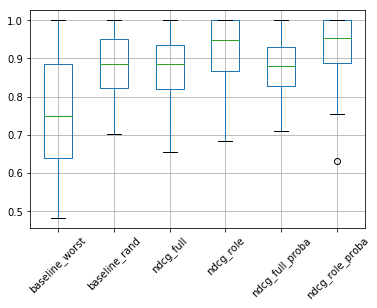

In [10]:
%matplotlib inline
pd.DataFrame(res)[['baseline_worst','baseline_rand','ndcg_full','ndcg_role','ndcg_full_proba','ndcg_role_proba']]\
    .boxplot(figsize=(5,8), rot=45)

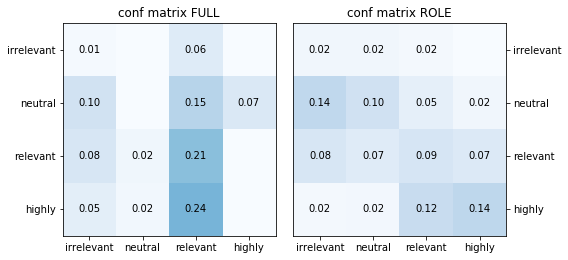

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm as colm
plt.figure(figsize=(8,5))
sub = plt.subplot(121)
normed = conf_matrix_full/conf_matrix_full.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
plt.title('conf matrix FULL')
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed.T[i][j]
        c='%.2f'%v if v>0.005 else ''
        sub.text(i, j, c, va='center', ha='center')



sub = plt.subplot(122)
normed = conf_matrix_role/conf_matrix_role.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
sub.yaxis.tick_right()
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed.T[i][j]
        c='%.2f'%v if v>0.01 else ''
        sub.text(i, j, c, va='center', ha='center')
        
plt.title('conf matrix ROLE')

plt.tight_layout()
plt.show()

# Inter Annotator Agreement

Calculate normalised confusion matrix for each pair of experts. Not additional output is given for those pairs without any overlapping contributions.

This uses Cohen's Kappa ("change of random agreement")
* https://staff.fnwi.uva.nl/r.fernandezrovira/teaching/MoLProject2011/annotation-reliability.pdf

In [56]:
def kappa(ca, cb):
    translationmap = {'irrelevant': 0, 'neutral': 1, 'relevant': 2, 'highly relevant': 3}
    
    # build confusion matrix
    confmat = np.ndarray((4,4))
    for a, b in zip(ca, cb):
        confmat[translationmap[a.lower()]][translationmap[b.lower()]] += 1
    
    s = confmat.sum()
    
    # normalise
    confmat = confmat/s
    
    # expected random agreement (sum over products of row/column sums)
    Ae = (confmat.sum(axis=0)*confmat.sum(axis=1)).sum()
    
    # annotator agreement
    A0 = confmat.diagonal().sum()
    
    # calculate kappa
    k = (A0-Ae)/(1-Ae)
    
    return (confmat, k, s)


experts = ['RATING_EXPERT_1', 'RATING_EXPERT_2', 'RATING_EXPERT_3','RATING_EXPERT_4', 'RATING_EXPERT_5', 'RATING_EXPERT_6','RATING_EXPERT_7', 'RATING_EXPERT_1.1', 'RATING_EXPERT_9','RATING_EXPERT_10']
tmp = []
kmap = np.zeros((10,10))
smap = np.zeros((10,10))
for i,e in enumerate(experts):
    for j in range(i+1, len(experts)):
        cm, k, s = kappa(train[pd.notnull(train[experts[i]])&pd.notnull(train[experts[j]])][experts[i]],
                         train[pd.notnull(train[experts[i]])&pd.notnull(train[experts[j]])][experts[j]])
        kmap[i][j] = k
        smap[i][j] = s
        print(experts[i],'&',experts[j],'| overlap='+str(s),'| k='+str(k))
        if not np.isnan(k):
            print(cm)
            print()
        
        tmp.append({'ca':experts[i],'cb':experts[j], 'k':k,'s':s})
agreement = pd.DataFrame(tmp)

RATING_EXPERT_1 & RATING_EXPERT_2 | overlap=128.0 | k=0.258426966292
[[ 0.0234375  0.0078125  0.         0.       ]
 [ 0.         0.1953125  0.1796875  0.       ]
 [ 0.         0.078125   0.1171875  0.0625   ]
 [ 0.         0.0234375  0.1640625  0.1484375]]

RATING_EXPERT_1 & RATING_EXPERT_3 | overlap=24.0 | k=0.942307692308
[[ 0.29166667  0.          0.          0.        ]
 [ 0.          0.29166667  0.          0.        ]
 [ 0.          0.          0.08333333  0.        ]
 [ 0.          0.          0.04166667  0.29166667]]

RATING_EXPERT_1 & RATING_EXPERT_4 | overlap=35.0 | k=0.533333333333
[[ 0.02857143  0.          0.          0.        ]
 [ 0.02857143  0.08571429  0.05714286  0.        ]
 [ 0.          0.05714286  0.51428571  0.02857143]
 [ 0.          0.          0.08571429  0.11428571]]

RATING_EXPERT_1 & RATING_EXPERT_5 | overlap=11.0 | k=0.0
[[ 0.          0.90909091  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.     

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


In [12]:
agreement

,ca,cb,k,s
0,RATING_EXPERT_1,RATING_EXPERT_2,0.258427,128.0
1,RATING_EXPERT_1,RATING_EXPERT_3,0.942308,24.0
2,RATING_EXPERT_1,RATING_EXPERT_4,0.533333,35.0
3,RATING_EXPERT_1,RATING_EXPERT_5,0.000000,11.0
4,RATING_EXPERT_1,RATING_EXPERT_6,NaN,0.0
5,RATING_EXPERT_1,RATING_EXPERT_7,0.400000,3.0
6,RATING_EXPERT_1,RATING_EXPERT_1.1,-0.055888,23.0
7,RATING_EXPERT_1,RATING_EXPERT_9,NaN,0.0
8,RATING_EXPERT_1,RATING_EXPERT_10,0.060877,8.0
9,RATING_EXPERT_2,RATING_EXPERT_3,NaN,0.0


In [11]:
(agreement['k']*agreement['s']/agreement['s'].sum()).sum()

0.44809992744108257

In [23]:
agreement.describe()

,k,s
count,27.000000,45.000000
mean,0.341679,10.622222
std,0.346240,22.366055
min,-0.055888,0.000000
25%,0.064183,0.000000
50%,0.089241,1.000000
75%,0.537217,12.000000
max,1.000000,128.000000


For a better overview the kappa scores visually for all pairs of annotators. Empty cells indicate, that there are no overlapping ratings. 

The plot on the left shows kappa values, that on the right the number of overlapping ratings.

In [ ]:
vals = np.nan_to_num(smap.T+kmap)
for i in range(smap.shape[0]):
    for j in range(smap.shape[1]):
        print(#"{}({},{}) [{:.2f}]".format(
            "{} {} {:.2f}".format(
            #"%" if not vals[i][j] else "",
            i, j,
            vals[i][j]
            ))

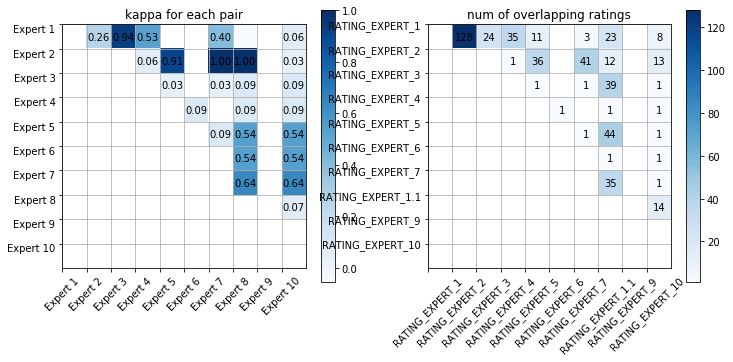

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib2tikz import save as tikz_save

plt.clf()

labs = ["Expert "+str(i+1) for i,_ in enumerate(experts)]

fig = plt.figure(figsize=(12, 5))

sub = fig.add_subplot(1,2,1)
sub.set_title('kappa for each pair')
kmap[kmap==0] = np.nan
im = sub.imshow(kmap, cmap=cm.Blues)
kmap[kmap==np.nan] = 0

ind_array = np.arange(0,10,1)
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c='%.2f'%kmap[y_val][x_val] if kmap[y_val][x_val]>0 else ''
    sub.text(x_val, y_val, c, va='center', ha='center')

sub.set_yticks(np.arange(-0.5, 9.5))
sub.set_yticklabels(labs, va="top")
sub.set_xticks(np.arange(-0.5, 9.5))
sub.set_xticklabels(labs, rotation=45)
sub.grid()

fig.colorbar(im, ax=sub)

sub = fig.add_subplot(1,2,2)
sub.set_title('num of overlapping ratings')
smap[smap==0] = np.nan
im = sub.imshow(smap, cmap=cm.Blues)
smap[smap==np.nan] = 0

ind_array = np.arange(0,10,1)
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c='%.0f'%smap[y_val][x_val] if smap[y_val][x_val]>0 else ''
    sub.text(x_val, y_val, c, va='center', ha='center')

sub.set_yticks(np.arange(-0.5, 9.5))
sub.set_yticklabels(experts)
sub.set_xticks(np.arange(-0.5, 9.5))
sub.set_xticklabels(experts, rotation=45)
sub.grid()
    
fig.colorbar(im, ax=sub)
plt.tight_layout()

plt.show()

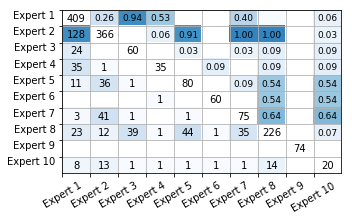

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib2tikz import save as tikz_save

plt.clf()

labs = ["Expert "+str(i+1) for i,_ in enumerate(experts)]

fig = plt.figure(figsize=(5,3))

sub = fig.add_subplot(111)
#sub.set_title('kappa for each pair')
kmap[kmap==0] = np.nan
im = sub.imshow(kmap, cmap=cm.Blues, vmax=1.5, aspect='auto')
kmap[kmap==np.nan] = 0

ind_array = np.arange(0,10,1)
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c='%.2f'%kmap[y_val][x_val] if kmap[y_val][x_val]>0 else ''
    sub.text(x_val, y_val, c, va='center', ha='center', fontsize=9)

sub.set_yticks(np.arange(-0.5, 9.5))
sub.set_yticklabels(labs, va="top")
sub.set_xticks(np.arange(-0.5, 9.5))
sub.set_xticklabels(labs, rotation=30)
sub.grid()

smap = smap.T
smap[smap==0] = np.nan
im = sub.imshow(smap, cmap=cm.Blues, vmax=200,  aspect='auto')
#sub.clim(-4,4)
smap[smap==np.nan] = 0

ind_array = np.arange(0,10,1)
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c='%.0f'%smap[y_val][x_val] if smap[y_val][x_val]>0 else ''
    sub.text(x_val, y_val, c, va='center', ha='center', fontsize=10)
smap = smap.T

for i, expert in enumerate(experts):
    sub.text(i, i, train[pd.notnull(train[expert])].shape[0], va='center', ha='center', fontsize=10)

#plt.tight_layout()
plt.savefig(os.path.join('/home/tim/Uni/HPI/workspace/FEII/paper', 'iaa.pdf'), bbox_inches='tight')

plt.show()

This small overview shows, that most tuples are only rated by one expert. ~40% of them are rated by two experts, only few from more than that.

In [26]:
train[['num_experts', 'rating_avg',]].groupby('num_experts').count()

,rating_avg
num_experts,
0,3
1,567
2,377
3,28


# Feature Selection
## Information Gain

In [82]:
d = 6
print(5/d)
print(5//d)

0.8333333333333334
0


In [33]:
def log(x, base):
    return np.log(x)/np.log(base)

def entropy(x):
    s = 0
    for v in set(x):
        s += (len(x[x==v])/len(x))*np.log2(len(x[x==v])/len(x))
    return -s

def information_gain(X, y, a, bins=None):
    X_a = X[:,a]
    
    if bins is not None:
        X_a = (X_a - X_a.min())//((X_a.max()-X_a.min())/bins).clip(max=bins-1)
    
    s = 0
    for v in set(X_a):
        s += (len(X_a[X_a==v])/len(X)) * entropy(y[X_a==v])
        
    return entropy(y) - s

In [34]:
from sklearn.feature_selection  import chi2
#tmpmodel = IDFscorer(frm=train, pipln=[('lem', Lemmatiser())])
def calIG(kv):
    k,v = kv
    return (v, information_gain(X.toarray(), y, k))

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}

np.set_printoptions(suppress=True)

tmpmodel = IDFscorer(frm=train[mask],
                     train_size=0.9, 
                     pipln=[
                            ('lem', Lemmatiser()),
                            ('vect', CountVectorizer(**cv_par)),
                            ('tfidf', TfidfTransformer(**tt_par))
                     ])
tmpmodel.short_setinfo()

X = tmpmodel.fit_transform(frm=tmpmodel.trainfrm)
y = tmpmodel.get_target(frm=tmpmodel.trainfrm)
dic = {i: w for w,i in tmpmodel.clf.named_steps['vect'].vocabulary_.items()}

from multiprocessing import Pool

print('X shape', X.shape)

p = Pool(7)
gains = p.map(calIG, dic.items())
p.close()

out = '<table><tr><th>Information Gain</th><th>chi2 p-Value</th></tr>'
out+= '<tr><td>' + pp(sorted(gains, key=lambda tup: tup[1], reverse=True)) + \
     '</td><td>' + pp(sorted(zip(dic.values(), chi2(X,y)[1]), key=lambda tup: tup[1], reverse=True)) + \
     '</td></tr>'
out+= '</table>'

    
HTML(out)

Items in training set: 880 (90.91%)
Items in testing set: 88
 = 968
Number of documents: 25 total, 23 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),87.00,259.00,253.00,281.00
Test (abs),2.00,47.00,27.00,12.00
Train (rel),0.10,0.29,0.29,0.32
Test (rel),0.02,0.53,0.31,0.14
diff,0.08,-0.24,-0.02,0.18


RATING_EXPERT_1 gave 406 ratings, in train: 359, in test: 47.
RATING_EXPERT_2 gave 366 ratings, in train: 282, in test: 84.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 44, in test: 36.
RATING_EXPERT_6 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 222, in test: 0.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 16, in test: 4.
X shape (880, 317)


Information Gain,chi2 p-Value


In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
class SyntaxFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, asfrm=False, n_workers=6):
        self.asfrm = asfrm
        self.n_workers = n_workers
        
    def fit(self, X, y=None):
        return self

    def transform(self, frm):
        p = Pool(self.n_workers)
        Xd = pd.DataFrame(p.map(self._features, frm.iterrows()), index=frm.index)
        p.close()
        
        if (self.asfrm):
            return Xd
        
        return Xd.as_matrix()
    
    def _features(self, row):
        _, row = row
        raw = row['THREE_SENTENCES']
        clean = row['clean']
        counts_r = Counter(raw.split())
        counts_c = Counter(clean.split())
        ret = {
            'num_chars': len(raw),
            'num_words': len(raw.split()),
            'num_upper_chars': sum(1 for c in raw if c.isupper()),
            'num_upper_words': sum(1 for w in raw.split() if w[0].isupper()),
            'ratio_upper_chars': sum(1 for c in raw if c.isupper())/len(raw),
            'ratio_upper_words': sum(1 for w in raw.split() if w[0].isupper())/len(raw.split()),
            'mean_word_len': np.mean([len(w) for w in raw.split()]),
            'num_word_repetitions_raw': len({k:v for k,v in counts_r.items() if v>1}),
            'num_word_repetitions_clean': len({k:v for k,v in counts_c.items() if v>1}),
            'num_word_repetitions_raw_rel': len({k:v for k,v in counts_r.items() if v>1})/len(raw.split()),
            'num_word_repetitions_clean_rel': len({k:v for k,v in counts_c.items() if v>1})/len(clean.split()),
        }
        return ret
    
p = Pipeline([('ff', SyntaxFeatures(asfrm=True))])

frm = tmpmodel.trainfrm

Xd = p.transform(frm) 
X = Xd.as_matrix()
y = tmpmodel.get_target(frm)

print('X shape', X.shape)
print('y shape', y.shape)

def calcIG(kv):
    a, k = kv
    return (k, information_gain(X, y, a, bins=5))

p = Pool(7)
gains = p.map(calcIG, enumerate(Xd.columns))
p.close()

print(list(enumerate(Xd.columns)))

out = '<table><tr><th>Information Gain</th><th>chi2 p-Value</th></tr>'
out+= '<tr><td>' + pp(sorted(gains, key=lambda tup: tup[1], reverse=True)) + \
     '</td><td>' + pp(sorted(zip(Xd.columns, chi2(X,y)[1]), key=lambda tup: tup[1], reverse=True)) + \
     '</td></tr>'
out+= '</table>'

    
HTML(out)

#print('Information Gain')
#sorted(gains, key=lambda tup: tup[1], reverse=True)

X shape (880, 11)
y shape (880,)
[(0, 'mean_word_len'), (1, 'num_chars'), (2, 'num_upper_chars'), (3, 'num_upper_words'), (4, 'num_word_repetitions_clean'), (5, 'num_word_repetitions_clean_rel'), (6, 'num_word_repetitions_raw'), (7, 'num_word_repetitions_raw_rel'), (8, 'num_words'), (9, 'ratio_upper_chars'), (10, 'ratio_upper_words')]


Information Gain,chi2 p-Value
"[('num_chars', 1.2103106905645866), ('num_words', 0.64225223525288966), ('num_upper_chars', 0.37188675276785133), ('num_upper_words', 0.28093273196275104), ('num_word_repetitions_raw', 0.28076946361514277), ('ratio_upper_words', 0.20335950365275712), ('num_word_repetitions_clean', 0.19624928363184502), ('num_word_repetitions_raw_rel', 0.10993803614814923), ('num_word_repetitions_clean_rel', 0.098074538168391401), ('ratio_upper_chars', 0.048077519386517942), ('mean_word_len', 0.039348710417463906)]","[('num_word_repetitions_clean_rel', 0.92293367081925948), ('num_word_repetitions_raw_rel', 0.91301376436696413), ('mean_word_len', 0.89346346049103742), ('ratio_upper_chars', 0.63656461034873812), ('ratio_upper_words', 0.029182019557197902), ('num_upper_words', 9.6302040388005513e-18), ('num_word_repetitions_clean', 6.4531744244903722e-24), ('num_upper_chars', 9.6561970674437864e-26), ('num_word_repetitions_raw', 2.1205276535551768e-41), ('num_chars', 0.0), ('num_words', 0.0)]"


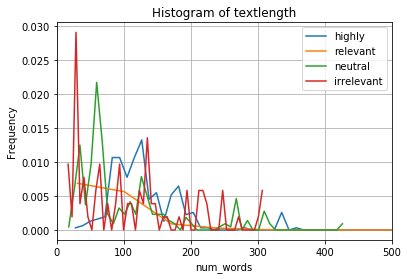

In [42]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d

bins = 20
# tmp = pd.DataFrame({'rating':train['rating'], 'len':train['THREE_SENTENCES'].str.len()})

col = 8

for i, a in enumerate(['highly', 'relevant',  'neutral','irrelevant']):
    x = X[:,col][y==abs(3-i)]
    n, bins = np.histogram(x, 50, normed=1)

    f = interp1d(bins[:-1], n, kind='cubic')
    l = plt.plot(bins[:-1], f(bins[:-1]), label=a)

plt.xlabel(Xd.columns[col])
plt.ylabel('Frequency')
plt.title('Histogram of textlength')
plt.xlim(0,500)
plt.legend()
plt.grid(True)

## RFE

In [235]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.utils import compute_class_weight

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'loss': 'log', #['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
    'penalty': 'l2',
    'shuffle': True,
    'alpha': 1e-4,
    'n_iter': 15,
    'random_state': 42,
    'class_weight': 'balanced'
}

tmpmodel = IDFscorer(frm=train[mask],grp='trustee', train_size=0.7, cv_par=cv_par, tt_par=tt_par, clf_par=clf_par)
tmpmodel.short_setinfo()

prep = Pipeline([('vect', CountVectorizer(**cv_par)),
             ('tfidf', TfidfTransformer(**tt_par))
            ])

X_raw = list(tmpmodel.trainfrm['clean']) + list(tmpmodel.testfrm['clean'])
X = prep.fit_transform(X_raw)
y = np.array(list(tmpmodel.trainfrm['rating'].map(tmpmodel.ratingmap)) + \
             list(tmpmodel.testfrm['rating'].map(tmpmodel.ratingmap)))

_, M = prep.named_steps['vect']._count_vocab(X_raw, True)
_, Mtr = prep.named_steps['vect']._count_vocab(list(tmpmodel.trainfrm['clean']), True)
_, Mte = prep.named_steps['vect']._count_vocab(list(tmpmodel.testfrm['clean']), True)

print(X.shape)
print(y.shape)

clf = SGDClassifier(**clf_par)

selector = RFE(clf, 100, step=1)
selector = selector.fit(X, y)

dic = {i: w for w,i in prep.named_steps['vect'].vocabulary_.items()}

tfs = np.sum(M, axis=0).A1
dfs = np.bincount(M.indices, minlength=M.shape[1])
class_weights = dict((key, value) for key, value in enumerate(compute_class_weight('balanced', list(set(tmpmodel.trainfrm['rating'].map(tmpmodel.ratingmap))), np.array(tmpmodel.trainfrm['rating'].map(tmpmodel.ratingmap)))))

print('num features selected:', selector.n_features_)
print('document frequencies are class_weight adjusted!')
print(class_weights)
for a in np.argsort(abs(np.array(selector.ranking_)-max(selector.ranking_))):
    print('{}sup: {:>3} irr|neu|rel|hig {:>3}|{:>3}|{:>3}|{:>3} idf: {:.3f} {}'.format(
                                    '*' if not selector.support_[a] else ' ', # in selection y/n
                                    selector.ranking_[a], # support
                                    int(class_weights.get(0,0)*np.bincount(M[y==0].indices, minlength=M[y==0].shape[1])[a]),
                                    int(class_weights.get(1,0)*np.bincount(M[y==1].indices, minlength=M[y==1].shape[1])[a]) or 0,
                                    int(class_weights.get(2,0)*np.bincount(M[y==2].indices, minlength=M[y==2].shape[1])[a]) or 0,
                                    int(class_weights.get(3,0)*np.bincount(M[y==3].indices, minlength=M[y==3].shape[1])[a]) or 0,
                                    prep.named_steps['tfidf'].idf_[a], # IDF
                                    dic[a])) # word

Items in training set: 845
Items in testing set: 126
 = 971
Rating distribution in training set: Counter({'irrelevant': 568, 'neutral': 114, 'highly': 108, 'relevant': 55})
Rating distribution in testing set: Counter({'neutral': 49, 'highly': 47, 'relevant': 24, 'irrelevant': 6})
Rating distribution overall: Counter({'irrelevant': 574, 'neutral': 163, 'highly': 155, 'relevant': 79})
RATING_EXPERT_1 gave 177 ratings, in train: 123, in test: 54.
RATING_EXPERT_2 gave 145 ratings, in train: 97, in test: 48.
RATING_EXPERT_3 gave 19 ratings, in train: 14, in test: 5.
RATING_EXPERT_5 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_6 gave 25 ratings, in train: 19, in test: 6.
RATING_EXPERT_7 gave 25 ratings, in train: 17, in test: 8.
RATING_EXPERT_1.1 gave 81 ratings, in train: 61, in test: 20.
RATING_EXPERT_9 gave 50 ratings, in train: 35, in test: 15.
RATING_EXPERT_10 gave 3 ratings, in train: 2, in test: 1.
(971, 412)
(971,)
num features selected: 100
document frequencies are class_w

In [185]:
df0 = np.sum(np.bincount(M[y==0].indices, minlength=M[y==0].shape[1]))
df1 = np.sum(np.bincount(M[y==1].indices, minlength=M[y==1].shape[1]))
df2 = np.sum(np.bincount(M[y==2].indices, minlength=M[y==2].shape[1]))
df3 = np.sum(np.bincount(M[y==3].indices, minlength=M[y==3].shape[1]))

-2.7027459722928278

## t-SNE

Items in training set: 396
Items in testing set: 21
 = 417
Rating distribution in training set: Counter({'neutral': 155, 'highly': 147, 'relevant': 75, 'irrelevant': 19})
Rating distribution in testing set: Counter({'neutral': 8, 'highly': 8, 'relevant': 4, 'irrelevant': 1})
Rating distribution overall: Counter({'neutral': 163, 'highly': 155, 'relevant': 79, 'irrelevant': 20})
RATING_EXPERT_1 gave 177 ratings, in train: 165, in test: 12.
RATING_EXPERT_2 gave 145 ratings, in train: 138, in test: 7.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 23, in test: 2.
RATING_EXPERT_7 gave 25 ratings, in train: 23, in test: 2.
RATING_EXPERT_1.1 gave 81 ratings, in train: 78, in test: 3.
RATING_EXPERT_9 gave 50 ratings, in train: 48, in test: 2.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.


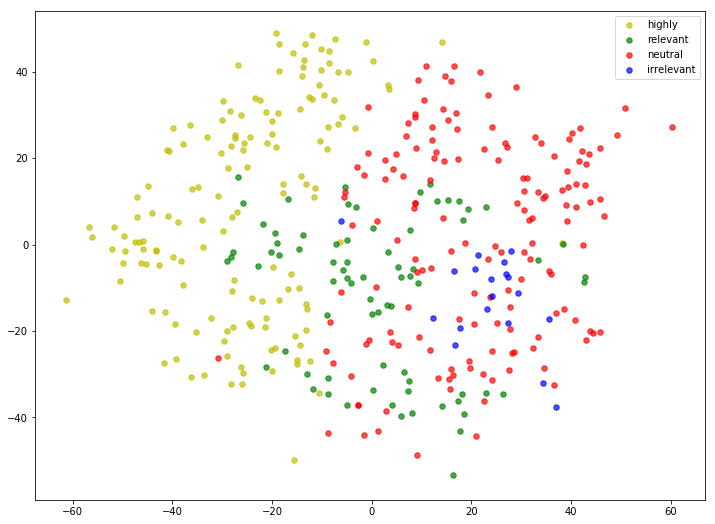

In [27]:
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.utils import compute_class_weight
import matplotlib.pyplot as plt

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'n_components': 2, 
    'random_state': 0,
    #'init': 'pca',
    'method': 'exact'
}

np.set_printoptions(suppress=True)

tmpmodel = IDFscorer(frm=train[mask],
                     grp='trustee', 
                     train_size=0.95, 
                     pipln=[('vect', CountVectorizer(**cv_par)),
                            ('tfidf', TfidfTransformer(**tt_par)),
                            ('clf', TSNE(**clf_par))
                     ])
tmpmodel.short_setinfo()
#tmpmodel.fit_transform()
y = np.array(tmpmodel.get_target(frm=tmpmodel.trainfrm))

plt.figure(figsize=(12,9))
_, X_red = tmpmodel.fit_transform(frm=tmpmodel.trainfrm)

plt.scatter(X_red[y==3][:,0], X_red[y==3][:,1], marker='o', color='y', alpha=0.7, s = 30, label='highly')
plt.scatter(X_red[y==2][:,0], X_red[y==2][:,1], marker='o', color='g', alpha=0.7, s = 30, label='relevant')
plt.scatter(X_red[y==1][:,0], X_red[y==1][:,1], marker='o', color='r', alpha=0.7, s = 30, label='neutral')
plt.scatter(X_red[y==0][:,0], X_red[y==0][:,1], marker='o', color='b', alpha=0.7, s = 30, label='irrelevant')

plt.legend(loc='upper right')

plt.show()

## LSA

Items in training set: 396
Items in testing set: 21
 = 417
Rating distribution in training set: Counter({'neutral': 155, 'highly': 147, 'relevant': 75, 'irrelevant': 19})
Rating distribution in testing set: Counter({'neutral': 8, 'highly': 8, 'relevant': 4, 'irrelevant': 1})
Rating distribution overall: Counter({'neutral': 163, 'highly': 155, 'relevant': 79, 'irrelevant': 20})
RATING_EXPERT_1 gave 177 ratings, in train: 170, in test: 7.
RATING_EXPERT_2 gave 145 ratings, in train: 141, in test: 4.
RATING_EXPERT_3 gave 19 ratings, in train: 18, in test: 1.
RATING_EXPERT_5 gave 9 ratings, in train: 7, in test: 2.
RATING_EXPERT_6 gave 25 ratings, in train: 23, in test: 2.
RATING_EXPERT_7 gave 25 ratings, in train: 24, in test: 1.
RATING_EXPERT_1.1 gave 81 ratings, in train: 76, in test: 5.
RATING_EXPERT_9 gave 50 ratings, in train: 47, in test: 3.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
[ 0.03438845  0.10274323]
0.137131680989
components shape: (2, 579)


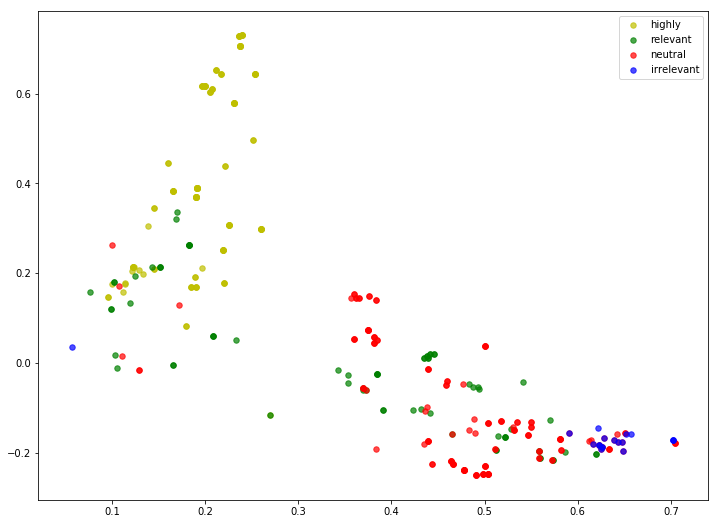

In [29]:
%matplotlib inline

from sklearn.utils import compute_class_weight
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

cv_par = {
    'ngram_range': (1, 3),
    'min_df': 0.05,
    'max_df': 0.7,
    'stop_words': 'english'
}
tt_par = {
    'use_idf': True,
    'sublinear_tf': True,
}
clf_par = {
    'n_components':2, 
    'n_iter':7, 
    'random_state': 42
}

np.set_printoptions(suppress=True)

tmpmodel = IDFscorer(frm=train[mask],
                     grp='trustee', 
                     train_size=0.95, 
                     pipln=[('vect', CountVectorizer(**cv_par)),
                            ('tfidf', TfidfTransformer(**tt_par)),
                            ('clf', TruncatedSVD(**clf_par))
                     ])
tmpmodel.short_setinfo()

y = np.array(tmpmodel.get_target(frm=tmpmodel.trainfrm))

plt.figure(figsize=(12,9))
_, X_red = tmpmodel.fit_transform(frm=tmpmodel.trainfrm)

print(tmpmodel.clf.named_steps['clf'].explained_variance_ratio_) 
print(tmpmodel.clf.named_steps['clf'].explained_variance_ratio_.sum()) 
dic = {i: w for w,i in tmpmodel.clf.named_steps['vect'].vocabulary_.items()}
class_weights = dict((key, value) for key, value in enumerate(compute_class_weight('balanced', list(set(tmpmodel.trainfrm['rating'].map(tmpmodel.ratingmap))), np.array(tmpmodel.trainfrm['rating'].map(tmpmodel.ratingmap)))))
print('components shape:', tmpmodel.clf.named_steps['clf'].components_.shape)

plt.scatter(X_red[y==3][:,0], X_red[y==3][:,1], marker='o', color='y', alpha=0.7, s = 30, label='highly')
plt.scatter(X_red[y==2][:,0], X_red[y==2][:,1], marker='o', color='g', alpha=0.7, s = 30, label='relevant')
plt.scatter(X_red[y==1][:,0], X_red[y==1][:,1], marker='o', color='r', alpha=0.7, s = 30, label='neutral')
plt.scatter(X_red[y==0][:,0], X_red[y==0][:,1], marker='o', color='b', alpha=0.7, s = 30, label='irrelevant')

plt.legend(loc='upper right')

plt.show()

In [ ]:
# from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_features = 1000
n_topics =4
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
#dataset = fetch_20newsgroups(shuffle=True, random_state=1,
#                             remove=('headers', 'footers', 'quotes'))
#data_samples = dataset.data[:n_samples]
#data_samples = list(train[mask&((train['grp']=='issuer')|(train['grp']=='affiliate')|(train['grp']=='trustee'))]['THREE_SENTENCES'])
data_samples = list(train[mask]['THREE_SENTENCES'])
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (len(train[mask]), n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (len(train[mask]), n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

In [47]:
tf_vectorizer.transform([row['THREE_SENTENCES']])

<1x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [57]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

target_names = ['irrelevant','neutral','relevant','highly']
print(classification_report(y, yp, target_names=target_names))

confusion_matrix(y, yp)

             precision    recall  f1-score   support

 irrelevant       0.14      0.19      0.16        89
    neutral       0.71      0.70      0.70       306
   relevant       0.34      0.42      0.37       280
     highly       0.36      0.24      0.29       293

avg / total       0.44      0.43      0.43       968



array([[ 17,  26,   9,  37],
       [ 21, 213,  29,  43],
       [ 59,  59, 117,  45],
       [ 27,   2, 193,  71]])

## WordEmbedding doc2vec

In [39]:
from gensim.models import Doc2Vec
from bs4 import BeautifulSoup
from gensim.models.doc2vec import LabeledSentence
from multiprocessing import Pool
import re

reportsdir = '/home/tim/Uni/HPI/workspace/FEII/full_reports/'
cleantext = ""
for cnt, file in enumerate(os.listdir(reportsdir)):
    if file.endswith('.html'):
        print('reading: '+file)
        with open(reportsdir+file,"r",encoding='utf-8', errors='ignore') as f:
            tmp = BeautifulSoup(f.read(), "html5lib").text
            cleantext += re.sub(r'[^a-zA-Z\. ]+', '', str(tmp).lower())
        
    if cnt > 5:
        break

print('extracting sentences...')
sents = [str(s).lower() for s in nlp(cleantext).sents]

reading: ALLY_2016.html
reading: ALLY_2014.html
reading: CAPITAL-ONE_2013.html
extracting sentences...


In [40]:
labsents = [LabeledSentence(words=s.split(), tags=['SENT_'+str(i)]) for i,s in enumerate(sents)]

In [41]:
model = Doc2Vec(size=52, window=10, min_count=5, 
                workers=6, alpha=0.025, min_alpha=0.025,
                batch_words=100, dm=0) 
model.build_vocab(labsents)
for epoch in range(10):
    print(epoch)
    model.train(labsents)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

0
1
2
3
4
5
6
7
8
9


In [20]:
for epoch in range(10,20):
    print(epoch)
    model.train(labsents)

10
11
12
13
14
15
16
17
18
19


### Vis

loan


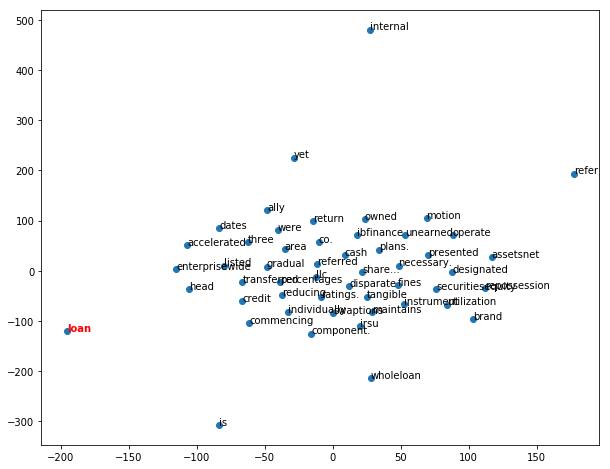

In [53]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

word = 'loan'
wv = [model.infer_vector(word)]
vocabulary = [word]

for w, _ in model.most_similar(word, topn=50):
    wv.append(model.infer_vector(w))
    vocabulary.append(w)

Y = tsne.fit_transform(wv)

plt.figure(figsize=(10,8))
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(vocabulary, Y[:, 0], Y[:, 1]):
    if label == word:
        print(label)
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', color='r', weight='heavy')
    else:
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

### stats

In [12]:
print('words:', len(cleantext.split()))
print('sentences:',len(sents))

words: 362039
sentences: 12435


In [12]:
model.infer_vector('parallel')

array([ 0.1324286 ,  0.02926077,  0.07249232, -0.04954508,  0.09120761,
        0.12916185, -0.25111145,  0.08303283, -0.25890023,  0.10957912,
        0.05741746, -0.06077867,  0.10863452,  0.03701539,  0.0779966 ,
        0.08653381, -0.21417719, -0.22063099,  0.24699043, -0.032033  ,
       -0.23641597,  0.04627877, -0.09769927, -0.34353784,  0.12425541,
       -0.12333019, -0.13142675, -0.01169958, -0.13865146,  0.15821451,
        0.14549077,  0.0857148 , -0.18085979, -0.01692883, -0.06822971,
        0.02009979, -0.03242321, -0.10081129,  0.09552928, -0.24512164,
       -0.19692472, -0.166612  ,  0.02484448, -0.05448866, -0.34609845,
        0.23767689, -0.14592008,  0.16958061,  0.14278269, -0.29621407,
       -0.139797  , -0.09647302], dtype=float32)

In [14]:
model.most_similar('ally',topn=20)

[('estimation.', 0.554520845413208),
 ('parallel', 0.47263625264167786),
 ('around', 0.46070796251296997),
 ('instrument', 0.4330580532550812),
 ('impairment', 0.4305986166000366),
 ('contract,', 0.4216669499874115),
 ('referred', 0.4142991006374359),
 ('no.', 0.4058770537376404),
 ('internet', 0.39984822273254395),
 ('2012,', 0.39417386054992676),
 ('accretable', 0.386094868183136),
 ('co.', 0.38282108306884766),
 ('estimates,', 0.3798235058784485),
 ('swaptions', 0.3746770918369293),
 ('well', 0.3722466230392456),
 ('(11', 0.36989203095436096),
 ('mergers', 0.3685528337955475),
 ('carpenter', 0.36629849672317505),
 ('significant', 0.3646567761898041),
 ('capitalize', 0.3619738221168518)]

In [238]:
from pprint import pprint 

se = 'As of December 31, 2013 , the capital of each of these banking subsidiaries exceeded the minimum legal capital requirements set by those regulatory authorities.'
tmp = model.infer_vector(se.lower().split())
print('Model:', model)
print('inferred vector:', tmp)
print()
print(se.lower())
pprint(model.most_similar([tmp]))

for sn, fl in model.docvecs.most_similar([tmp]):
    print(">> {:.4f} >> \n{}".format(fl, ' '.join(sents[int(sn[5:])].split())))

Model: Doc2Vec(dm/m,d2,n5,w10,mc5,s0.001,t6)
inferred vector: [ 0.22850589  0.09040408]

as of december 31, 2013 , the capital of each of these banking subsidiaries exceeded the minimum legal capital requirements set by those regulatory authorities.
[('originally', 0.9999997019767761),
 ('excluded', 0.9999954700469971),
 ('properties', 0.9999945163726807),
 ('rights', 0.999993622303009),
 ('charged', 0.9999935626983643),
 ('addition', 0.9999926686286926),
 ('eurodollar', 0.999988317489624),
 ('approximates', 0.9999845027923584),
 ('court', 0.9999825954437256),
 ('lessee', 0.9999793767929077)]
>> 1.0000 >> 
the average balance of commercial banking loans held for investment, excluding the carrying value of acquired loans, was $35.1 billion, $30.8 billion and $29.1 billion in 2012, 2011 and 2010, respectively.
>> 1.0000 >> 
the loss sharing amounts due from kohls are recorded as a reduction in our provision for credit losses in our consolidated statements of income.
>> 1.0000 >> 
we are 

In [266]:
import random
while True:
    word = random.choice(model.wv.index2word)
    if model.wv.vocab[word].count > 10:
        break

print("most similar words for '%s' (%d occurences)" % (word, model.wv.vocab[word].count))

print(str(model.most_similar(word, topn=20)).replace('), ','),\n'))

most similar words for 'submit' (31 occurences)
[('company-run', 0.719616174697876),
('frb.', 0.6296055316925049),
('submitted', 0.5708451867103577),
('declare', 0.5196664929389954),
('expects', 0.5091995596885681),
('stress', 0.49763205647468567),
('purpose,', 0.4951915740966797),
('adequacy', 0.48403048515319824),
('test', 0.48100733757019043),
('compare', 0.47804659605026245),
('(131)', 0.46424561738967896),
('tests', 0.46380940079689026),
('discretionary', 0.4479648172855377),
('contribute', 0.4461285471916199),
('23%', 0.4386689066886902),
('parent', 0.4366167485713959),
('plan,', 0.43326708674430847),
('presentation.', 0.4303516149520874),
('261', 0.42970341444015503),
('staff.', 0.4267594814300537)]


In [ ]:
sections = model.accuracy('questions-words.txt')
correct, incorrect = len(sections[-1]['correct']), len(sections[-1]['incorrect'])
print('%s: %0.2f%% correct (%d of %d)' % (model, float(correct*100)/(correct+incorrect), correct, correct+incorrect))

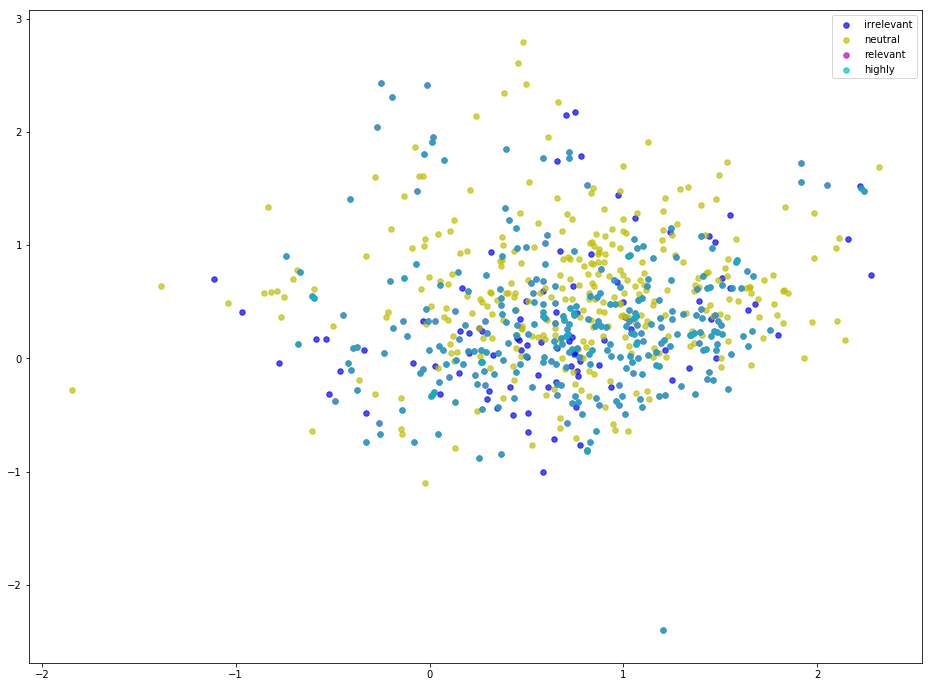

In [209]:
%matplotlib inline

import matplotlib.pyplot as plt

X = list(train['THREE_SENTENCES'])
y = np.array(train['rating'].map(rating_map2))

X_red = np.array([model.infer_vector(se.lower().split()) for se in X])

plt.figure(figsize=(16,12))
#X_red = svd.transform(X)

plt.scatter(X_red[y==0][:,0],
            X_red[y==0][:,1],
            # the marker as
            marker='o',
            # the color
            color='b',
            # the alpha
            alpha=0.7,
            # with size
            s = 30,
            # labelled this
            label='irrelevant')

plt.scatter(X_red[y==1][:,0],
            X_red[y==1][:,1],
            # the marker as
            marker='o',
            # the color
            color='y',
            # the alpha
            alpha=0.7,
            # with size
            s = 30,
            # labelled this
            label='neutral')

plt.scatter(X_red[y==2][:,0],
            X_red[y==2][:,1],
            # the marker as
            marker='o',
            # the color
            color='m',
            # the alpha
            alpha=0.7,
            # with size
            s = 30,
            # labelled this
            label='relevant')

plt.scatter(X_red[y==2][:,0],
            X_red[y==2][:,1],
            # the marker as
            marker='o',
            # the color
            color='c',
            # the alpha
            alpha=0.7,
            # with size
            s = 30,
            # labelled this
            label='highly')

# and a legend
plt.legend(loc='upper right')

plt.show()

# Embedding based training

In [19]:
from gensim.models import Doc2Vec
from bs4 import BeautifulSoup
from gensim.models.doc2vec import LabeledSentence
from multiprocessing import Pool

reportsdir = '/home/tim/Uni/HPI/workspace/FEII/full_reports/'
cleantext = ""
for cnt, file in enumerate(os.listdir(reportsdir)):
    if file.endswith('.html'):
        print('reading: '+file)
        with open(reportsdir+file,"r",encoding='utf-8', errors='ignore') as f:
            cleantext += BeautifulSoup(f.read(), "html5lib").text
        
    #if cnt > 1:
    #   break

print('extracting sentences...')
sents = [str(s).lower() for s in nlp(cleantext).sents]

print('words:', len(cleantext.split()))
print('sentences:',len(sents))

labsents = [LabeledSentence(words=s.split(), tags=['SENT_'+str(i)]) for i,s in enumerate(sents)]

embedding = Doc2Vec(size=40, window=10, min_count=5, 
                workers=6, alpha=0.025, min_alpha=0.025,
                batch_words=100, dm=0) 
embedding.build_vocab(labsents)
for epoch in range(20):
    print(epoch)
    embedding.train(labsents)
    embedding.alpha -= 0.002  # decrease the learning rate
    embedding.min_alpha = embedding.alpha  # fix the learning rate, no decay

reading: ALLY_2016.html
reading: ALLY_2014.html
reading: CAPITAL-ONE_2013.html
reading: JPM_2016.html
reading: MORGAN-STANLEY_2015.html
reading: FIFTH-THIRD_2015.html
reading: PNC_2014.html
reading: NORTHERN-TRUST_2013.html
reading: FIFTH-THIRD_2014.html
reading: DISCOVER_2014.html
reading: SUNTRUST_2013.html
reading: STATE-STREET_2014.html
reading: BANK-OF-AMERICA_2013.html
reading: COMERICA_2016.html
reading: SUNTRUST_2016.html
reading: MT_2013.html
reading: MT_2015.html
reading: BANK-OF-AMERICA_2015.html
reading: STATE-STREET_2016.html
reading: AMERICAN-EXPRESS_2015.html
reading: PNC_2016.html
extracting sentences...
words: 1826860
sentences: 62379
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [67]:
# from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_fscore_support

clf_par = {
    'loss': 'log', #['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
    'penalty': 'l2',
    'shuffle': True,
    'alpha': 1e-4,
    'n_iter': 15,
    'random_state': 42,
    'class_weight': 'balanced'
}

class Embedder(BaseEstimator, TransformerMixin):
    def __init__(self, embedding, sentence_col='THREE_SENTENCES'):
        self.embedding = embedding
        self.col = sentence_col
        self.esize = self.embedding.vector_size
        self.num_sents = 3

    def fit(self, x, y=None):
        return self

    def transform(self, frm):
        X = []
        for i, row in frm.iterrows():
            sents = [str(s).lower() for s in nlp(row[self.col]).sents]
            vecs = [self.embedding.infer_vector(se.lower().split()) for se in sents][:self.num_sents]
            while len(vecs) < self.num_sents:
                vecs.append(list(np.zeros((self.esize,))))
            X.append(np.array(vecs).reshape((self.num_sents * self.esize, )))
            
        return X


conf_matrix_role = np.zeros((4,4))
conf_matrix_full = np.zeros((4,4))

# holer for stats
res = {
    'baseline_rand': [],
    'baseline_worst': [],
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
    'acc_role': [],
    'acc_full': [],
    'f1_role': [],
    'f1_full': []
}
macro_res = {
    'ndcg_role': [],
    'ndcg_full': [],
    'ndcg_role_proba': [],
    'ndcg_full_proba': [],
}

def pipln():
    if True:
        return [
            ('emb', Embedder(embedding)),
            ('clf', SGDClassifier(**clf_par))
        ]
    
    return [
        ('union', FeatureUnion(
            transformer_list=[
                ('syntax', Pipeline([
                    ('feats', SyntaxFeatures()),
                ])),
                ('bow', Pipeline([
                    ('lem', Lemmatiser()),
                    ('vect', CountVectorizer(**cv_par)),
                    ('tfidf', TfidfTransformer(**tt_par))
                ]))
            ],
            transformer_weights={
                'syntax': 1,
                'bow': 1
            },
        )),
        ('clf', SGDClassifier(**clf_par))
    ]

ceiter = 2
for crosseval in range(ceiter):
    print("\n\n==========================================================================")
    print("===                      CROSSEVAL ITERATION " + str(crosseval+1)+"/"+str(ceiter) + "                     =====")
    print("==========================================================================\n\n")
 
    scores_role = []
    scores_full = []
    scores_role_proba = []
    scores_full_proba = []
    
    # prepare model for full set over all roles classifying relevance
    svmfullmodel = IDFscorer(frm=train[mask], train_size=0.7, max_docsplit_iter=20,
                             pipln=pipln())
    svmfullmodel.short_setinfo()
    svmfullmodel.establish_baseline()
    svmfullmodel.fit()

    # run evaluation for each role
    for role in roles.keys():
        print('=== '+role.upper()+' ======')

        svmmodel = IDFscorer(frm=train[mask], grp=role,train_size=0.7, max_docsplit_iter=20,
                             pipln=pipln())
        svmmodel.short_setinfo()

        bl1, bl2 = svmmodel.establish_baseline(include_test=True, include_train=False)
        res['baseline_rand'].append(bl2)
        res['baseline_worst'].append(bl1)

        svmmodel.fit()

        # get predictions from model trained on role
        pred_role, pred_proba_role = svmmodel.predict(svmmodel.testfrm)

        # get predictions from model trained on all
        pred_full, pred_proba_full = svmfullmodel.predict(svmmodel.testfrm)

        score_role = np.sum(pred_proba_role * np.array([1,2,3,4]), axis=1)
        score_full = np.sum(pred_proba_full * np.array([1,2,3,4]), axis=1)

        # calculate accuracy 
        testtarget = svmmodel.get_target()
        res['acc_role'].append(np.mean(pred_role == testtarget))
        print('Accuracy | role :', np.mean(pred_role == testtarget))
        res['acc_full'].append(np.mean(pred_full == testtarget))
        print('Accuracy | full :', np.mean(pred_full == testtarget))

        _,_,f1,supp = precision_recall_fscore_support(testtarget, pred_full,labels=[0,1,2,3])
        res['f1_full'].append((f1*supp).sum()/supp.sum())
        _,_,f1,supp = precision_recall_fscore_support(testtarget, pred_role,labels=[0,1,2,3])
        res['f1_role'].append((f1*supp).sum()/supp.sum())

        # print classification report
        print(metrics.classification_report(testtarget, pred_full,
                                            labels=[0,1,2,3],
                                            target_names=list(rating_map2.keys())))

        # print confusion matrix
        conf_matrix_role += np.array(metrics.confusion_matrix(testtarget, pred_role, labels=[0,1,2,3]))
        cm = metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3])
        conf_matrix_full += np.array(cm)
        print(cm)
        #print(metrics.confusion_matrix(testtarget, pred_full, labels=[0,1,2,3]))

        # add scores to full list
        score_role_tmp = list(zip(list(svmmodel.testfrm.index), pred_role))
        scores_role += score_role_tmp
        score_full_tmp = list(zip(list(svmmodel.testfrm.index), pred_full))
        scores_full += score_full_tmp

        # add scores based on probability to full list
        score_role_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_role))
        scores_role_proba += score_role_proba_tmp
        score_full_proba_tmp = list(zip(list(svmmodel.testfrm.index), score_full))
        scores_full_proba += score_full_proba_tmp

        # add NDCG to results
        res['ndcg_role'].append(ndcg2(svmmodel.testfrm, score_role_tmp))
        res['ndcg_role_proba'].append(ndcg2(svmmodel.testfrm, score_role_proba_tmp))
        res['ndcg_full'].append(ndcg2(svmmodel.testfrm, score_full_tmp))
        res['ndcg_full_proba'].append(ndcg2(svmmodel.testfrm, score_full_proba_tmp))

        # echo results
        print('> NDCG Score | role | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_tmp)))
        print('> NDCG Score | role | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_role_proba_tmp)))
        print('> NDCG Score | full | categ  | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_tmp)))
        print('> NDCG Score | full | proba* | {:.5f}'.format(ndcg2(svmmodel.testfrm, score_full_proba_tmp)))


    # echo results of NDCG for entire set
    tmp = ndcg2(train.loc[[k for k,v in scores_role]], scores_role)
    macro_res['ndcg_role'].append(tmp)
    print('TOTAL NDCG | role | categ  | {:.5f}'.format(tmp))

    tmp = ndcg2(train.loc[[k for k,v in scores_role_proba]], scores_role_proba)
    macro_res['ndcg_role_proba'].append(tmp)
    print('TOTAL NDCG | role | proba* | {:.5f}'.format(tmp))

    
    tmp = ndcg2(train.loc[[k for k,v in scores_full]], scores_full)
    macro_res['ndcg_full'].append(tmp)
    print('TOTAL NDCG | full | categ  | {:.5f}'.format(tmp))
    
    
    tmp = ndcg2(train.loc[[k for k,v in scores_full_proba]], scores_full_proba)
    macro_res['ndcg_full_proba'].append(tmp)
    print('TOTAL NDCG | full | proba* | {:.5f}'.format(tmp))



===                   CROSSEVAL ITERATION 1/5                   =====


Items in training set: 714 (73.76%)
Items in testing set: 254
 = 968
Number of documents: 25 total, 19 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),64.00,253.00,196.00,201.00
Test (abs),25.00,53.00,84.00,92.00
Train (rel),0.09,0.35,0.27,0.28
Test (rel),0.10,0.21,0.33,0.36
diff,-0.01,0.15,-0.06,-0.08


RATING_EXPERT_1 gave 406 ratings, in train: 262, in test: 144.
RATING_EXPERT_2 gave 366 ratings, in train: 270, in test: 96.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 10, in test: 25.
RATING_EXPERT_5 gave 80 ratings, in train: 80, in test: 0.
RATING_EXPERT_6 gave 60 ratings, in train: 27, in test: 33.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 218, in test: 4.
RATING_EXPERT_9 gave 73 ratings, in train: 0, in test: 73.
RATING_EXPERT_10 gave 20 ratings, in train: 14, in test: 6.
NDCG after 100x random order:
 > mean ndcg = 0.899624193561 | std = 0.0161800762964
NDCG for worst case (inverted best) order:
 > ndcg = 0.754802776076
=== INSURER ======
adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
Items in trai

,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,0.00,6.00,1.00
Test (abs),0.00,1.00,2.00,8.00
Train (rel),0.12,0.00,0.75,0.12
Test (rel),0.00,0.09,0.18,0.73
diff,0.12,-0.09,0.57,-0.60


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 2, in test: 2.
RATING_EXPERT_5 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.941770169731 | std = 0.0342579052305
NDCG for worst case (inverted best) order:
 > ndcg = 0.842167868219
Accuracy | role : 0.272727272727
Accuracy | full : 0.545454545455
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         1
   relevant       0.00      0.00      0.00         2
     highly       0.75      0.75      0.75         8

avg / total       0.55      0.55      0.55        11

[[0 0 0 0]
 [0 0 0 1]
 [1 0 0 1]
 [0 0 2 6]]
> NDCG Score |

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 130 (70.27%)
Items in testing set: 55
 = 185
Number of documents: 22 total, 17 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),22.00,30.00,38.00,40.00
Test (abs),4.00,10.00,23.00,18.00
Train (rel),0.17,0.23,0.29,0.31
Test (rel),0.07,0.18,0.42,0.33
diff,0.10,0.05,-0.13,-0.02


RATING_EXPERT_1 gave 81 ratings, in train: 73, in test: 8.
RATING_EXPERT_2 gave 63 ratings, in train: 33, in test: 30.
RATING_EXPERT_3 gave 19 ratings, in train: 10, in test: 9.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_7 gave 19 ratings, in train: 2, in test: 17.
RATING_EXPERT_1.1 gave 56 ratings, in train: 38, in test: 18.
RATING_EXPERT_9 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_10 gave 12 ratings, in train: 3, in test: 9.
NDCG after 100x random order:
 > mean ndcg = 0.880262061431 | std = 0.0319154984712
NDCG for worst case (inverted best) order:
 > ndcg = 0.688785782124
Accuracy | role : 0.309090909091
Accuracy | full : 0.418181818182
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         4
    neutral       0.17      0.30      0.21        10
   relevant       0.52      0.48

,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),24.00,31.00,21.00,16.00
Test (abs),8.00,14.00,9.00,6.00
Train (rel),0.26,0.34,0.23,0.17
Test (rel),0.22,0.38,0.24,0.16
diff,0.04,-0.04,-0.01,0.01


RATING_EXPERT_1 gave 73 ratings, in train: 59, in test: 14.
RATING_EXPERT_2 gave 48 ratings, in train: 32, in test: 16.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_6 gave 9 ratings, in train: 5, in test: 4.
RATING_EXPERT_7 gave 8 ratings, in train: 0, in test: 8.
RATING_EXPERT_1.1 gave 16 ratings, in train: 8, in test: 8.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 2, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.752456903004 | std = 0.0576528620211
NDCG for worst case (inverted best) order:
 > ndcg = 0.538798241771
Accuracy | role : 0.243243243243
Accuracy | full : 0.27027027027
             precision    recall  f1-score   support

 irrelevant       0.33      0.12      0.18         8
    neutral       0.32      0.50      0.39        14
   relevant       0.20      0.11      0.1

,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.871244955052 | std = 0.0610522826558
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
Accuracy | role : 0.333333333333
Accuracy | full : 0.5
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.50      1.00      0.67         2
   relevant       1.00      0.50      0.67         2
     highly       0.00      0.00      0.00         2

avg / total       0.50      0.50      0.44         6

[[0 0 0 0]
 [0 2 0 0]
 [0 1 1 0]
 [1 1 0 0]]
> NDCG Score | role | categ

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
Items in training set: 26 (76.47%)
Items in testing set: 8
 = 34
Number of documents: 6 total, 3 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,1.00,16.00,8.00
Test (abs),0.00,2.00,6.00,0.00
Train (rel),0.04,0.04,0.62,0.31
Test (rel),0.00,0.25,0.75,0.00
diff,0.04,-0.21,-0.13,0.31


RATING_EXPERT_1 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_2 gave 20 ratings, in train: 12, in test: 8.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 14, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.947058679489 | std = 0.0371998622024
NDCG for worst case (inverted best) order:
 > ndcg = 0.847380682018
Accuracy | role : 0.375
Accuracy | full : 0.25
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.33      0.50      0.40         2
   relevant       0.50      0.17      0.25         6
     highly       0.00      0.00      0.00         0

avg / total       0.46      0.25      0.29         8

[[0 0 0 0]
 [0 1 1 0]
 [1 2 1 2]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.90561
> NDCG Score | role | proba* | 0.90561
> NDC

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 314 (75.30%)
Items in testing set: 103
 = 417
Number of documents: 21 total, 13 train, 8 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),19.00,115.00,61.00,119.00
Test (abs),1.00,48.00,18.00,36.00
Train (rel),0.06,0.37,0.19,0.38
Test (rel),0.01,0.47,0.17,0.35
diff,0.05,-0.10,0.02,0.03


RATING_EXPERT_1 gave 177 ratings, in train: 157, in test: 20.
RATING_EXPERT_2 gave 145 ratings, in train: 92, in test: 53.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_6 gave 25 ratings, in train: 19, in test: 6.
RATING_EXPERT_7 gave 25 ratings, in train: 21, in test: 4.
RATING_EXPERT_1.1 gave 81 ratings, in train: 37, in test: 44.
RATING_EXPERT_9 gave 50 ratings, in train: 50, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.865547751493 | std = 0.0252021274811
NDCG for worst case (inverted best) order:
 > ndcg = 0.746095762938
Accuracy | role : 0.47572815534
Accuracy | full : 0.640776699029
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.73      0.69      0.71        48
   relevant       0.42      0.44      0.43        18
     highly       0.89      0.69  

,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),4.00,8.00,20.00,13.00
Test (abs),2.00,4.00,8.00,2.00
Train (rel),0.09,0.18,0.44,0.29
Test (rel),0.12,0.25,0.50,0.12
diff,-0.04,-0.07,-0.06,0.16


RATING_EXPERT_1 gave 26 ratings, in train: 16, in test: 10.
RATING_EXPERT_2 gave 25 ratings, in train: 18, in test: 7.
RATING_EXPERT_3 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 18 ratings, in train: 9, in test: 9.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.81029734057 | std = 0.0572188049919
NDCG for worst case (inverted best) order:
 > ndcg = 0.608395678237
Accuracy | role : 0.25
Accuracy | full : 0.3125
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         2
    neutral       0.20      0.25      0.22         4
   relevant       0.50      0.38      0.43         8
     highly       0.50      0.50      0.50         2

avg / total 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 44 (72.13%)
Items in testing set: 17
 = 61
Number of documents: 16 total, 11 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),2.00,25.00,14.00,3.00
Test (abs),1.00,10.00,4.00,2.00
Train (rel),0.05,0.57,0.32,0.07
Test (rel),0.06,0.59,0.24,0.12
diff,-0.01,-0.02,0.08,-0.05


RATING_EXPERT_1 gave 24 ratings, in train: 16, in test: 8.
RATING_EXPERT_2 gave 30 ratings, in train: 23, in test: 7.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_7 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_1.1 gave 10 ratings, in train: 10, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.770582892675 | std = 0.0591554891879
NDCG for worst case (inverted best) order:
 > ndcg = 0.637253021049
Accuracy | role : 0.470588235294
Accuracy | full : 0.352941176471
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.83      0.50      0.62        10
   relevant       0.12      0.25      0.17         4
     highly       0.00      0.00      0.00         2

avg / total       0.52      0.35      0.41        1

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



adding emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
Items in training set: 12 (57.14%)
Items in testing set: 9
 = 21
Number of documents: 7 total, 5 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,7.00,5.00
Test (abs),0.00,0.00,7.00,2.00
Train (rel),0.00,0.00,0.58,0.42
Test (rel),0.00,0.00,0.78,0.22
diff,0.00,0.00,-0.19,0.19


RATING_EXPERT_1 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_2 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.924512561389 | std = 0.0281001495279
NDCG for worst case (inverted best) order:
 > ndcg = 0.886519707456
Accuracy | role : 0.333333333333
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.83      0.71      0.77         7
     highly       1.00      0.50      0.67         2

avg / total       0.87      0.67      0.75         9

[[0 0 0 0]
 [0 0 0 0]
 [1 1 5 0]
 [0 0 1 1]]
> NDCG Score | role | categ  | 0.88994
> NDCG Score | role | proba* | 0.

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 12, in test: 2.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.96634681563 | std = 0.0302989596848
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.6
Accuracy | full : 0.2
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.25      0.40         4
     highly       0.00      0.00      0.00         1

avg / total       0.80      0.20      0.32         5

[[0 0 0 0]
 [0 0 0 0]
 [1 1 1 1]
 [0 1 0 0]]
> NDCG Score | role | categ  | 0.954

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 695 (71.80%)
Items in testing set: 273
 = 968
Number of documents: 25 total, 18 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),73.00,233.00,196.00,193.00
Test (abs),16.00,73.00,84.00,100.00
Train (rel),0.11,0.34,0.28,0.28
Test (rel),0.06,0.27,0.31,0.37
diff,0.05,0.07,-0.03,-0.09


RATING_EXPERT_1 gave 406 ratings, in train: 247, in test: 159.
RATING_EXPERT_2 gave 366 ratings, in train: 281, in test: 85.
RATING_EXPERT_3 gave 60 ratings, in train: 39, in test: 21.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 80, in test: 0.
RATING_EXPERT_6 gave 60 ratings, in train: 33, in test: 27.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 136, in test: 86.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 18, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.906929608241 | std = 0.013604375867
NDCG for worst case (inverted best) order:
 > ndcg = 0.770530714852
=== INSURER ======
removing emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
Items in training set: 9 (47.37%)
Items in testing set: 10
 = 1

,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,0.00,7.00,1.00
Test (abs),0.00,1.00,1.00,8.00
Train (rel),0.11,0.00,0.78,0.11
Test (rel),0.00,0.10,0.10,0.80
diff,0.11,-0.10,0.68,-0.69


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.957300249047 | std = 0.0385180969539
NDCG for worst case (inverted best) order:
 > ndcg = 0.859727810203
Accuracy | role : 0.1
Accuracy | full : 0.5
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         1
   relevant       0.00      0.00      0.00         1
     highly       0.83      0.62      0.71         8

avg / total       0.67      0.50      0.57        10

[[0 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [2 1 0 5]]
> NDCG Score | role | categ  | 0.953

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 131 (70.81%)
Items in testing set: 54
 = 185
Number of documents: 22 total, 12 train, 10 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),15.00,27.00,43.00,46.00
Test (abs),11.00,13.00,18.00,12.00
Train (rel),0.11,0.21,0.33,0.35
Test (rel),0.20,0.24,0.33,0.22
diff,-0.09,-0.03,-0.01,0.13


RATING_EXPERT_1 gave 81 ratings, in train: 53, in test: 28.
RATING_EXPERT_2 gave 63 ratings, in train: 53, in test: 10.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_4 gave 8 ratings, in train: 0, in test: 8.
RATING_EXPERT_5 gave 25 ratings, in train: 10, in test: 15.
RATING_EXPERT_6 gave 14 ratings, in train: 13, in test: 1.
RATING_EXPERT_7 gave 19 ratings, in train: 17, in test: 2.
RATING_EXPERT_1.1 gave 56 ratings, in train: 38, in test: 18.
RATING_EXPERT_9 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_10 gave 12 ratings, in train: 10, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.81142059766 | std = 0.0461657714614
NDCG for worst case (inverted best) order:
 > ndcg = 0.592741369485
Accuracy | role : 0.166666666667
Accuracy | full : 0.388888888889
             precision    recall  f1-score   support

 irrelevant       0.29      0.18      0.22        11
    neutral       0.28      0.38      0.32        13
   relevant       0.44      0.

,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),23.00,38.00,22.00,15.00
Test (abs),9.00,7.00,8.00,7.00
Train (rel),0.23,0.39,0.22,0.15
Test (rel),0.29,0.23,0.26,0.23
diff,-0.06,0.16,-0.03,-0.07


RATING_EXPERT_1 gave 73 ratings, in train: 55, in test: 18.
RATING_EXPERT_2 gave 48 ratings, in train: 46, in test: 2.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 14 ratings, in train: 0, in test: 14.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_7 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_1.1 gave 16 ratings, in train: 13, in test: 3.
RATING_EXPERT_9 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.755788679381 | std = 0.0654122370618
NDCG for worst case (inverted best) order:
 > ndcg = 0.519602492588
Accuracy | role : 0.354838709677
Accuracy | full : 0.322580645161
             precision    recall  f1-score   support

 irrelevant       0.38      0.56      0.45         9
    neutral       0.22      0.29      0.25         7
   relevant       0.33      0.12      0.

,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,3.00,4.00,9.00
Test (abs),0.00,3.00,2.00,0.00
Train (rel),0.00,0.19,0.25,0.56
Test (rel),0.00,0.60,0.40,0.00
diff,0.00,-0.41,-0.15,0.56


RATING_EXPERT_1 gave 6 ratings, in train: 4, in test: 2.
RATING_EXPERT_2 gave 8 ratings, in train: 3, in test: 5.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.899756595728 | std = 0.0497562127063
NDCG for worst case (inverted best) order:
 > ndcg = 0.807731187357
Accuracy | role : 0.0
Accuracy | full : 0.4
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       1.00      0.33      0.50         3
   relevant       1.00      0.50      0.67         2
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

[[0 0 0 0]
 [0 1 0 2]
 [1 0 1 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.8976

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


removing emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
Items in training set: 24 (70.59%)
Items in testing set: 10
 = 34
Number of documents: 6 total, 2 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),0.00,0.00,16.00,8.00
Test (abs),1.00,3.00,6.00,0.00
Train (rel),0.00,0.00,0.67,0.33
Test (rel),0.10,0.30,0.60,0.00
diff,-0.10,-0.30,0.07,0.33


RATING_EXPERT_1 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_2 gave 20 ratings, in train: 12, in test: 8.
RATING_EXPERT_3 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 12, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.87745640544 | std = 0.0617596312748
NDCG for worst case (inverted best) order:
 > ndcg = 0.716481013711
Accuracy | role : 0.4
Accuracy | full : 0.4
             precision    recall  f1-score   support

 irrelevant       0.50      1.00      0.67         1
    neutral       0.33      0.33      0.33         3
   relevant       0.67      0.33      0.44         6
     highly       0.00      0.00      0.00         0

avg / total       0.55      0.40      0.43        10

[[1 0 0 0]
 [0 1 1 1]
 [1 2 2 1]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.87181
> NDCG Score | role | proba* | 0.91785
> NDCG Sc

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 306 (73.38%)
Items in testing set: 111
 = 417
Number of documents: 21 total, 14 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),16.00,129.00,53.00,108.00
Test (abs),4.00,34.00,26.00,47.00
Train (rel),0.05,0.42,0.17,0.35
Test (rel),0.04,0.31,0.23,0.42
diff,0.02,0.12,-0.06,-0.07


RATING_EXPERT_1 gave 177 ratings, in train: 171, in test: 6.
RATING_EXPERT_2 gave 145 ratings, in train: 141, in test: 4.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_6 gave 25 ratings, in train: 0, in test: 25.
RATING_EXPERT_7 gave 25 ratings, in train: 0, in test: 25.
RATING_EXPERT_1.1 gave 81 ratings, in train: 55, in test: 26.
RATING_EXPERT_9 gave 50 ratings, in train: 0, in test: 50.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.89092380619 | std = 0.0254545253774
NDCG for worst case (inverted best) order:
 > ndcg = 0.736657651781
Accuracy | role : 0.531531531532
Accuracy | full : 0.540540540541
             precision    recall  f1-score   support

 irrelevant       0.04      0.25      0.07         4
    neutral       0.60      0.71      0.65        34
   relevant       0.25      0.04      0.07        26
     highly       0.81      0.72   

,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),3.00,10.00,21.00,11.00
Test (abs),3.00,2.00,7.00,4.00
Train (rel),0.07,0.22,0.47,0.24
Test (rel),0.19,0.12,0.44,0.25
diff,-0.12,0.10,0.03,-0.01


RATING_EXPERT_1 gave 26 ratings, in train: 18, in test: 8.
RATING_EXPERT_2 gave 25 ratings, in train: 21, in test: 4.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_7 gave 2 ratings, in train: 1, in test: 1.
RATING_EXPERT_1.1 gave 18 ratings, in train: 16, in test: 2.
RATING_EXPERT_9 gave 5 ratings, in train: 0, in test: 5.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.806501907572 | std = 0.0658585913488
NDCG for worst case (inverted best) order:
 > ndcg = 0.58027171771
Accuracy | role : 0.375
Accuracy | full : 0.25
             precision    recall  f1-score   support

 irrelevant       0.25      0.33      0.29         3
    neutral       0.00      0.00      0.00         2
   relevant       0.50      0.14      0.22         7
     highly       0.33      0.50      0.40         4

avg / total  

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 47 (77.05%)
Items in testing set: 14
 = 61
Number of documents: 16 total, 12 train, 4 test


,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),3.00,26.00,14.00,4.00
Test (abs),0.00,9.00,4.00,1.00
Train (rel),0.06,0.55,0.30,0.09
Test (rel),0.00,0.64,0.29,0.07
diff,0.06,-0.09,0.01,0.01


RATING_EXPERT_1 gave 24 ratings, in train: 23, in test: 1.
RATING_EXPERT_2 gave 30 ratings, in train: 20, in test: 10.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 5, in test: 1.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_7 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_1.1 gave 10 ratings, in train: 9, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.822091885273 | std = 0.0483123860175
NDCG for worst case (inverted best) order:
 > ndcg = 0.734631097793
Accuracy | role : 0.642857142857
Accuracy | full : 0.428571428571
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.60      0.67      0.63         9
   relevant       0.00      0.00      0.00         4
     highly       0.00      0.00      0.00         1

avg / total       0.39      0.43      0.41        1

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
Items in training set: 9 (42.86%)
Items in testing set: 12
 = 21
Number of documents: 7 total, 5 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,2.00,7.00
Test (abs),0.00,0.00,12.00,0.00
Train (rel),0.00,0.00,0.22,0.78
Test (rel),0.00,0.00,1.00,0.00
diff,0.00,0.00,-0.78,0.78


RATING_EXPERT_1 gave 7 ratings, in train: 2, in test: 5.
RATING_EXPERT_2 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_5 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 2, in test: 7.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.0
Accuracy | full : 0.25
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.25      0.40        12
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.25      0.40        12

[[0 0 0 0]
 [0 0 0 0]
 [1 4 3 4]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | categ  | 1.00000
> NDCG Sco

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.964444114692 | std = 0.0296672681522
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.8
Accuracy | full : 0.2
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.00      0.00      0.00         4
     highly       0.50      1.00      0.67         1

avg / total       0.10      0.20      0.13         5

[[0 0 0 0]
 [0 0 0 0]
 [2 1 0 1]
 [0 0 0 1]]
> NDCG Score | role | categ  | 0.92

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 690 (71.28%)
Items in testing set: 278
 = 968
Number of documents: 25 total, 18 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),66.00,229.00,187.00,208.00
Test (abs),23.00,77.00,93.00,85.00
Train (rel),0.10,0.33,0.27,0.30
Test (rel),0.08,0.28,0.33,0.31
diff,0.01,0.05,-0.06,-0.00


RATING_EXPERT_1 gave 406 ratings, in train: 394, in test: 12.
RATING_EXPERT_2 gave 366 ratings, in train: 218, in test: 148.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 0, in test: 80.
RATING_EXPERT_6 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 92, in test: 130.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 20, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.895779544945 | std = 0.0138904866518
NDCG for worst case (inverted best) order:
 > ndcg = 0.75440011586
=== INSURER ======
removing emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
Items in training set: 8 (42.11%)
I

,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,0.00,6.00,1.00
Test (abs),0.00,1.00,2.00,8.00
Train (rel),0.12,0.00,0.75,0.12
Test (rel),0.00,0.09,0.18,0.73
diff,0.12,-0.09,0.57,-0.60


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 2, in test: 2.
RATING_EXPERT_5 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.949606442702 | std = 0.035131702114
NDCG for worst case (inverted best) order:
 > ndcg = 0.842167868219
Accuracy | role : 0.181818181818
Accuracy | full : 0.545454545455
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         1
   relevant       0.50      0.50      0.50         2
     highly       0.83      0.62      0.71         8

avg / total       0.70      0.55      0.61        11

[[0 0 0 0]
 [0 0 0 1]
 [1 0 1 0]
 [0 2 1 5]]
> NDCG Score | 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 144 (77.84%)
Items in testing set: 41
 = 185
Number of documents: 22 total, 14 train, 8 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),22.00,32.00,46.00,44.00
Test (abs),4.00,8.00,15.00,14.00
Train (rel),0.15,0.22,0.32,0.31
Test (rel),0.10,0.20,0.37,0.34
diff,0.06,0.03,-0.05,-0.04


RATING_EXPERT_1 gave 81 ratings, in train: 55, in test: 26.
RATING_EXPERT_2 gave 63 ratings, in train: 57, in test: 6.
RATING_EXPERT_3 gave 19 ratings, in train: 9, in test: 10.
RATING_EXPERT_4 gave 8 ratings, in train: 0, in test: 8.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 13, in test: 1.
RATING_EXPERT_7 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_1.1 gave 56 ratings, in train: 56, in test: 0.
RATING_EXPERT_9 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_10 gave 12 ratings, in train: 12, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.856633626524 | std = 0.042373177293
NDCG for worst case (inverted best) order:
 > ndcg = 0.654967774477
Accuracy | role : 0.390243902439
Accuracy | full : 0.341463414634
             precision    recall  f1-score   support

 irrelevant       0.31      1.00      0.47         4
    neutral       0.40      0.50      0.44         8
   relevant       0.00      0.00 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 91 (70.54%)
Items in testing set: 38
 = 129
Number of documents: 24 total, 14 train, 10 test


,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),22.00,32.00,19.00,18.00
Test (abs),10.00,13.00,11.00,4.00
Train (rel),0.24,0.35,0.21,0.20
Test (rel),0.26,0.34,0.29,0.11
diff,-0.02,0.01,-0.08,0.09


RATING_EXPERT_1 gave 73 ratings, in train: 57, in test: 16.
RATING_EXPERT_2 gave 48 ratings, in train: 30, in test: 18.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_6 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_7 gave 8 ratings, in train: 0, in test: 8.
RATING_EXPERT_1.1 gave 16 ratings, in train: 8, in test: 8.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.734748127139 | std = 0.0575791140206
NDCG for worst case (inverted best) order:
 > ndcg = 0.522765292018
Accuracy | role : 0.368421052632
Accuracy | full : 0.184210526316
             precision    recall  f1-score   support

 irrelevant       0.33      0.40      0.36        10
    neutral       0.17      0.15      0.16        13
   relevant       0.00      0.00      0.

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 15 (71.43%)
Items in testing set: 6
 = 21
Number of documents: 8 total, 6 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.859654973217 | std = 0.0578576249958
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
Accuracy | role : 0.5
Accuracy | full : 0.166666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         2
   relevant       0.00      0.00      0.00         2
     highly       0.20      0.50      0.29         2

avg / total       0.07      0.17      0.10         6

[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 1 1]]
> NDCG Score | role | categ

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



removing emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
adding emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
Items in training set: 22 (64.71%)
Items in testing set: 12
 = 34
Number of documents: 6 total, 5 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,3.00,10.00,8.00
Test (abs),0.00,0.00,12.00,0.00
Train (rel),0.05,0.14,0.45,0.36
Test (rel),0.00,0.00,1.00,0.00
diff,0.05,0.14,-0.55,0.36


RATING_EXPERT_1 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_2 gave 20 ratings, in train: 20, in test: 0.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_7 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_1.1 gave 14 ratings, in train: 2, in test: 12.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.666666666667
Accuracy | full : 0.0833333333333
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.08      0.15        12
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.08      0.15        12

[[0 0 0 0]
 [0 0 0 0]
 [2 1 1 8]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 294 (70.50%)
Items in testing set: 123
 = 417
Number of documents: 21 total, 15 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),20.00,112.00,48.00,114.00
Test (abs),0.00,51.00,31.00,41.00
Train (rel),0.07,0.38,0.16,0.39
Test (rel),0.00,0.41,0.25,0.33
diff,0.07,-0.03,-0.09,0.05


RATING_EXPERT_1 gave 177 ratings, in train: 135, in test: 42.
RATING_EXPERT_2 gave 145 ratings, in train: 102, in test: 43.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 6, in test: 19.
RATING_EXPERT_7 gave 25 ratings, in train: 4, in test: 21.
RATING_EXPERT_1.1 gave 81 ratings, in train: 21, in test: 60.
RATING_EXPERT_9 gave 50 ratings, in train: 50, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 2, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.879723122382 | std = 0.0212083859993
NDCG for worst case (inverted best) order:
 > ndcg = 0.778644632695
Accuracy | role : 0.552845528455
Accuracy | full : 0.447154471545
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.52      0.43      0.47        51
   relevant       0.50      0.06      0.11        31
     highly       0.67      0.76

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 43 (70.49%)
Items in testing set: 18
 = 61
Number of documents: 17 total, 12 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),6.00,7.00,19.00,11.00
Test (abs),0.00,5.00,9.00,4.00
Train (rel),0.14,0.16,0.44,0.26
Test (rel),0.00,0.28,0.50,0.22
diff,0.14,-0.11,-0.06,0.03


RATING_EXPERT_1 gave 26 ratings, in train: 19, in test: 7.
RATING_EXPERT_2 gave 25 ratings, in train: 8, in test: 17.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 18 ratings, in train: 18, in test: 0.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.868147184059 | std = 0.0423333880023
NDCG for worst case (inverted best) order:
 > ndcg = 0.731491625483
Accuracy | role : 0.5
Accuracy | full : 0.555555555556
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.60      0.60      0.60         5
   relevant       1.00      0.44      0.62         9
     highly       0.43      0.75      0.55         4

avg 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 46 (75.41%)
Items in testing set: 15
 = 61
Number of documents: 16 total, 13 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),2.00,27.00,14.00,3.00
Test (abs),1.00,8.00,4.00,2.00
Train (rel),0.04,0.59,0.30,0.07
Test (rel),0.07,0.53,0.27,0.13
diff,-0.02,0.05,0.04,-0.07


RATING_EXPERT_1 gave 24 ratings, in train: 18, in test: 6.
RATING_EXPERT_2 gave 30 ratings, in train: 22, in test: 8.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_1.1 gave 10 ratings, in train: 10, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.780966387838 | std = 0.059076393618
NDCG for worst case (inverted best) order:
 > ndcg = 0.632959570739
Accuracy | role : 0.533333333333
Accuracy | full : 0.266666666667
             precision    recall  f1-score   support

 irrelevant       0.14      1.00      0.25         1
    neutral       0.50      0.25      0.33         8
   relevant       0.00      0.00      0.00         4
     highly       0.25      0.50      0.33         2

avg / total       0.31      0.27      0.24        15

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


adding emergancy document
adding emergancy document
adding emergancy document
Items in training set: 15 (71.43%)
Items in testing set: 6
 = 21
Number of documents: 7 total, 5 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,9.00,6.00
Test (abs),0.00,0.00,5.00,1.00
Train (rel),0.00,0.00,0.60,0.40
Test (rel),0.00,0.00,0.83,0.17
diff,0.00,0.00,-0.23,0.23


RATING_EXPERT_1 gave 7 ratings, in train: 2, in test: 5.
RATING_EXPERT_2 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.96251493731 | std = 0.0287235724356
NDCG for worst case (inverted best) order:
 > ndcg = 0.931083193486
Accuracy | role : 0.166666666667
Accuracy | full : 0.0
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.00      0.00      0.00         5
     highly       0.00      0.00      0.00         1

avg / total       0.00      0.00      0.00         6

[[0 0 0 0]
 [0 0 0 0]
 [3 0 0 2]
 [1 0 0 0]]
> NDCG Score | role | categ  | 0.93108
> NDCG Score | role | proba* | 0.93108
> NDCG

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.967257054601 | std = 0.0295052785806
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.8
Accuracy | full : 0.4
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.25      0.40         4
     highly       0.50      1.00      0.67         1

avg / total       0.90      0.40      0.45         5

[[0 0 0 0]
 [0 0 0 0]
 [0 2 1 1]
 [0 0 0 1]]
> NDCG Score | role | categ  | 0.92

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 684 (70.66%)
Items in testing set: 284
 = 968
Number of documents: 25 total, 19 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),73.00,201.00,216.00,194.00
Test (abs),16.00,105.00,64.00,99.00
Train (rel),0.11,0.29,0.32,0.28
Test (rel),0.06,0.37,0.23,0.35
diff,0.05,-0.08,0.09,-0.06


RATING_EXPERT_1 gave 406 ratings, in train: 183, in test: 223.
RATING_EXPERT_2 gave 366 ratings, in train: 331, in test: 35.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 80, in test: 0.
RATING_EXPERT_6 gave 60 ratings, in train: 0, in test: 60.
RATING_EXPERT_7 gave 74 ratings, in train: 74, in test: 0.
RATING_EXPERT_1.1 gave 222 ratings, in train: 217, in test: 5.
RATING_EXPERT_9 gave 73 ratings, in train: 73, in test: 0.
RATING_EXPERT_10 gave 20 ratings, in train: 20, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.894834386222 | std = 0.0153447951392
NDCG for worst case (inverted best) order:
 > ndcg = 0.759453836971
=== INSURER ======
adding emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
adding emerganc

,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),1.00,1.00,4.00,9.00
Test (abs),0.00,0.00,4.00,0.00
Train (rel),0.07,0.07,0.27,0.60
Test (rel),0.00,0.00,1.00,0.00
diff,0.07,0.07,-0.73,0.60


RATING_EXPERT_1 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_2 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 1, in test: 2.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.5
Accuracy | full : 0.25
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.25      0.40         4
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.25      0.40         4

[[0 0 0 0]
 [0 0 0 0]
 [0 2 1 1]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* |

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 131 (70.81%)
Items in testing set: 54
 = 185
Number of documents: 22 total, 14 train, 8 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),15.00,29.00,43.00,44.00
Test (abs),11.00,11.00,18.00,14.00
Train (rel),0.11,0.22,0.33,0.34
Test (rel),0.20,0.20,0.33,0.26
diff,-0.09,0.02,-0.01,0.08


RATING_EXPERT_1 gave 81 ratings, in train: 54, in test: 27.
RATING_EXPERT_2 gave 63 ratings, in train: 37, in test: 26.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 10, in test: 15.
RATING_EXPERT_6 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_7 gave 19 ratings, in train: 17, in test: 2.
RATING_EXPERT_1.1 gave 56 ratings, in train: 38, in test: 18.
RATING_EXPERT_9 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_10 gave 12 ratings, in train: 10, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.819596665508 | std = 0.0474833573722
NDCG for worst case (inverted best) order:
 > ndcg = 0.601556763878
Accuracy | role : 0.351851851852
Accuracy | full : 0.444444444444
             precision    recall  f1-score   support

 irrelevant       0.50      0.27      0.35        11
    neutral       0.38      0.55      0.44        11
   relevant       0.42      0

,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),22.00,36.00,22.00,16.00
Test (abs),10.00,9.00,8.00,6.00
Train (rel),0.23,0.38,0.23,0.17
Test (rel),0.30,0.27,0.24,0.18
diff,-0.07,0.10,-0.01,-0.02


RATING_EXPERT_1 gave 73 ratings, in train: 58, in test: 15.
RATING_EXPERT_2 gave 48 ratings, in train: 38, in test: 10.
RATING_EXPERT_3 gave 7 ratings, in train: 7, in test: 0.
RATING_EXPERT_4 gave 14 ratings, in train: 14, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_6 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_7 gave 8 ratings, in train: 0, in test: 8.
RATING_EXPERT_1.1 gave 16 ratings, in train: 11, in test: 5.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 2, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.720832989842 | std = 0.0597595221905
NDCG for worst case (inverted best) order:
 > ndcg = 0.505692552352
Accuracy | role : 0.363636363636
Accuracy | full : 0.484848484848
             precision    recall  f1-score   support

 irrelevant       0.67      0.40      0.50        10
    neutral       0.55      0.67      0.60         9
   relevant       0.33      0.38      0

,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,4.00,4.00,7.00
Test (abs),0.00,2.00,2.00,2.00
Train (rel),0.00,0.27,0.27,0.47
Test (rel),0.00,0.33,0.33,0.33
diff,0.00,-0.07,-0.07,0.13


RATING_EXPERT_1 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_2 gave 8 ratings, in train: 5, in test: 3.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.867401694186 | std = 0.0623334563504
NDCG for worst case (inverted best) order:
 > ndcg = 0.73952638194
Accuracy | role : 0.333333333333
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.67      1.00      0.80         2
   relevant       0.00      0.00      0.00         2
     highly       0.67      1.00      0.80         2

avg / total       0.44      0.67      0.53         6

[[0 0 0 0]
 [0 2 0 0]
 [0 1 0 1]
 [0 0 0 2]]
> NDCG Score | r

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
Items in training set: 22 (64.71%)
Items in testing set: 12
 = 34
Number of documents: 6 total, 5 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,3.00,18.00,0.00
Test (abs),0.00,0.00,4.00,8.00
Train (rel),0.05,0.14,0.82,0.00
Test (rel),0.00,0.00,0.33,0.67
diff,0.05,0.14,0.48,-0.67


RATING_EXPERT_1 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_2 gave 20 ratings, in train: 8, in test: 12.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 12, in test: 0.
RATING_EXPERT_7 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_1.1 gave 14 ratings, in train: 14, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.958015281551 | std = 0.0276330655653
NDCG for worst case (inverted best) order:
 > ndcg = 0.880462653916
Accuracy | role : 0.333333333333
Accuracy | full : 0.333333333333
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.40      0.50      0.44         4
     highly       0.67      0.25      0.36         8

avg / total       0.58      0.33      0.39        12

[[0 0 0 0]
 [0 0 0 0]
 [0 1 2 1]
 [0 3 3 2]]
> NDCG Score | role | categ  | 0.88046
> NDCG Score | role | pro

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 307 (73.62%)
Items in testing set: 110
 = 417
Number of documents: 21 total, 12 train, 9 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),16.00,130.00,53.00,108.00
Test (abs),4.00,33.00,26.00,47.00
Train (rel),0.05,0.42,0.17,0.35
Test (rel),0.04,0.30,0.24,0.43
diff,0.02,0.12,-0.06,-0.08


RATING_EXPERT_1 gave 177 ratings, in train: 168, in test: 9.
RATING_EXPERT_2 gave 145 ratings, in train: 118, in test: 27.
RATING_EXPERT_3 gave 19 ratings, in train: 16, in test: 3.
RATING_EXPERT_5 gave 9 ratings, in train: 0, in test: 9.
RATING_EXPERT_6 gave 25 ratings, in train: 6, in test: 19.
RATING_EXPERT_7 gave 25 ratings, in train: 21, in test: 4.
RATING_EXPERT_1.1 gave 81 ratings, in train: 76, in test: 5.
RATING_EXPERT_9 gave 50 ratings, in train: 0, in test: 50.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.890666636192 | std = 0.0249896083244
NDCG for worst case (inverted best) order:
 > ndcg = 0.737124348155
Accuracy | role : 0.5
Accuracy | full : 0.490909090909
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         4
    neutral       0.41      0.61      0.49        33
   relevant       0.14      0.12      0.13        26
     highly       0.91      0.66      0.77   

,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),5.00,10.00,21.00,10.00
Test (abs),1.00,2.00,7.00,5.00
Train (rel),0.11,0.22,0.46,0.22
Test (rel),0.07,0.13,0.47,0.33
diff,0.04,0.08,-0.01,-0.12


RATING_EXPERT_1 gave 26 ratings, in train: 16, in test: 10.
RATING_EXPERT_2 gave 25 ratings, in train: 15, in test: 10.
RATING_EXPERT_3 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 18 ratings, in train: 17, in test: 1.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.872912074922 | std = 0.0540039745019
NDCG for worst case (inverted best) order:
 > ndcg = 0.695614265028
Accuracy | role : 0.333333333333
Accuracy | full : 0.533333333333
             precision    recall  f1-score   support

 irrelevant       0.50      1.00      0.67         1
    neutral       0.50      1.00      0.67         2
   relevant       0.57      0.57      0.57         7
     highly       0.50      0.20      0.29   

,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),1.00,26.00,14.00,5.00
Test (abs),2.00,9.00,4.00,0.00
Train (rel),0.02,0.57,0.30,0.11
Test (rel),0.13,0.60,0.27,0.00
diff,-0.11,-0.03,0.04,0.11


RATING_EXPERT_1 gave 24 ratings, in train: 23, in test: 1.
RATING_EXPERT_2 gave 30 ratings, in train: 25, in test: 5.
RATING_EXPERT_3 gave 7 ratings, in train: 4, in test: 3.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 0, in test: 6.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 1, in test: 5.
RATING_EXPERT_1.1 gave 10 ratings, in train: 0, in test: 10.
NDCG after 100x random order:
 > mean ndcg = 0.808966120891 | std = 0.0631134764102
NDCG for worst case (inverted best) order:
 > ndcg = 0.615713326678
Accuracy | role : 0.666666666667
Accuracy | full : 0.466666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         2
    neutral       0.70      0.78      0.74         9
   relevant       0.00      0.00      0.00         4
     highly       0.00      0.00      0.00         0

avg / total       0.42      0.47      0.44        1

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


adding emergancy document
removing emergancy document
adding emergancy document
adding emergancy document
Items in training set: 16 (76.19%)
Items in testing set: 5
 = 21
Number of documents: 7 total, 6 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,9.00,7.00
Test (abs),0.00,0.00,5.00,0.00
Train (rel),0.00,0.00,0.56,0.44
Test (rel),0.00,0.00,1.00,0.00
diff,0.00,0.00,-0.44,0.44


RATING_EXPERT_1 gave 7 ratings, in train: 2, in test: 5.
RATING_EXPERT_2 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.0
Accuracy | full : 0.6
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.60      0.75         5
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.60      0.75         5

[[0 0 0 0]
 [0 0 0 0]
 [0 1 3 1]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | categ  | 1.00000
> NDCG Scor

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_2 gave 14 ratings, in train: 12, in test: 2.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.96572973714 | std = 0.0313147916372
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.8
Accuracy | full : 0.6
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.50      0.67         4
     highly       0.33      1.00      0.50         1

avg / total       0.87      0.60      0.63         5

[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 2]
 [0 0 0 1]]
> NDCG Score | role | categ  | 0.929

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 720 (74.38%)
Items in testing set: 248
 = 968
Number of documents: 25 total, 19 train, 6 test


,irrelevant,neutral,relevant,highly
Total (abs),89.00,306.00,280.00,293.00
Total (rel),0.09,0.32,0.29,0.30
Train (abs),53.00,250.00,205.00,212.00
Test (abs),36.00,56.00,75.00,81.00
Train (rel),0.07,0.35,0.28,0.29
Test (rel),0.15,0.23,0.30,0.33
diff,-0.07,0.12,-0.02,-0.03


RATING_EXPERT_1 gave 406 ratings, in train: 332, in test: 74.
RATING_EXPERT_2 gave 366 ratings, in train: 316, in test: 50.
RATING_EXPERT_3 gave 60 ratings, in train: 60, in test: 0.
RATING_EXPERT_4 gave 35 ratings, in train: 35, in test: 0.
RATING_EXPERT_5 gave 80 ratings, in train: 36, in test: 44.
RATING_EXPERT_6 gave 60 ratings, in train: 27, in test: 33.
RATING_EXPERT_7 gave 74 ratings, in train: 40, in test: 34.
RATING_EXPERT_1.1 gave 222 ratings, in train: 143, in test: 79.
RATING_EXPERT_9 gave 73 ratings, in train: 0, in test: 73.
RATING_EXPERT_10 gave 20 ratings, in train: 17, in test: 3.
NDCG after 100x random order:
 > mean ndcg = 0.880990657347 | std = 0.0181332752995
NDCG for worst case (inverted best) order:
 > ndcg = 0.727319760104
=== INSURER ======
removing emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
adding emergancy document
Items in training set: 15 (78.95%)
Items in testing set: 4
 = 19

,irrelevant,neutral,relevant,highly
Total (abs),1.00,1.00,8.00,9.00
Total (rel),0.05,0.05,0.42,0.47
Train (abs),0.00,1.00,5.00,9.00
Test (abs),1.00,0.00,3.00,0.00
Train (rel),0.00,0.07,0.33,0.60
Test (rel),0.25,0.00,0.75,0.00
diff,-0.25,0.07,-0.42,0.60


RATING_EXPERT_1 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_2 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 1, in test: 2.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_10 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.895430943016 | std = 0.0856309764772
NDCG for worst case (inverted best) order:
 > ndcg = 0.809953116642
Accuracy | role : 0.0
Accuracy | full : 0.25
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         1
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.33      0.50         3
     highly       0.00      0.00      0.00         0

avg / total       0.75      0.25      0.38         4

[[0 0 0 1]
 [0 0 0 0]
 [0 0 1 2]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 130 (70.27%)
Items in testing set: 55
 = 185
Number of documents: 22 total, 17 train, 5 test


,irrelevant,neutral,relevant,highly
Total (abs),26.00,40.00,61.00,58.00
Total (rel),0.14,0.22,0.33,0.31
Train (abs),18.00,34.00,39.00,39.00
Test (abs),8.00,6.00,22.00,19.00
Train (rel),0.14,0.26,0.30,0.30
Test (rel),0.15,0.11,0.40,0.35
diff,-0.01,0.15,-0.10,-0.05


RATING_EXPERT_1 gave 81 ratings, in train: 80, in test: 1.
RATING_EXPERT_2 gave 63 ratings, in train: 40, in test: 23.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_4 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_5 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_6 gave 14 ratings, in train: 1, in test: 13.
RATING_EXPERT_7 gave 19 ratings, in train: 2, in test: 17.
RATING_EXPERT_1.1 gave 56 ratings, in train: 37, in test: 19.
RATING_EXPERT_9 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_10 gave 12 ratings, in train: 12, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.860755946944 | std = 0.0401487032455
NDCG for worst case (inverted best) order:
 > ndcg = 0.658724786794
Accuracy | role : 0.327272727273
Accuracy | full : 0.4
             precision    recall  f1-score   support

 irrelevant       0.12      0.12      0.12         8
    neutral       0.12      0.17      0.14         6
   relevant       0.47      0.36      0.41

,irrelevant,neutral,relevant,highly
Total (abs),32.00,45.00,30.00,22.00
Total (rel),0.25,0.35,0.23,0.17
Train (abs),25.00,34.00,23.00,17.00
Test (abs),7.00,11.00,7.00,5.00
Train (rel),0.25,0.34,0.23,0.17
Test (rel),0.23,0.37,0.23,0.17
diff,0.02,-0.02,-0.00,0.01


RATING_EXPERT_1 gave 73 ratings, in train: 61, in test: 12.
RATING_EXPERT_2 gave 48 ratings, in train: 33, in test: 15.
RATING_EXPERT_3 gave 7 ratings, in train: 0, in test: 7.
RATING_EXPERT_4 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 6 ratings, in train: 3, in test: 3.
RATING_EXPERT_6 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_7 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_1.1 gave 16 ratings, in train: 11, in test: 5.
RATING_EXPERT_9 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 1, in test: 2.
NDCG after 100x random order:
 > mean ndcg = 0.748311585032 | std = 0.0636348516018
NDCG for worst case (inverted best) order:
 > ndcg = 0.520977217552
Accuracy | role : 0.333333333333
Accuracy | full : 0.466666666667
             precision    recall  f1-score   support

 irrelevant       0.50      0.29      0.36         7
    neutral       0.67      0.55      0.60        11
   relevant       0.38      0.43      0

,irrelevant,neutral,relevant,highly
Total (abs),0.00,6.00,6.00,9.00
Total (rel),0.00,0.29,0.29,0.43
Train (abs),0.00,3.00,6.00,6.00
Test (abs),0.00,3.00,0.00,3.00
Train (rel),0.00,0.20,0.40,0.40
Test (rel),0.00,0.50,0.00,0.50
diff,0.00,-0.30,0.40,-0.10


RATING_EXPERT_1 gave 6 ratings, in train: 4, in test: 2.
RATING_EXPERT_2 gave 8 ratings, in train: 6, in test: 2.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_6 gave 3 ratings, in train: 0, in test: 3.
RATING_EXPERT_1.1 gave 8 ratings, in train: 8, in test: 0.
RATING_EXPERT_9 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.866950705374 | std = 0.0701801413615
NDCG for worst case (inverted best) order:
 > ndcg = 0.714798056051
Accuracy | role : 0.166666666667
Accuracy | full : 0.333333333333
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         3
   relevant       0.00      0.00      0.00         0
     highly       0.67      0.67      0.67         3

avg / total       0.33      0.33      0.33         6

[[0 0 0 0]
 [0 0 2 1]
 [0 0 0 0]
 [0 0 1 2]]
> NDCG Score | 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


adding emergancy document
adding emergancy document
adding emergancy document
adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
Items in training set: 10 (29.41%)
Items in testing set: 24
 = 34
Number of documents: 6 total, 4 train, 2 test


,irrelevant,neutral,relevant,highly
Total (abs),1.00,3.00,22.00,8.00
Total (rel),0.03,0.09,0.65,0.24
Train (abs),1.00,3.00,6.00,0.00
Test (abs),0.00,0.00,16.00,8.00
Train (rel),0.10,0.30,0.60,0.00
Test (rel),0.00,0.00,0.67,0.33
diff,0.10,0.30,-0.07,-0.33


RATING_EXPERT_1 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_2 gave 20 ratings, in train: 8, in test: 12.
RATING_EXPERT_3 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_5 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_7 gave 12 ratings, in train: 0, in test: 12.
RATING_EXPERT_1.1 gave 14 ratings, in train: 2, in test: 12.
NDCG after 100x random order:
 > mean ndcg = 0.921949683555 | std = 0.024834413439
NDCG for worst case (inverted best) order:
 > ndcg = 0.873185734135
Accuracy | role : 0.416666666667
Accuracy | full : 0.25
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       0.83      0.31      0.45        16
     highly       0.12      0.12      0.12         8

avg / total       0.60      0.25      0.34        24

[[0 0 0 0]
 [0 0 0 0]
 [1 3 5 7]
 [0 6 1 1]]
> NDCG Score | role | categ  | 0.94874
> NDCG Score | role | proba* | 0.907

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Items in training set: 300 (71.94%)
Items in testing set: 117
 = 417
Number of documents: 21 total, 14 train, 7 test


,irrelevant,neutral,relevant,highly
Total (abs),20.00,163.00,79.00,155.00
Total (rel),0.05,0.39,0.19,0.37
Train (abs),20.00,116.00,46.00,118.00
Test (abs),0.00,47.00,33.00,37.00
Train (rel),0.07,0.39,0.15,0.39
Test (rel),0.00,0.40,0.28,0.32
diff,0.07,-0.02,-0.13,0.08


RATING_EXPERT_1 gave 177 ratings, in train: 157, in test: 20.
RATING_EXPERT_2 gave 145 ratings, in train: 92, in test: 53.
RATING_EXPERT_3 gave 19 ratings, in train: 19, in test: 0.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 25 ratings, in train: 0, in test: 25.
RATING_EXPERT_7 gave 25 ratings, in train: 25, in test: 0.
RATING_EXPERT_1.1 gave 81 ratings, in train: 42, in test: 39.
RATING_EXPERT_9 gave 50 ratings, in train: 50, in test: 0.
RATING_EXPERT_10 gave 3 ratings, in train: 3, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.880055318276 | std = 0.0200570092922
NDCG for worst case (inverted best) order:
 > ndcg = 0.777464174453
Accuracy | role : 0.547008547009
Accuracy | full : 0.632478632479
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.67      0.72      0.69        47
   relevant       0.56      0.27      0.37        33
     highly       0.76      0.84 

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 43 (70.49%)
Items in testing set: 18
 = 61
Number of documents: 17 total, 9 train, 8 test


,irrelevant,neutral,relevant,highly
Total (abs),6.00,12.00,28.00,15.00
Total (rel),0.10,0.20,0.46,0.25
Train (abs),4.00,8.00,21.00,10.00
Test (abs),2.00,4.00,7.00,5.00
Train (rel),0.09,0.19,0.49,0.23
Test (rel),0.11,0.22,0.39,0.28
diff,-0.02,-0.04,0.10,-0.05


RATING_EXPERT_1 gave 26 ratings, in train: 17, in test: 9.
RATING_EXPERT_2 gave 25 ratings, in train: 17, in test: 8.
RATING_EXPERT_3 gave 4 ratings, in train: 0, in test: 4.
RATING_EXPERT_4 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_5 gave 4 ratings, in train: 3, in test: 1.
RATING_EXPERT_7 gave 2 ratings, in train: 0, in test: 2.
RATING_EXPERT_1.1 gave 18 ratings, in train: 11, in test: 7.
RATING_EXPERT_9 gave 5 ratings, in train: 5, in test: 0.
RATING_EXPERT_10 gave 1 ratings, in train: 0, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.824992453479 | std = 0.0578931716213
NDCG for worst case (inverted best) order:
 > ndcg = 0.615324869793
Accuracy | role : 0.333333333333
Accuracy | full : 0.222222222222
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         2
    neutral       0.00      0.00      0.00         4
   relevant       0.43      0.43      0.43         7
     highly       0.20      0.20      0.20     

,irrelevant,neutral,relevant,highly
Total (abs),3.00,35.00,18.00,5.00
Total (rel),0.05,0.57,0.30,0.08
Train (abs),3.00,25.00,13.00,3.00
Test (abs),0.00,10.00,5.00,2.00
Train (rel),0.07,0.57,0.30,0.07
Test (rel),0.00,0.59,0.29,0.12
diff,0.07,-0.02,0.00,-0.05


RATING_EXPERT_1 gave 24 ratings, in train: 13, in test: 11.
RATING_EXPERT_2 gave 30 ratings, in train: 18, in test: 12.
RATING_EXPERT_3 gave 7 ratings, in train: 3, in test: 4.
RATING_EXPERT_4 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_5 gave 6 ratings, in train: 5, in test: 1.
RATING_EXPERT_6 gave 3 ratings, in train: 3, in test: 0.
RATING_EXPERT_7 gave 6 ratings, in train: 6, in test: 0.
RATING_EXPERT_1.1 gave 10 ratings, in train: 9, in test: 1.
NDCG after 100x random order:
 > mean ndcg = 0.800791321215 | std = 0.0535876171938
NDCG for worst case (inverted best) order:
 > ndcg = 0.704823602638
Accuracy | role : 0.470588235294
Accuracy | full : 0.470588235294
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.78      0.70      0.74        10
   relevant       0.00      0.00      0.00         5
     highly       0.25      0.50      0.33         2

avg / total       0.49      0.47      0.47        

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


adding emergancy document
removing emergancy document
removing emergancy document
removing emergancy document
adding emergancy document
Items in training set: 16 (76.19%)
Items in testing set: 5
 = 21
Number of documents: 7 total, 6 train, 1 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,0.00,14.00,7.00
Total (rel),0.00,0.00,0.67,0.33
Train (abs),0.00,0.00,9.00,7.00
Test (abs),0.00,0.00,5.00,0.00
Train (rel),0.00,0.00,0.56,0.44
Test (rel),0.00,0.00,1.00,0.00
diff,0.00,0.00,-0.44,0.44


RATING_EXPERT_1 gave 7 ratings, in train: 2, in test: 5.
RATING_EXPERT_2 gave 9 ratings, in train: 4, in test: 5.
RATING_EXPERT_5 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_6 gave 1 ratings, in train: 1, in test: 0.
RATING_EXPERT_1.1 gave 9 ratings, in train: 9, in test: 0.
RATING_EXPERT_9 gave 2 ratings, in train: 2, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 0.4
Accuracy | full : 0.4
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.40      0.57         5
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

[[0 0 0 0]
 [0 0 0 0]
 [2 0 2 1]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | categ  | 1.00000
> NDCG Scor

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Items in training set: 15 (75.00%)
Items in testing set: 5
 = 20
Number of documents: 10 total, 7 train, 3 test


,irrelevant,neutral,relevant,highly
Total (abs),0.00,1.00,14.00,5.00
Total (rel),0.00,0.05,0.70,0.25
Train (abs),0.00,1.00,10.00,4.00
Test (abs),0.00,0.00,4.00,1.00
Train (rel),0.00,0.07,0.67,0.27
Test (rel),0.00,0.00,0.80,0.20
diff,0.00,0.07,-0.13,0.07


RATING_EXPERT_1 gave 7 ratings, in train: 5, in test: 2.
RATING_EXPERT_2 gave 14 ratings, in train: 10, in test: 4.
RATING_EXPERT_5 gave 4 ratings, in train: 4, in test: 0.
RATING_EXPERT_6 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_7 gave 2 ratings, in train: 2, in test: 0.
RATING_EXPERT_1.1 gave 1 ratings, in train: 0, in test: 1.
RATING_EXPERT_9 gave 1 ratings, in train: 1, in test: 0.
NDCG after 100x random order:
 > mean ndcg = 0.961783714157 | std = 0.0286769909007
NDCG for worst case (inverted best) order:
 > ndcg = 0.929914004677
Accuracy | role : 0.8
Accuracy | full : 0.2
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.25      0.40         4
     highly       0.00      0.00      0.00         1

avg / total       0.80      0.20      0.32         5

[[0 0 0 0]
 [0 0 0 0]
 [0 1 1 2]
 [0 1 0 0]]
> NDCG Score | role | categ  | 0.92

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [68]:
res['baseline_rand'] = np.mean(res['baseline_rand'], axis=1)
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.386467,0.393419,0.880803,0.760338,0.413260,0.383358,0.912611,0.919805,0.894989,0.903100
std,0.156140,0.205633,0.078316,0.146319,0.163717,0.210041,0.072480,0.069128,0.069869,0.075657
min,0.000000,0.000000,0.720833,0.505693,0.000000,0.000000,0.700251,0.738756,0.725077,0.730634
25%,0.250000,0.313636,0.820220,0.641682,0.320000,0.279167,0.871637,0.869319,0.839539,0.842881
50%,0.400000,0.371711,0.878590,0.739526,0.420098,0.362577,0.932359,0.932220,0.897928,0.922432
75%,0.497727,0.500000,0.955377,0.878643,0.525891,0.526737,0.959971,0.976691,0.952604,0.960042
max,0.666667,0.800000,1.000000,1.000000,0.750000,0.800000,1.000000,1.000000,1.000000,1.000000


In [69]:
pd.DataFrame(macro_res).describe()

,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,5.000000,5.000000,5.000000,5.000000
mean,0.937392,0.960017,0.941270,0.956415
std,0.025141,0.005845,0.015768,0.008995
min,0.904501,0.953744,0.923811,0.946671
25%,0.916098,0.956577,0.928256,0.947612
50%,0.952627,0.958818,0.944098,0.958543
75%,0.955734,0.961973,0.947027,0.962183
max,0.957998,0.968973,0.963159,0.967064


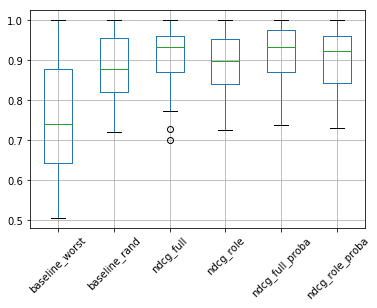

In [70]:
%matplotlib inline
pd.DataFrame(res)[['baseline_worst','baseline_rand','ndcg_full','ndcg_role','ndcg_full_proba','ndcg_role_proba']]\
    .boxplot(figsize=(5,8), rot=45)

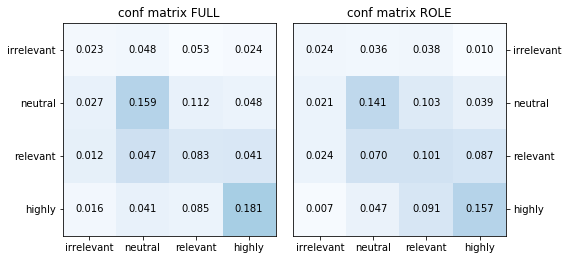

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm as colm
plt.figure(figsize=(8,5))
sub = plt.subplot(121)
normed = conf_matrix_full/conf_matrix_full.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
plt.title('conf matrix FULL')
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed[i][j]
        c='%.3f'%v
        sub.text(i, j, c, va='center', ha='center')



sub = plt.subplot(122)
normed = conf_matrix_role/conf_matrix_role.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
sub.yaxis.tick_right()
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed[i][j]
        c='%.3f'%v 
        sub.text(i, j, c, va='center', ha='center')
        
plt.title('conf matrix ROLE')

plt.tight_layout()
plt.show()

# Example Listing

In [11]:
skip = 500
limit = 20

experts = ['EXPERT_1', 'EXPERT_2', 'EXPERT_3','EXPERT_4', 'EXPERT_5', 'EXPERT_6','EXPERT_7', 'EXPERT_1.1', 'EXPERT_9','EXPERT_10']

for n, row in train.sample(20).iterrows():
    print('('+row['FILER_NAME']+' - '+row['ROLE'] + ' - '+row['MENTIONED_FINANCIAL_ENTITY']+')')
    
    #print(row)

(NORTHERN TRUST CORP - Guarantor - NTC Capital)
(MORGAN STANLEY - trustee - Morgan Stanley ABS Capital I Inc. Trust, Series 2007-NC3)
(STATE STREET CORP - Issuer - Equity Securities)
(Discover Financial Services - Counterparty - DFS Services LLC)
(CITIGROUP INC - trustee - The Bank of New York)
(PNC FINANCIAL SERVICES GROUP INC - Affiliates - Deferred Compensation Plan)
(CITIGROUP INC - affiliates - Citigroup Global Markets Japan)
(BANK OF AMERICA CORP - servicers - FNMA)
(Discover Financial Services - Issuer - Discover Bank)
(SUNTRUST BANKS INC - Counterparty - SunTrust Foundation)
(MORGAN STANLEY - trustee - The Bank of New York (Delaware))
(PNC FINANCIAL SERVICES GROUP INC - Affiliates - Deferred Compensation Plan)
(COMERICA INC - Agent - Comerica Incorporated)
(FIFTH THIRD BANCORP - counterparties - Fifth Third)
(SUNTRUST BANKS INC - affiliates - SunTrust)
(BANK OF AMERICA CORP - affiliates - Assured Guaranty)
(CAPITAL ONE FINANCIAL CORP - trustee - The Bank of New York Mellon)
(CA

In [21]:
for i, row in train[(train['FILER_NAME']=='MORGAN STANLEY')&(train['ROLE']=='trustee')&(train['MENTIONED_FINANCIAL_ENTITY']=='Morgan Stanley ABS Capital I Inc. Trust, Series 2007-NC3')].iterrows():
    print(row['THREE_SENTENCES'])
    print(row['rating_avg'])
    print()

On November 17, 2014, the plaintiff filed an amended complaint.
On November 6, 2013, Deutsche Bank, in its capacity as trustee, became the named plaintiff in Federal Housing Finance Agency, as Conservator for
the Federal Home Loan Mortgage Corporation, on behalf of the Trustee of the Morgan Stanley ABS Capital I Inc. Trust, Series 2007-NC3 (MSAC 2007-NC3) v. Morgan Stanley Mortgage Capital Holdings LLC , and filed a complaint in the Supreme
Court of NY under the caption Deutsche Bank National Trust Company, solely in its capacity as Trustee for Morgan Stanley ABS Capital I Inc. Trust, Series 2007-NC3 v. Morgan Stanley Mortgage Capital Holdings LLC, as Successor-by-Merger to Morgan
Stanley Mortgage Capital Inc. The complaint asserts claims for breach of contract and breach of the implied covenant of good faith and fair dealing and alleges, among other things, that the loans in the trust, which had an original principal
balance of approximately $1.3 billion, breached various representati

In [126]:
skip = 500
limit = 20

experts = ['EXPERT_1', 'EXPERT_2', 'EXPERT_3','EXPERT_4', 'EXPERT_5', 'EXPERT_6','EXPERT_7', 'EXPERT_1.1', 'EXPERT_9','EXPERT_10']

for n, row in train.sort_values('rating_avg', ascending=True)[skip:skip+limit].iterrows():
    print('>>>>> '+str(n)+' rating: '+row['rating']+' | ' + row['FILER_NAME']+' - '+row['ROLE'] + ' - '+row['MENTIONED_FINANCIAL_ENTITY'])
    print(row['THREE_SENTENCES'])
    print('---')
    for exp in experts:
        if not pd.isnull(row['RATING_'+exp]):
            print('  - ' + exp+': '+str(row['RATING_'+exp])+' > '+ str(row['COMMENT_'+exp]))
    
    print('---')
    print()
    #print(row)

>>>>> 817 rating: relevant | CAPITAL ONE FINANCIAL CORP - trustee - The Bank of New York Mellon Trust Company, N.A.
4.5.4
Guarantee Agreement, dated as of August 1, 2006, between Capital One Financial Corporation and The Bank of New York Mellon Trust Company, N.A., as guarantee trustee
(incorporated by reference to Exhibit 4.4 of the Corporation?s Current Report on Form 8-K, filed on August 4, 2006).4.5.5
---
  - EXPERT_2: Relevant > -1.1.-1
---

>>>>> 822 rating: relevant | CAPITAL ONE FINANCIAL CORP - Trustee - BNY Mellon Trust of Delaware
4.7.2
Amended and Restated Declaration of Trust of Capital One Capital V, dated as of August 5, 2009, between Capital One Financial Corporation as Sponsor, The Bank of New York
Mellon Trust Company, N.A., as institutional trustee, BNY Mellon Trust of Delaware, as Delaware Trustee and the Administrative Trustees named therein (incorporated by reference to Exhibit 4.3 of the Corporation?s Current Report on Form 8-K,
filed on August 6, 2009).4.7.3
---

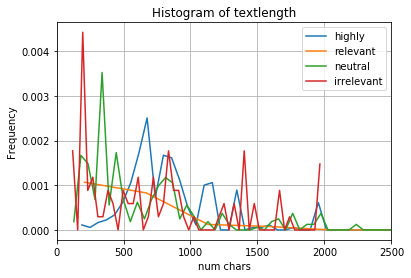

In [125]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d

bins = 20
# tmp = pd.DataFrame({'rating':train['rating'], 'len':train['THREE_SENTENCES'].str.len()})

for a in ['highly', 'relevant',  'neutral','irrelevant']:
    x = np.array(train[train['rating']==a]['THREE_SENTENCES'].str.len())
    n, bins = np.histogram(x, 50, normed=1)

    f = interp1d(bins[:-1], n, kind='cubic')
    l = plt.plot(bins[:-1], f(bins[:-1]), label=a)

plt.xlabel('num chars')
plt.ylabel('Frequency')
plt.title('Histogram of textlength')
#plt.axis([0,2000, 0, 140])#0.004])
plt.xlim(0,2500)
plt.legend()
plt.grid(True)

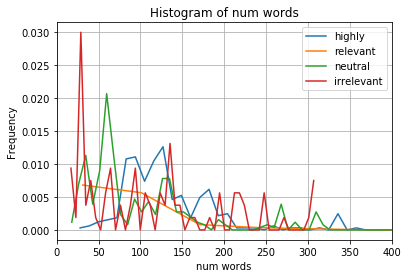

In [41]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d

bins = 20
# tmp = pd.DataFrame({'rating':train['rating'], 'len':train['THREE_SENTENCES'].str.len()})

for a in ['highly', 'relevant',  'neutral','irrelevant']:
    x = np.array([len(s.split()) for _,s in train[train['rating']==a]['THREE_SENTENCES'].iteritems()])
    n, bins = np.histogram(x, 50, normed=1)

    f = interp1d(bins[:-1], n, kind='cubic')
    l = plt.plot(bins[:-1], f(bins[:-1]), label=a)

plt.xlabel('num words')
plt.ylabel('Frequency')
plt.title('Histogram of num words')
#plt.axis([0,2000, 0, 140])#0.004])
plt.xlim(0,400)
plt.legend()
plt.grid(True)